## Start of our student loan balance analysis

- updated employement to employment in cleaned data set
- remove .../data/ -->pls add back if needed
- updated install package and library
- added EDA
- added checking for assumptions
- Elastic net model part added charts

In [25]:
# Install packages
install.packages(c('janitor','car','tidyr','gtsummary','glue'))


The downloaded binary packages are in
	/var/folders/fn/64lk1btn1bn0n_6xftkww56c0000gn/T//Rtmpc3Hche/downloaded_packages


In [5]:
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)
library(glmnet)
library(car)
library(dplyr)
library(janitor)
library(purrr)
library(glue)
library(stringr)
library(readxl)
library(tidyr)
library(ggplot2)
library(gtsummary)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Loading required package: Matrix

Loaded glmnet 4.1-9

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:purrr':

    some


The following object is masked from 'package:dplyr':

    recode



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




ERROR: Error in library(gtsummary): there is no package called 'gtsummary'


## Data Cleaning

In [2]:
load_and_combine_data <- function(directory_path) {
  
  file_pattern <- glue(".*-Data\\.csv$")
  
  file_paths <- list.files(path = directory_path, pattern = file_pattern, full.names = TRUE)
  
  list_of_dfs <- map(file_paths, function(path) { 
    
    year_match_result <- regmatches(path, regexpr("Y(\\d{4})\\.*", path))
    
    year_extracted <- sub("Y(\\d{4})\\.*", "\\1", year_match_result)
    
    read.csv(path, skip = 1, na.strings = c("N", "-", "(X)", "null")) %>% 
      clean_names() %>%
      mutate(year = as.numeric(year_extracted)) %>%
      mutate(state = str_trim(str_extract(geographic_area_name, ",\\s*([^,]+)$"), side = "left"),
             state = str_replace(state, "^,\\s*", "")) %>%
      select(-contains(c("margin_of_error", "ratio", "unit", "percent", "x", "geograph")))
      }
    )
  
  common_columns <- names(list_of_dfs[[1]])
  
  for (i in 2:length(list_of_dfs)) {
    common_columns <- intersect(common_columns, names(list_of_dfs[[i]]))
  }
  
  list_of_dfs_common_cols <- map(list_of_dfs, ~ .x %>% select(all_of(common_columns)))
  
  for (col_name in common_columns) {
    first_col_type <- class(list_of_dfs_common_cols[[1]][[col_name]])
    
    if (first_col_type %in% c("numeric", "integer")) {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.numeric(df[[col_name]])
        df
      })
    } else if (first_col_type == "factor") {
      list_of_dfs_common_cols <- map(list_of_dfs_common_cols, function(df) {
        df[[col_name]] <- as.character(df[[col_name]])
        df
      })
    }
  }
  
  yearly_data <- bind_rows(list_of_dfs_common_cols)
  
  yearly_data
}

load_and_combine_borrower_data <- function(filepath, sheet_numbers, years) {

  combined_borrower_data <- map2_df(sheet_numbers, years, function(sheet, year) {
    read_excel(filepath, sheet = sheet, skip = 7) %>%
    clean_names() %>%
    mutate(year = year)
  })
  
  final_borrower_data <- combined_borrower_data %>%
    select(state, year, total_borrowers, total_balance_billions)
  
  final_borrower_data
}

dem_data <- load_and_combine_data("dem") 
economic_data <- load_and_combine_data("economic")
mean_income_data <- load_and_combine_data("mean_income")
social_char_data <- load_and_combine_data("social_char") 
borrower_data <-load_and_combine_borrower_data("Student-loan-update-2025-Mangrum.xlsx", 11:15, 2019:2023)

dim(dem_data)

dem_data_cleaned <- dem_data %>%
  rename(total_population = estimate_race_total_population,
         race_white = estimate_race_total_population_one_race_white,
         race_black = estimate_race_total_population_one_race_black_or_african_american,
         race_asian = estimate_race_total_population_one_race_asian,
         race_native = estimate_race_total_population_one_race_american_indian_and_alaska_native,
         race_pacific_islander = estimate_race_total_population_one_race_native_hawaiian_and_other_pacific_islander,
         race_other = estimate_race_total_population_one_race_some_other_race,
         race_two_or_more = estimate_race_total_population_two_or_more_races,
         hispanic_or_latino = estimate_hispanic_or_latino_and_race_total_population_hispanic_or_latino_of_any_race,
         total_18_or_over_population = estimate_citizen_voting_age_population_citizen_18_and_over_population,
         population_18_or_over_male = estimate_citizen_voting_age_population_citizen_18_and_over_population_male,
         population_18_or_over_female = estimate_citizen_voting_age_population_citizen_18_and_over_population_female) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(race_two_or_more:hispanic_or_latino, ~./total_population),
         across(population_18_or_over_male:population_18_or_over_female, ~./total_18_or_over_population))

economic_data_cleaned <- economic_data %>%
  rename(employment_total = estimate_employment_status_population_16_years_and_over,
         employment_total_employed = estimate_employment_status_population_16_years_and_over_in_labor_force,
         employment_total_unemployed = estimate_employment_status_population_16_years_and_over_not_in_labor_force) %>%
  select(-contains("estimate"))  %>%
  group_by(state, year) %>%
  summarise(across(everything(), ~sum(., na.rm=TRUE))) %>%
  ungroup() %>%
  mutate(across(employment_total_employed:employment_total_unemployed, ~./employment_total)) %>%
  select(-employment_total)

mean_income_data_cleaned <- mean_income_data %>%
  group_by(state, year) %>%
  summarise(mean_household_income_dollars = mean(estimate_mean_income_dollars_household_income_all_households, na.rm=TRUE)) %>%
  ungroup()

social_char_data_cleaned <- social_char_data %>%
  rename(average_household_size = estimate_households_by_type_total_households_average_household_size,
         total_veteran_eligible = estimate_veteran_status_civilian_population_18_years_and_over,
         total_veteran = estimate_veteran_status_civilian_population_18_years_and_over_civilian_veterans,
         total_population_degree = estimate_educational_attainment_population_25_years_and_over,
         total_population_bachelors_degree = estimate_educational_attainment_population_25_years_and_over_bachelor_s_degree_or_higher,
         total_foreign_born_pop = estimate_u_s_citizenship_status_foreign_born_population,
         total_households = estimate_households_by_type_total_households,
         total_household_w_internet = estimate_computers_and_internet_use_total_households_with_a_broadband_internet_subscription) %>%
  select(-contains("estimate")) %>%
  group_by(state, year) %>%
  summarise(across(-average_household_size, ~sum(., na.rm=TRUE)), 
            average_household_size = mean(average_household_size, na.rm=TRUE)) %>%
  ungroup() %>%
  mutate(total_veteran = total_veteran/total_veteran_eligible, 
         total_population_bachelors_degree = total_population_bachelors_degree/total_population_degree,
         total_household_w_internet = total_household_w_internet/total_households) %>%
  select(-c(total_veteran_eligible, total_population_degree, total_households))


combined_data <- dem_data_cleaned %>%
  left_join(economic_data_cleaned, by = c("state", "year")) %>%
  left_join(mean_income_data_cleaned, by = c("state", "year")) %>%
  left_join(social_char_data_cleaned, by = c("state", "year")) %>%
  left_join(borrower_data, by = c("state", "year")) %>%
  relocate(state, year) %>%
  filter(!state == "Puerto Rico", !state == "District of Columbia") %>%
  mutate(total_foreign_born_pop = total_foreign_born_pop/total_population,
         total_borrowers = total_borrowers/total_18_or_over_population) %>%
  select(-c(total_population, total_18_or_over_population))

write.csv(combined_data, "combined_clean_data.csv", row.names = FALSE)
cat("Save successful! Check `data/`")

[1] 16106    50

`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


Save successful! Check `data/`

In [8]:
student_debt_data = read.csv("../data/combined_clean_data.csv", header=TRUE, na.strings = "")
head(student_debt_data)

state   year race_two_or_more race_white race_black race_native race_asian
1 Alabama 2019 0.01891207       0.6809017  0.26640308 0.005242758 0.01359036
2 Alabama 2020 0.02438534       0.6749864  0.26594513 0.005060915 0.01387828
3 Alabama 2021 0.03107745       0.6680286  0.26496981 0.004334215 0.01403873
4 Alabama 2022 0.03691897       0.6620826  0.26378614 0.004200798 0.01388360
5 Alabama 2023 0.04512042       0.6535822  0.26087080 0.004449916 0.01423930
6 Alaska  2019 0.08230584       0.6458224  0.03283958 0.148902137 0.06230090
  race_pacific_islander race_other hispanic_or_latino ⋯
1 0.0004589592          0.01449105 0.04278411         ⋯
2 0.0004173150          0.01532662 0.04351991         ⋯
3 0.0003405584          0.01721060 0.04495270         ⋯
4 0.0004480825          0.01867985 0.04622171         ⋯
5 0.0005072955          0.02123004 0.05374484         ⋯
6 0.0124873146          0.01534187 0.07037343         ⋯
  employment_total_employed employment_total_unemployed
1 0.5740216                 0.4259784                  
2 0.5755210                 0.4244790                  
3 0.5776099                 0.4223901                  
4 0.5795181                 0.4204819                  
5 0.5814381                 0.4185619                  
6 0.6862883                 0.3137117                  
  mean_household_income_dollars total_population_bachelors_degree total_veteran
1 59561.31                      0.2546833                         0.08766780   
2 61632.36                      0.2622735                         0.08581328   
3 65245.01                      0.2666894                         0.08416339   
4 70621.25                      0.2720839                         0.08110404   
5 73195.54                      0.2775514                         0.07932469   
6 82843.90                      0.2955121                         0.12186167   
  total_foreign_born_pop total_household_w_internet average_household_size
1 0.03546721             0.7639913                  2.569403              
2 0.03434429             0.7991543                  2.545970              
3 0.03470194             0.8204571                  2.627761              
4 0.03524339             0.8378641                  2.570597              
5 0.03799553             0.8561986                  2.517463              
6 0.07823837             0.8553875                  2.920000              
  total_borrowers total_balance_billions
1 0.1646643       21.57                 
2 0.1621598       22.29                 
3 0.1625385       23.07                 
4 0.1634605       23.38                 
5 0.1643160       23.57                 
6 0.1394737        2.40

## Exploratory Data Analysis

The cleaned dataset has updated the data on employment status to show the proportion between the employment and unemployment population ratios in the population by state per year.

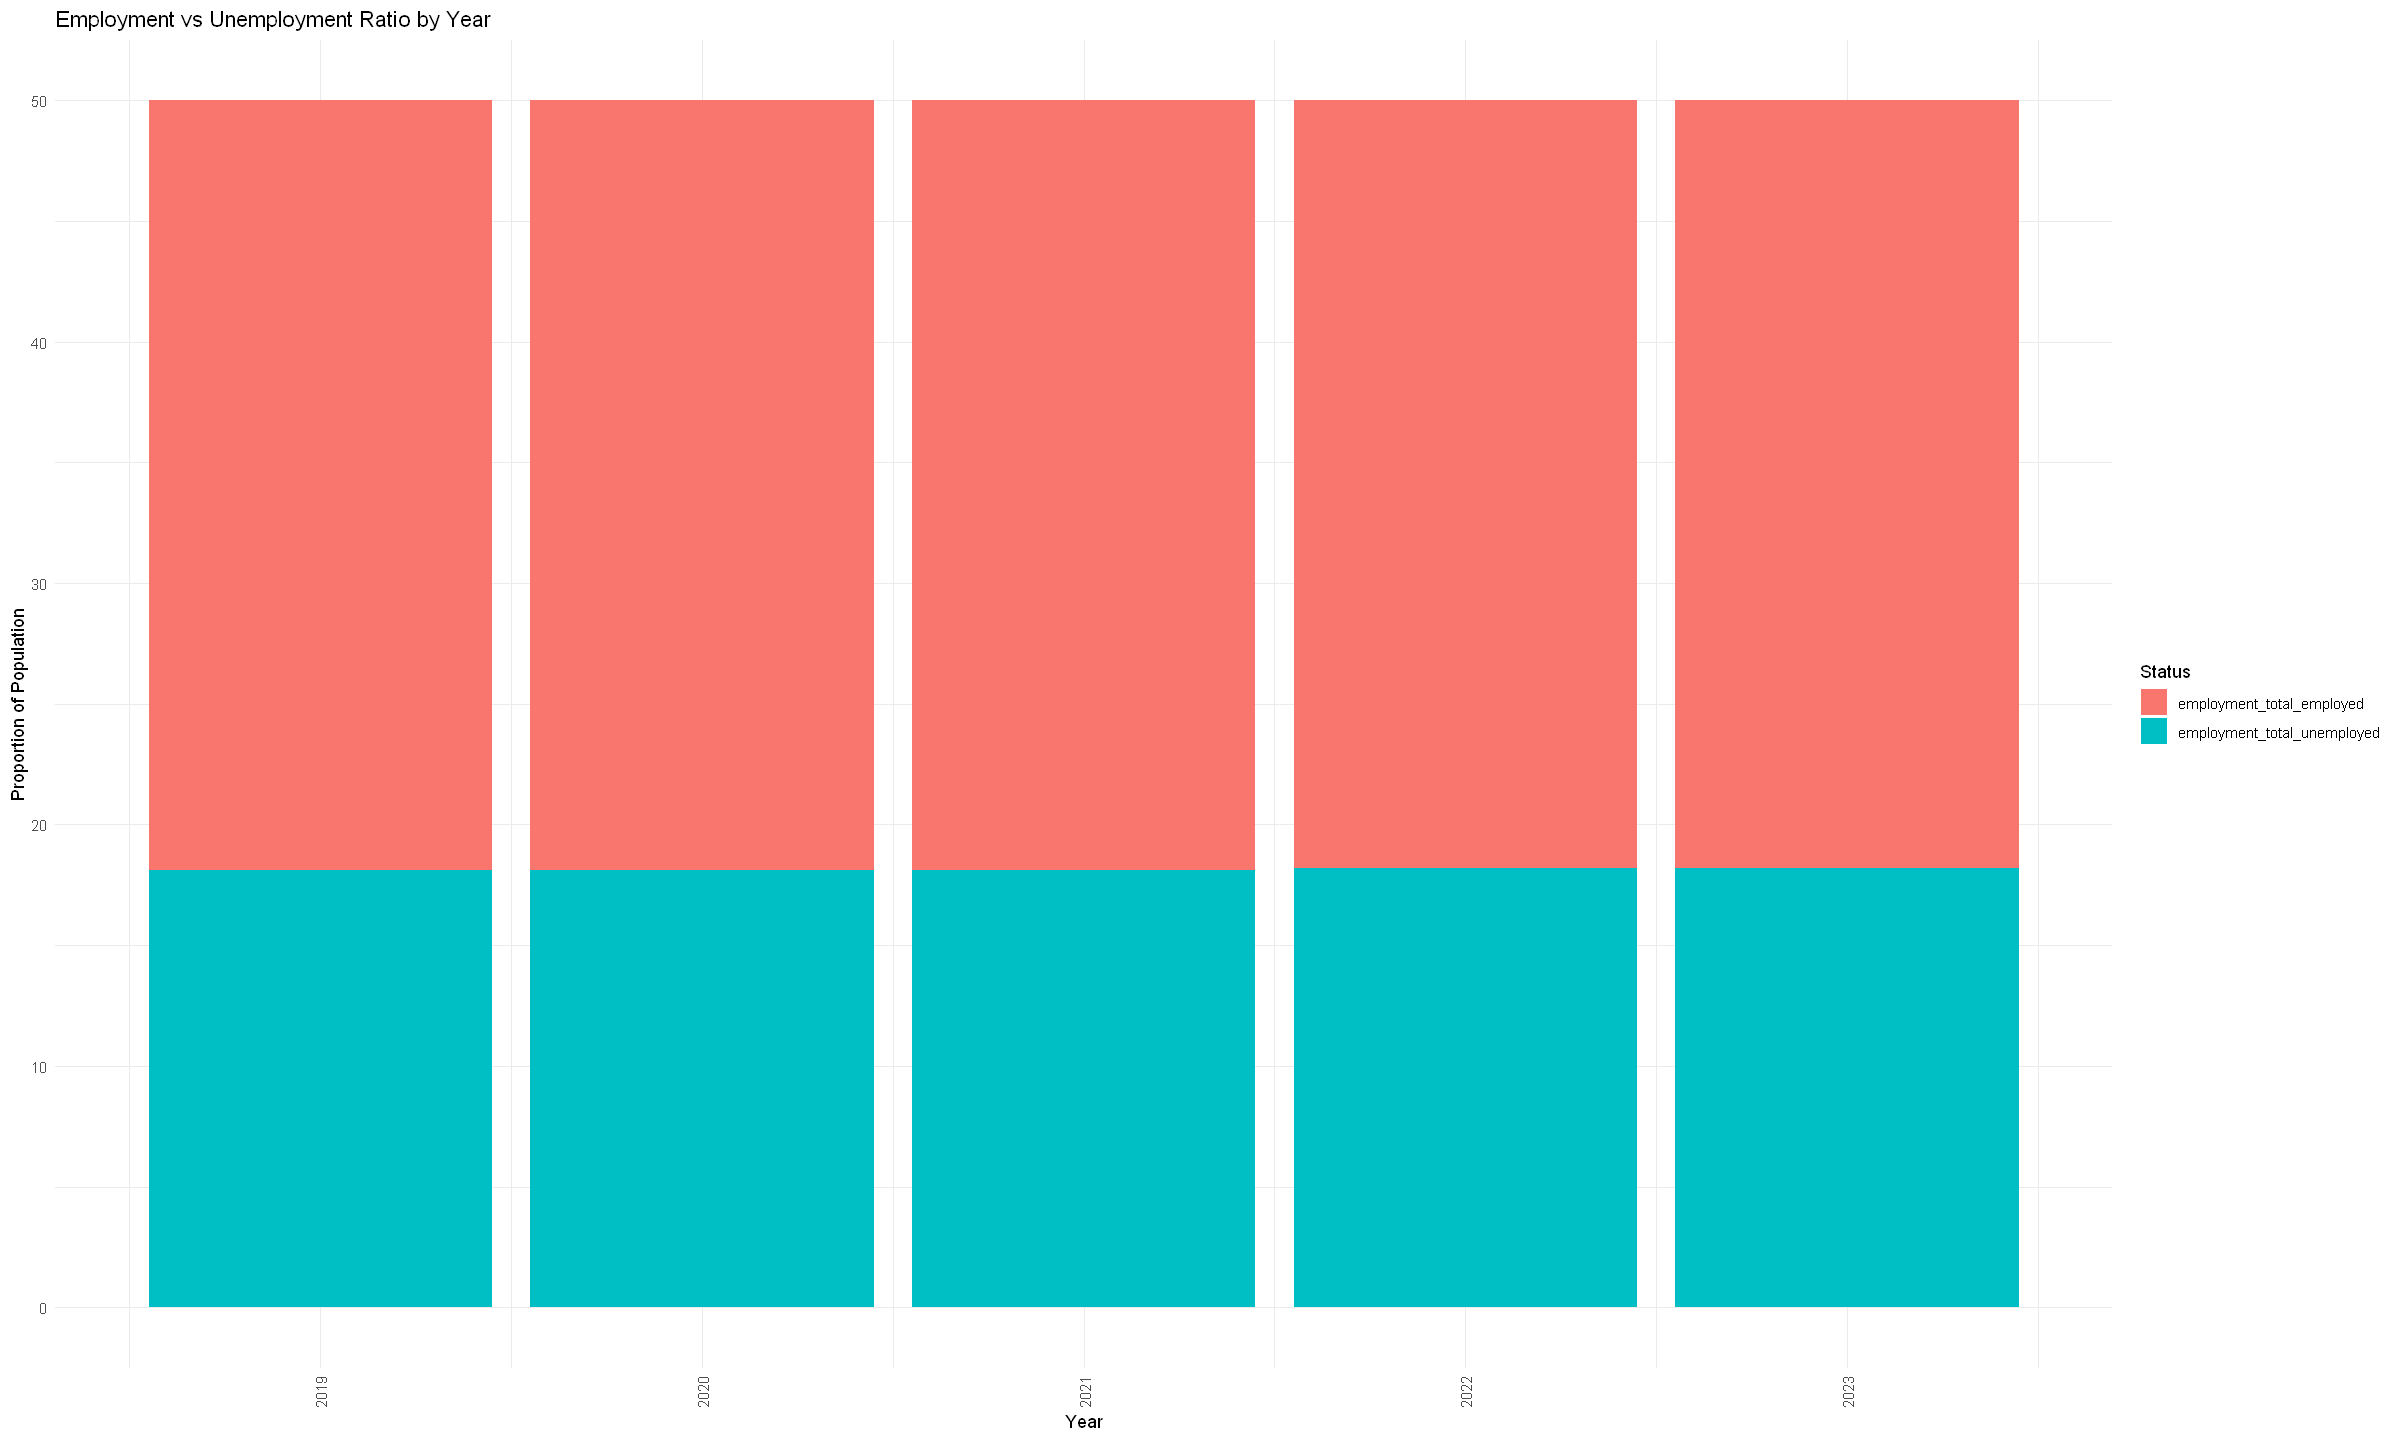

In [9]:
library(IRdisplay)
options(repr.plot.width = 20, repr.plot.height = 12) 

employment_plot_data <- student_debt_data %>%
  select(year, employment_total_employed, employment_total_unemployed) %>%
  pivot_longer(cols = c(employment_total_employed, employment_total_unemployed),
               names_to = "status",
               values_to = "proportion")

# Plot
ggplot(employment_plot_data, aes(x = year, y = proportion, fill = status)) +
  geom_bar(stat = "identity") +
  labs(title = "Employment vs Unemployment Ratio by Year",
       x = "Year",
       y = "Proportion of Population",
       fill = "Status") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))



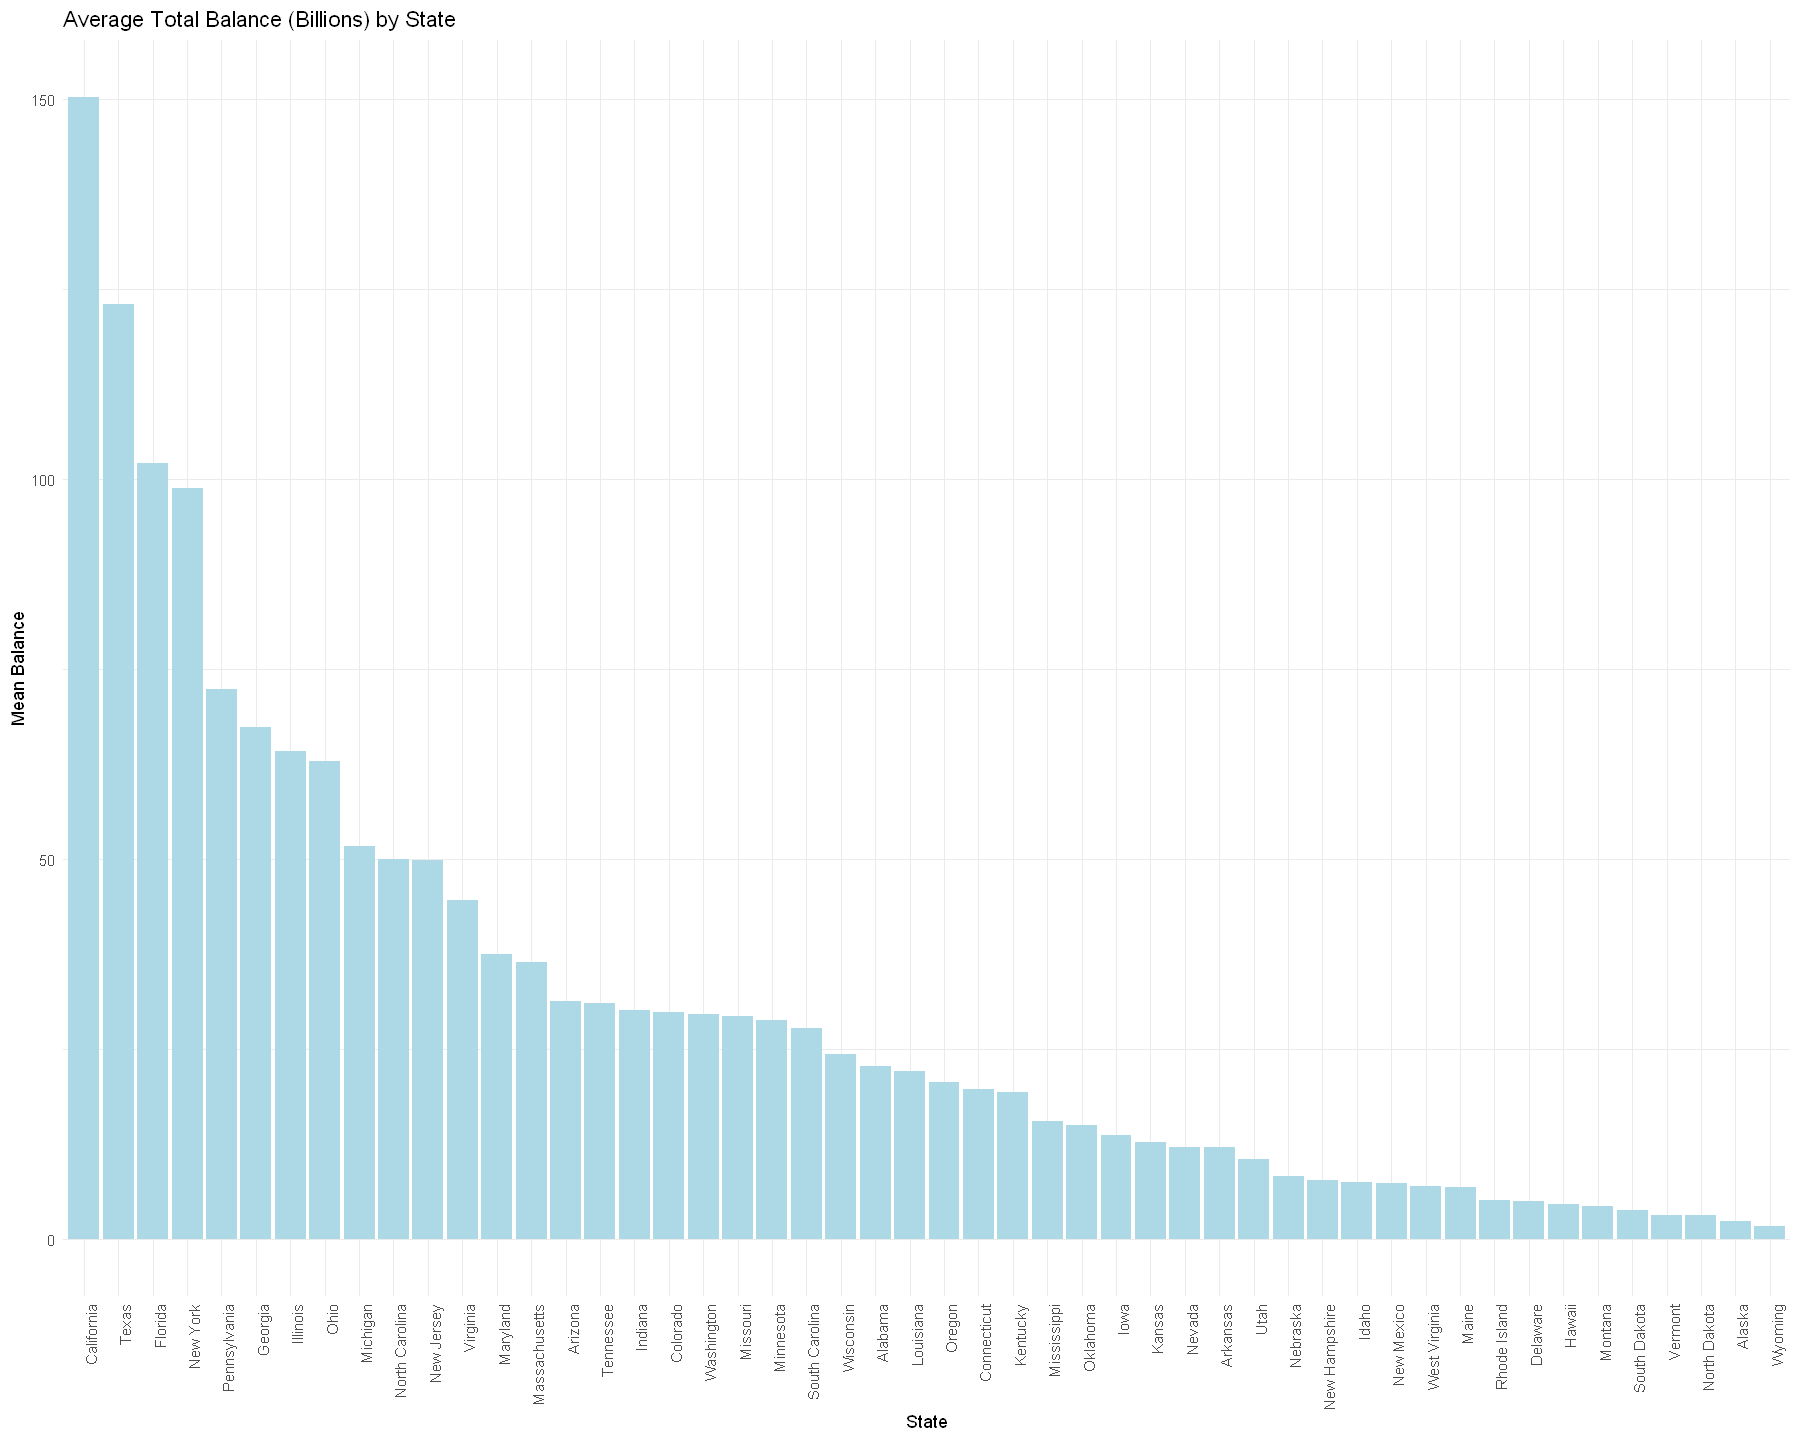

In [10]:
options(repr.plot.width = 15, repr.plot.height = 12) 
student_debt_data %>%
  group_by(state) %>%
  summarise(mean_debt = mean(total_balance_billions, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(state, -mean_debt), y = mean_debt)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  labs(title = "Average Total Balance (Billions) by State",
       x = "State", y = "Mean Balance") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

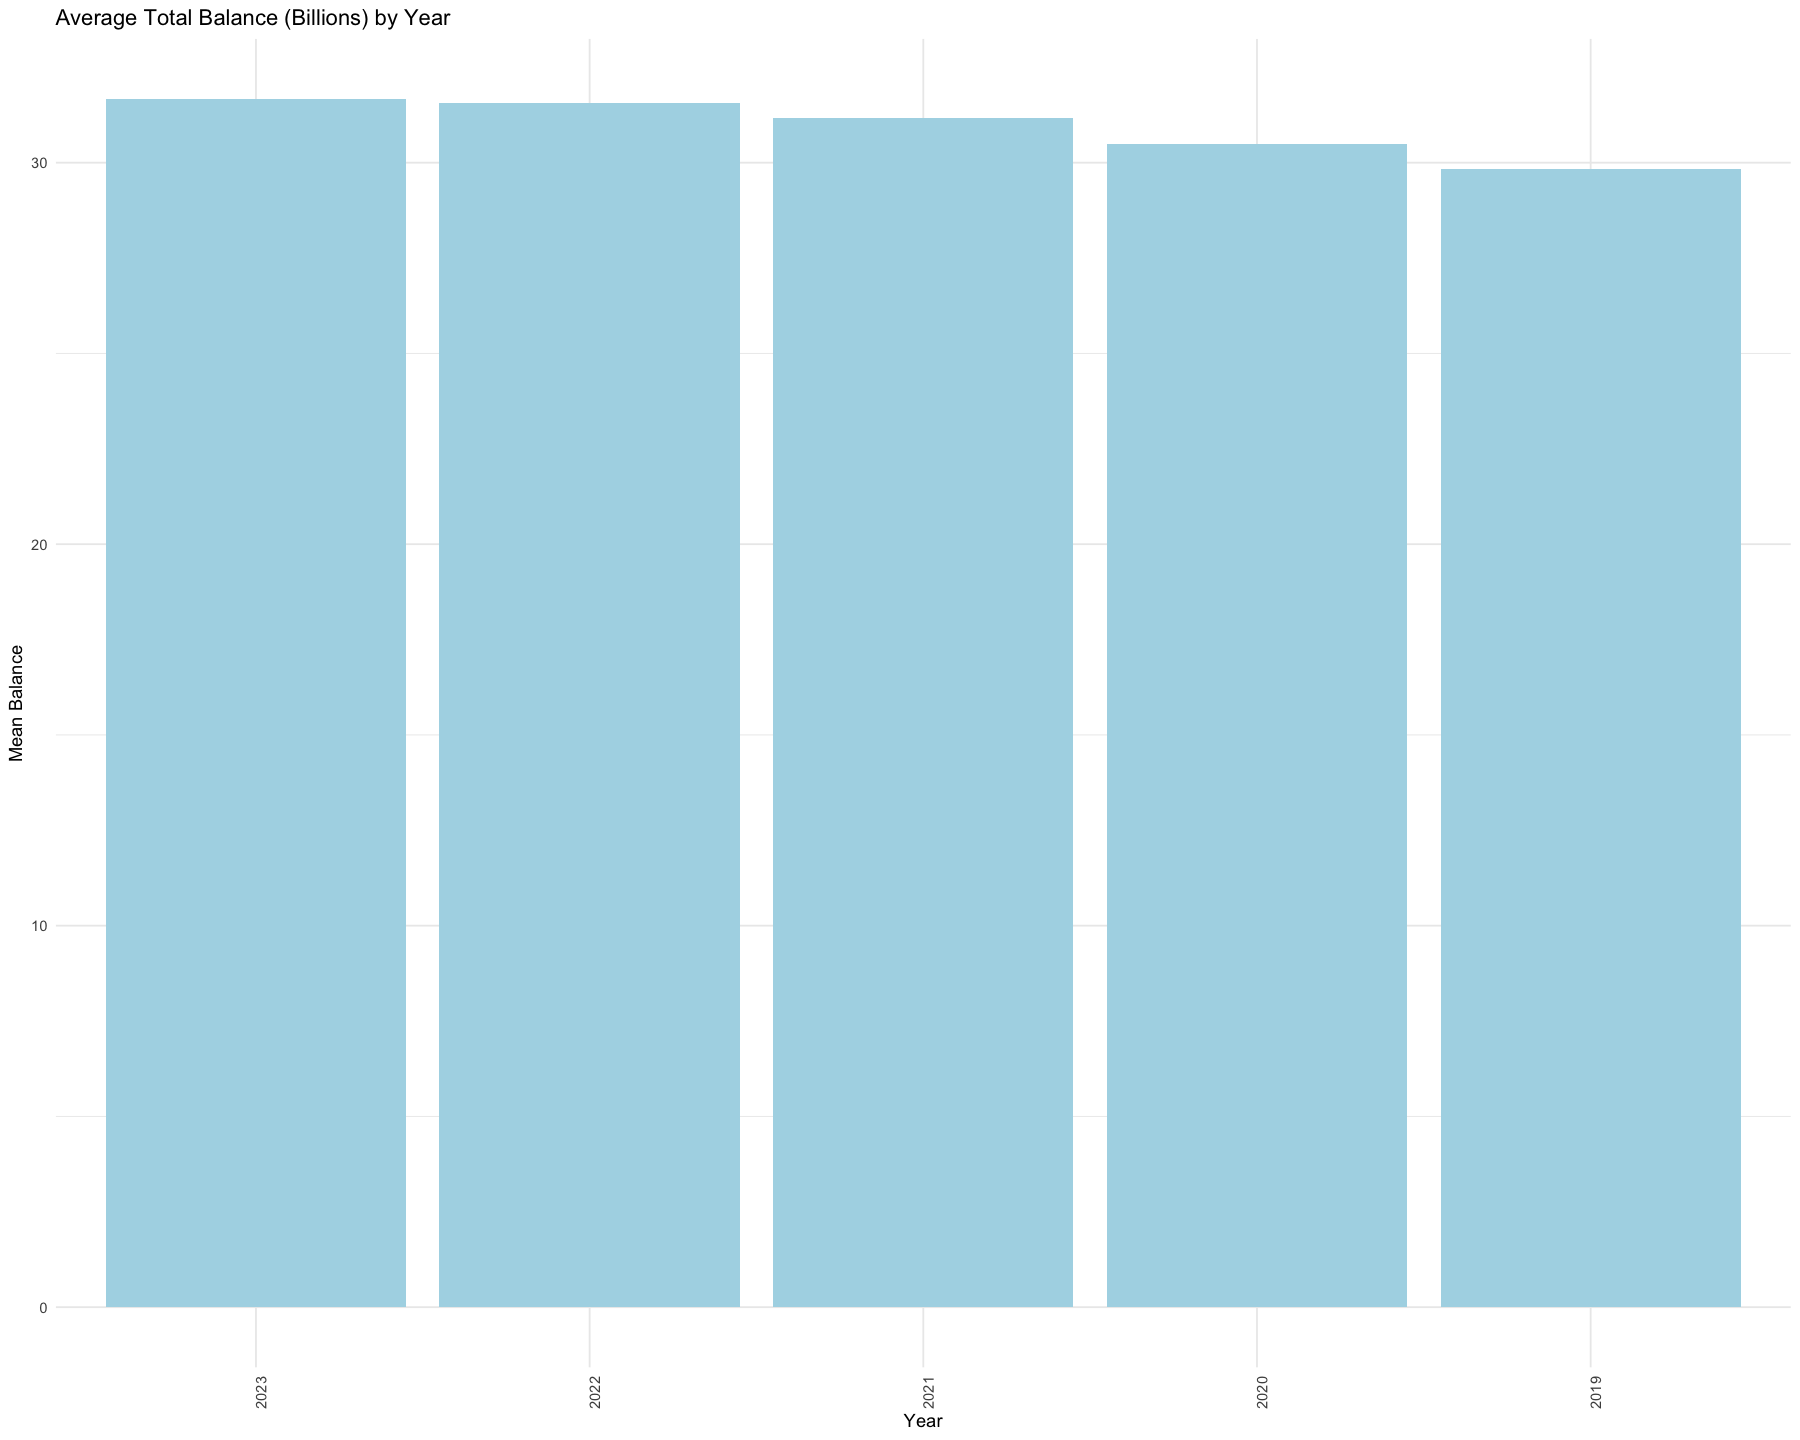

In [21]:
options(repr.plot.width = 15, repr.plot.height = 12) 

student_debt_data %>%
  group_by(year) %>%
  summarise(mean_debt = mean(total_balance_billions, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(year, -mean_debt), y = mean_debt)) +
  geom_bar(stat = "identity", fill = "lightblue") +
  labs(title = "Average Total Balance (Billions) by Year",
       x = "Year", y = "Mean Balance") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

The cleaned dataset has updated the data on races to show the proportion of race ratio, so apply count to for race ratio, can discuss how to draft this, I feel like not absolutely right.

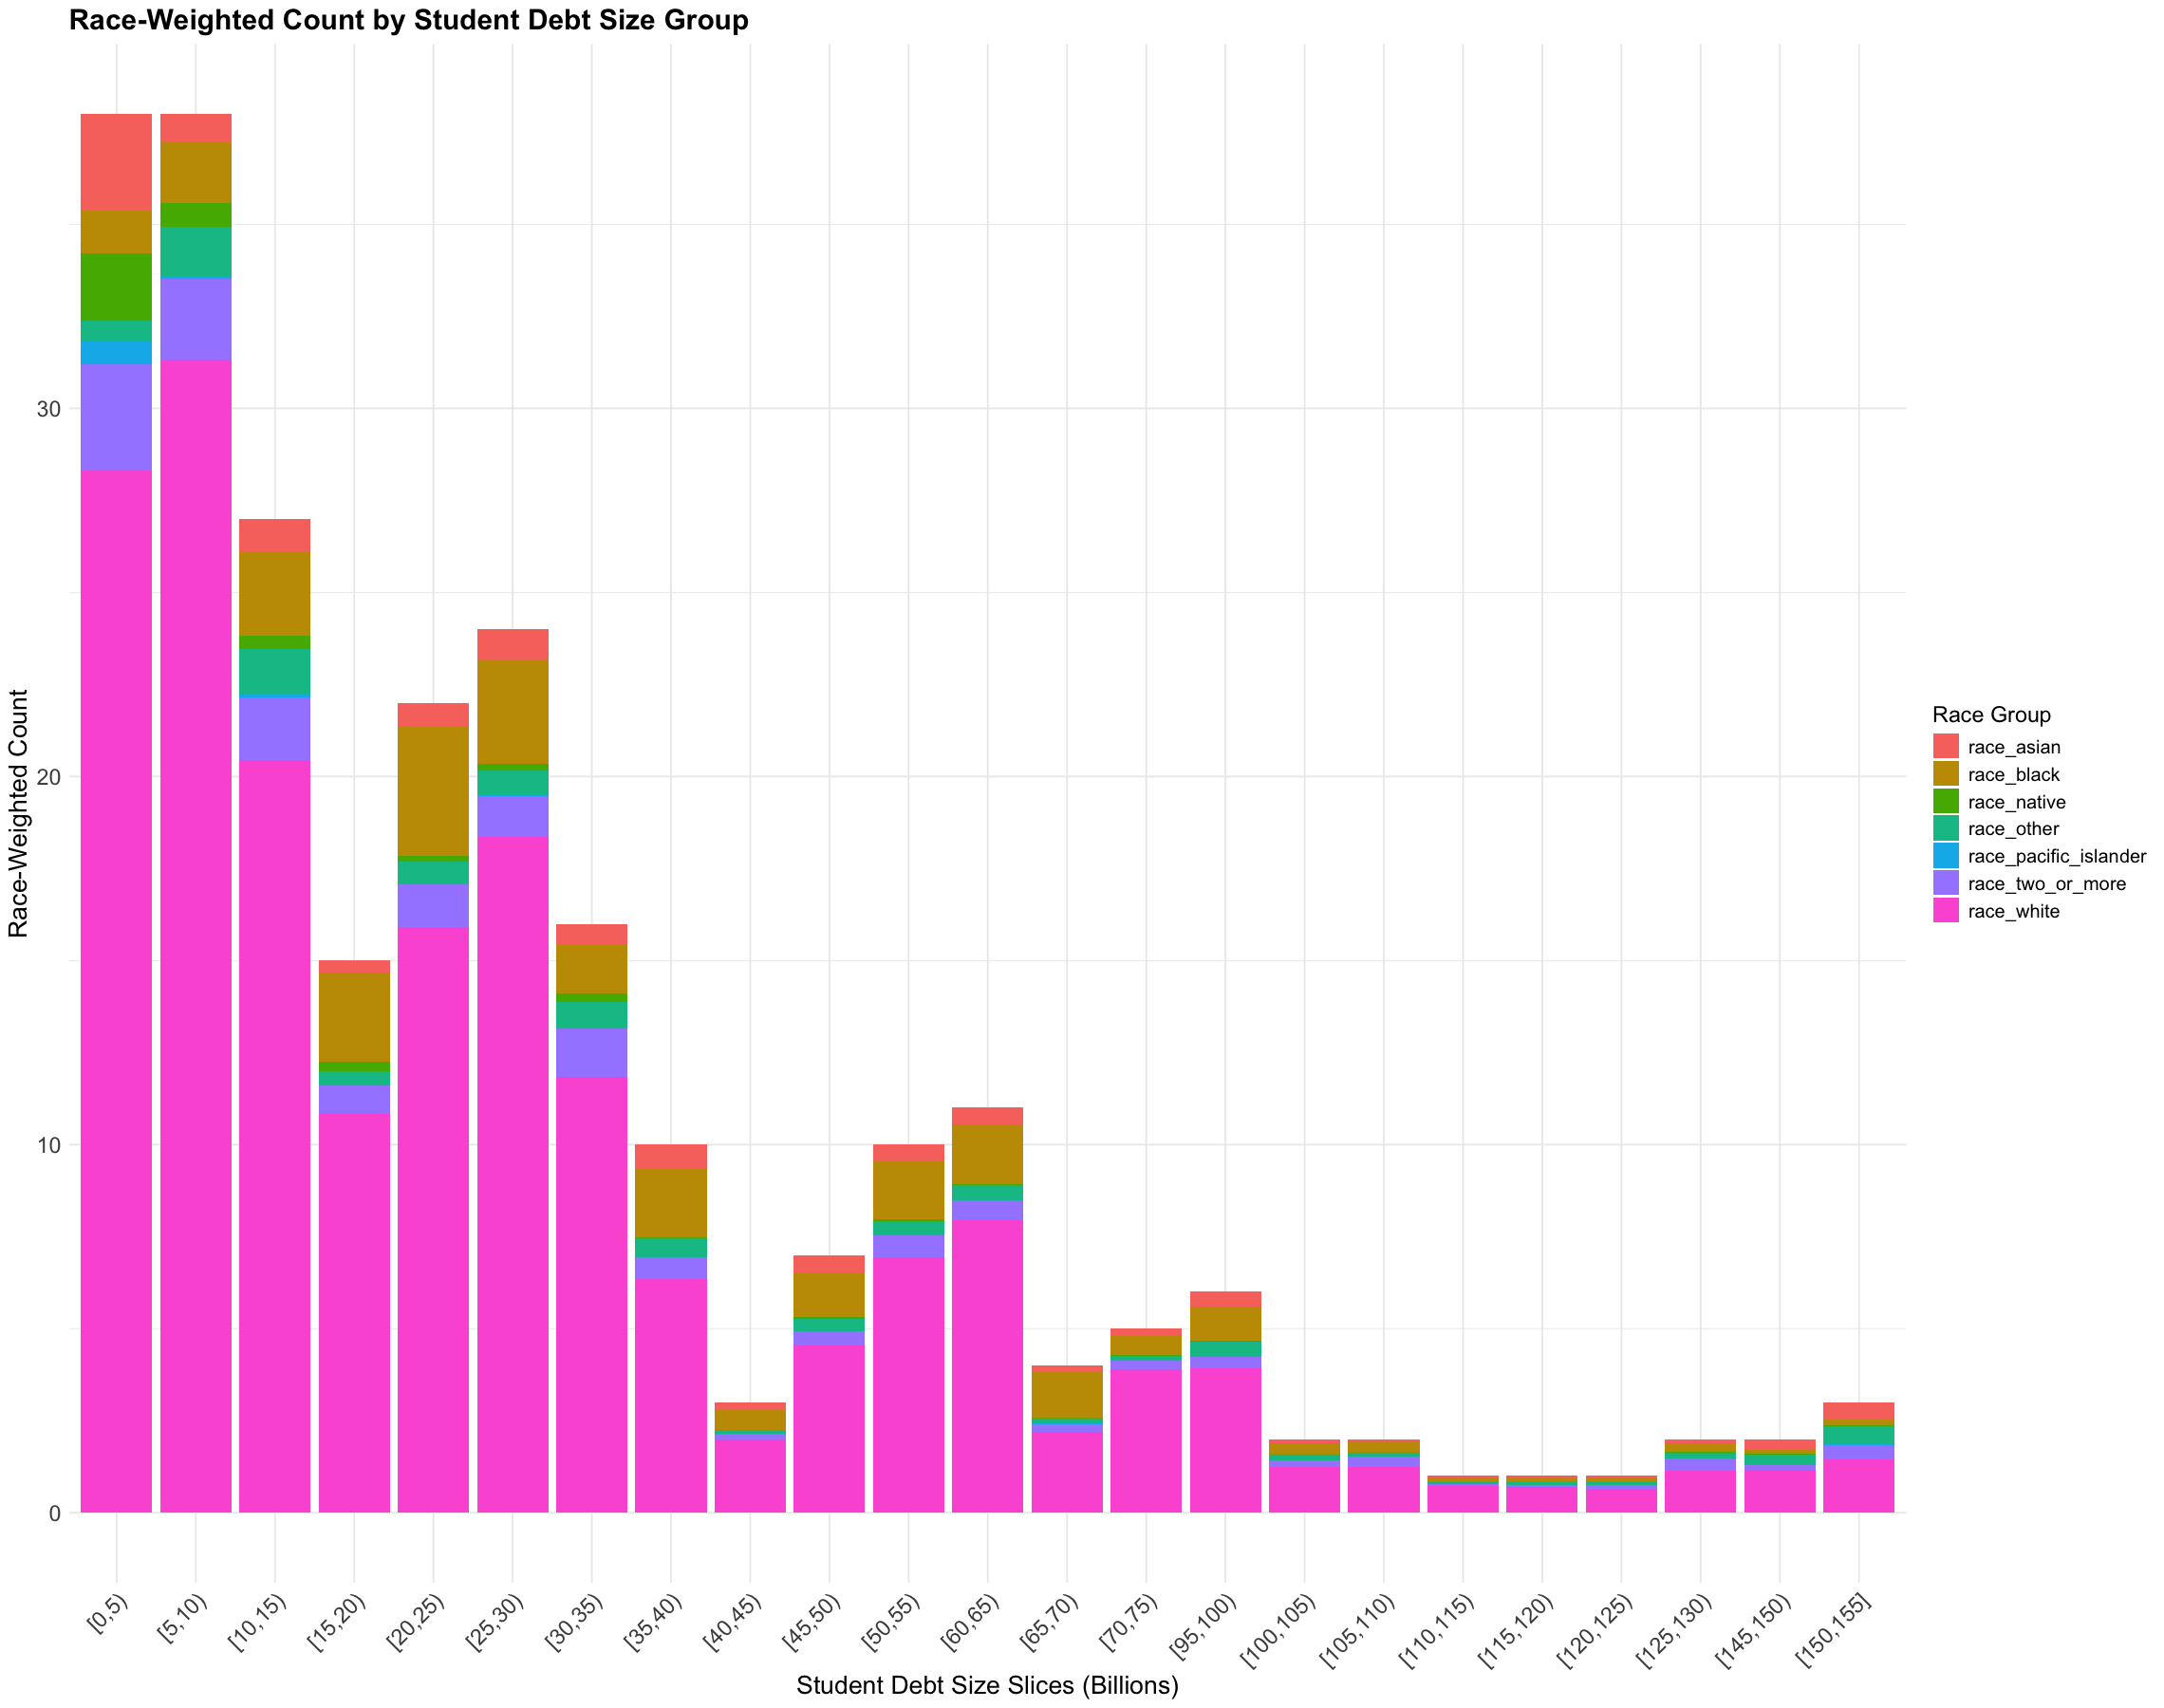

In [43]:
options(repr.plot.width = 19, repr.plot.height = 15) 

slice_data <- student_debt_data %>%
  mutate(debt_slice = cut(total_balance_billions,
                        breaks = seq(0, ceiling(max(total_balance_billions, na.rm = TRUE)/5)*5, by = 5),
                        include.lowest = TRUE,
                        right = FALSE))

race_counts_long <- slice_data %>%
  select(debt_slice, starts_with("race_")) %>%
  pivot_longer(cols = starts_with("race_"), names_to = "race_group", values_to = "race_weight") %>%
  group_by(debt_slice, race_group) %>%
  summarise(count = sum(race_weight, na.rm = TRUE), .groups = "drop")

ggplot(race_counts_long, aes(x = debt_slice, y = count, fill = race_group)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Race-Weighted Count by Student Debt Size Group",
    x = "Student Debt Size Slices (Billions)",
    y = "Race-Weighted Count",
    fill = "Race Group"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14),  
    axis.title.x = element_text(size = 16),                        
    axis.text.y = element_text(size = 14),                         
    axis.title.y = element_text(size = 16),    
    plot.title = element_text(size = 18, face = "bold"),
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )

## Data Prep for models

In [44]:
train_idx <- sample(seq_len(nrow(student_debt_data)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_data[train_idx, ]
test_data <- student_debt_data[-train_idx, ]
# Prep train data
train_data <- train_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
# Prepare test data
test_data <- test_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)

## Full MLR Model

In [50]:
set.seed(123)
mlr_model <- lm(total_balance_billions ~ ., data = train_data)
summary(mlr_model)


Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.637 -10.313   0.322   9.809  35.530 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -9.030e+02  1.466e+02  -6.158 4.72e-09 ***
race_two_or_more                   5.107e+02  1.503e+02   3.398 0.000837 ***
race_white                         2.588e+02  1.284e+02   2.015 0.045436 *  
race_black                         2.527e+02  1.316e+02   1.921 0.056379 .  
race_native                        2.161e+02  1.560e+02   1.385 0.167801    
race_asian                         9.080e+02  2.061e+02   4.406 1.81e-05 ***
race_pacific_islander             -4.396e+03  8.018e+02  -5.483 1.41e-07 ***
hispanic_or_latino                 5.289e+01  3.389e+01   1.561 0.120372    
population_18_or_over_male         1.096e+03  2.743e+02   3.997 9.37e-05 ***
employment_total_employed          3.395e+01  6.843e+0

## Log-Transformed MLR Model

In [47]:
set.seed(123)
mlr_model_transformed <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed)


Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.57464 -0.25413  0.02238  0.30795  0.95278 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -2.010e+01  4.948e+00  -4.062 7.28e-05 ***
race_two_or_more                   2.235e+01  5.072e+00   4.407 1.81e-05 ***
race_white                         1.248e+01  4.334e+00   2.879  0.00447 ** 
race_black                         1.329e+01  4.439e+00   2.993  0.00316 ** 
race_native                        2.071e+00  5.265e+00   0.393  0.69449    
race_asian                         3.406e+01  6.954e+00   4.898 2.15e-06 ***
race_pacific_islander             -7.296e+01  2.705e+01  -2.697  0.00767 ** 
hispanic_or_latino                 1.546e+00  1.143e+00   1.352  0.17794    
population_18_or_over_male         1.116e+01  9.255e+00   1.206  0.22951    
employment_total_employed         -3.00

## Clustered Model

In [46]:
state_features_for_clustering <- student_debt_data %>%
  group_by(state) %>%
  summarise(
    across(
      .cols = -c(year),
      .fns = mean,
      na.rm = TRUE
    ),
    .groups = "drop"
  )

state_features_for_clustering_clean <- na.omit(state_features_for_clustering)

state_names_for_clustering <- state_features_for_clustering_clean$state

numeric_state_features <- state_features_for_clustering_clean %>%
  select(where(is.numeric))

scaled_state_features <- scale(numeric_state_features)

kmeans_result <- kmeans(scaled_state_features, centers = 5, nstart = 25)

state_cluster_map <- data.frame(
  state = state_names_for_clustering,
  state_cluster = as.factor(kmeans_result$cluster)
)

combined_data_with_clusters <- student_debt_data %>%
  left_join(state_cluster_map, by = "state")

 train_idx <- sample(seq_len(nrow(combined_data_with_clusters)), size = floor(0.8 * nrow(combined_data_with_clusters)))
train_data_cluster <- combined_data_with_clusters[train_idx, ]
test_data_cluster <- combined_data_with_clusters[-train_idx, ]

train_data <- train_data_cluster %>%
  select(-state, -year, -race_other, -population_18_or_over_female, -employment_total_unemployed)

mlr_model_cluster <- lm(total_balance_billions ~ ., data = train_data)
summary(mlr_model_cluster)


Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(.cols = -c(year), .fns = mean, na.rm = TRUE)`.
ℹ In group 1: `state = "Alabama"`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”



Call:
lm(formula = total_balance_billions ~ ., data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.637 -10.313   0.322   9.809  35.530 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -9.030e+02  1.466e+02  -6.158 4.72e-09 ***
race_two_or_more                   5.107e+02  1.503e+02   3.398 0.000837 ***
race_white                         2.588e+02  1.284e+02   2.015 0.045436 *  
race_black                         2.527e+02  1.316e+02   1.921 0.056379 .  
race_native                        2.161e+02  1.560e+02   1.385 0.167801    
race_asian                         9.080e+02  2.061e+02   4.406 1.81e-05 ***
race_pacific_islander             -4.396e+03  8.018e+02  -5.483 1.41e-07 ***
hispanic_or_latino                 5.289e+01  3.389e+01   1.561 0.120372    
population_18_or_over_male         1.096e+03  2.743e+02   3.997 9.37e-05 ***
employment_total_employed          3.395e+01  6.843e+0

## Transformed Clustered Model

In [48]:
train_data_cluster_transformed <- train_data_cluster %>%
mutate(log_total_balance_billions = log(total_balance_billions))

mlr_model_cluster_transformed <- lm(log_total_balance_billions ~ ., data = train_data_cluster_transformed)
summary(mlr_model_cluster_transformed)


Call:
lm(formula = log_total_balance_billions ~ ., data = train_data_cluster_transformed)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.047539 -0.004681  0.000653  0.006522  0.031657 

Coefficients: (7 not defined because of singularities)
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        2.608e+01  2.196e+01   1.188 0.237123    
stateAlaska                       -1.173e+00  2.872e-01  -4.083 7.66e-05 ***
stateArizona                       4.131e-01  2.060e-01   2.005 0.046979 *  
stateArkansas                     -3.834e-01  1.126e-01  -3.406 0.000875 ***
stateCalifornia                    7.976e-01  3.165e-01   2.520 0.012919 *  
stateColorado                     -4.407e-02  2.036e-01  -0.216 0.828966    
stateConnecticut                  -5.800e-01  1.688e-01  -3.437 0.000787 ***
stateDelaware                     -1.678e+00  8.454e-02 -19.852  < 2e-16 ***
stateFlorida                       9.569e-01  

## Elastic Net Model

In [49]:
all_var <- model.matrix(total_balance_billions ~ . -1, data = train_data) 
elastic_net_model_cv <- glmnet::cv.glmnet(all_var, train_data$total_balance_billions, family='gaussian', alpha=0.5, nfolds=10)
elastic_net_model <- glmnet::glmnet(all_var, train_data$total_balance_billions, family='gaussian', alpha=1, nlambda=100)
round(elastic_net_model_cv$lambda.min,4)
summary(elastic_net_model)

[1] 0.0047

          Length Class     Mode   
a0          92   -none-    numeric
beta      1932   dgCMatrix S4     
df          92   -none-    numeric
dim          2   -none-    numeric
lambda      92   -none-    numeric
dev.ratio   92   -none-    numeric
nulldev      1   -none-    numeric
npasses      1   -none-    numeric
jerr         1   -none-    numeric
offset       1   -none-    logical
call         6   -none-    call   
nobs         1   -none-    numeric

In [104]:
coef_opt <- coef(elastic_net_model_cv, s = "lambda.min")
print(coef_opt)

22 x 1 sparse Matrix of class "dgCMatrix"
                                             s1
(Intercept)                       -8.627105e+02
race_two_or_more                   4.583601e+02
race_white                         2.109227e+02
race_black                         2.044022e+02
race_native                        1.686628e+02
race_asian                         8.364355e+02
race_pacific_islander             -4.328603e+03
hispanic_or_latino                 4.532388e+01
population_18_or_over_male         1.109334e+03
employment_total_employed          2.800626e+01
mean_household_income_dollars     -1.510982e-03
total_population_bachelors_degree  3.678389e+01
total_veteran                     -1.195867e+02
total_foreign_born_pop             1.813636e+02
total_household_w_internet         1.467152e+02
average_household_size             2.611106e+01
total_borrowers                    1.294164e+02
state_cluster1                     3.661886e-01
state_cluster2                     8.941585e+0

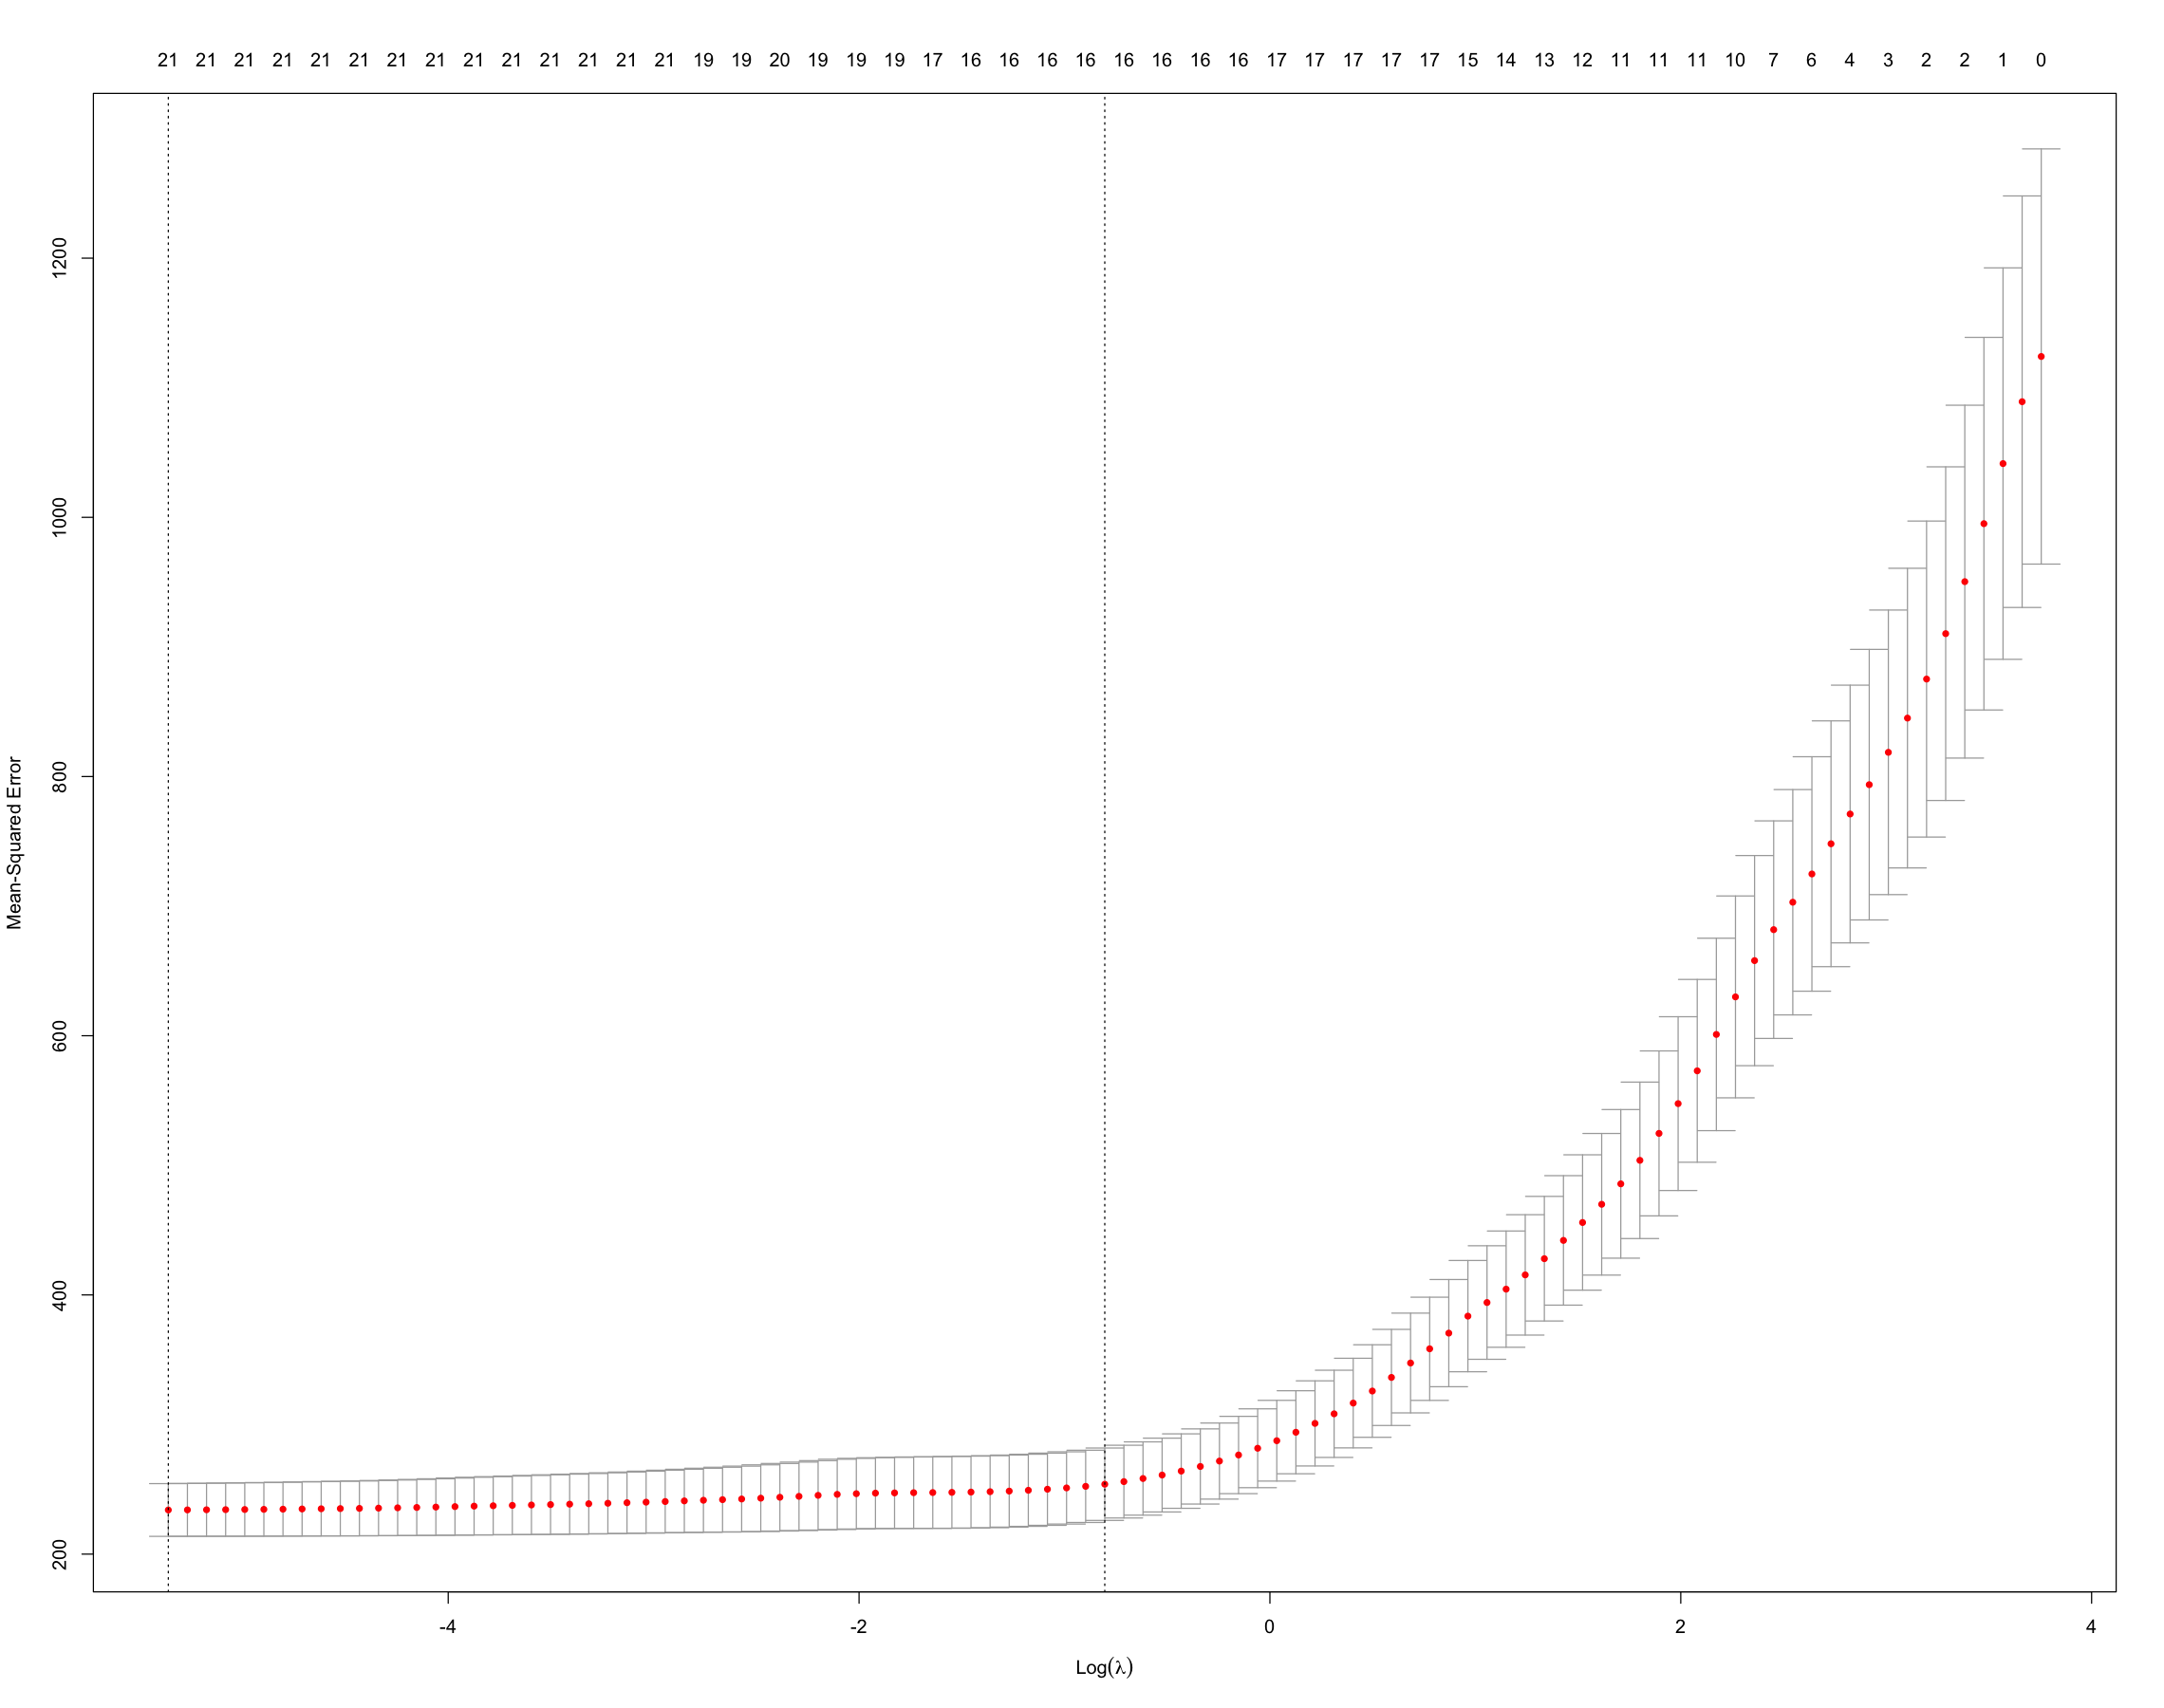

In [76]:
plot(elastic_net_model_cv)

In [11]:
plot(elastic_net_model, xvar = "lambda", label = TRUE)

title(main = "Elastic Net Coefficient Path",
      xlab = expression(log(lambda)),
      ylab = "Coefficient Value")

coef(elastic_net_model_cv, s = "lambda.min")


ERROR: Error: object 'elastic_net_model' not found


In [110]:
best_lambda <- elastic_net_model_cv$lambda.min
coefs <- coef(elastic_net_model, s = best_lambda)

In [ ]:
coef_df <- as.data.frame(as.matrix(coefs))
coef_df$Variable <- rownames(coef_df)
colnames(coef_df)[1] <- "Coefficient"
coef_df <- coef_df %>% filter(Coefficient != 0)

In [ ]:
coef_df <- coef_df %>%
  mutate(Abs_Coefficient = abs(Coefficient)) %>%
  arrange(desc(Abs_Coefficient))

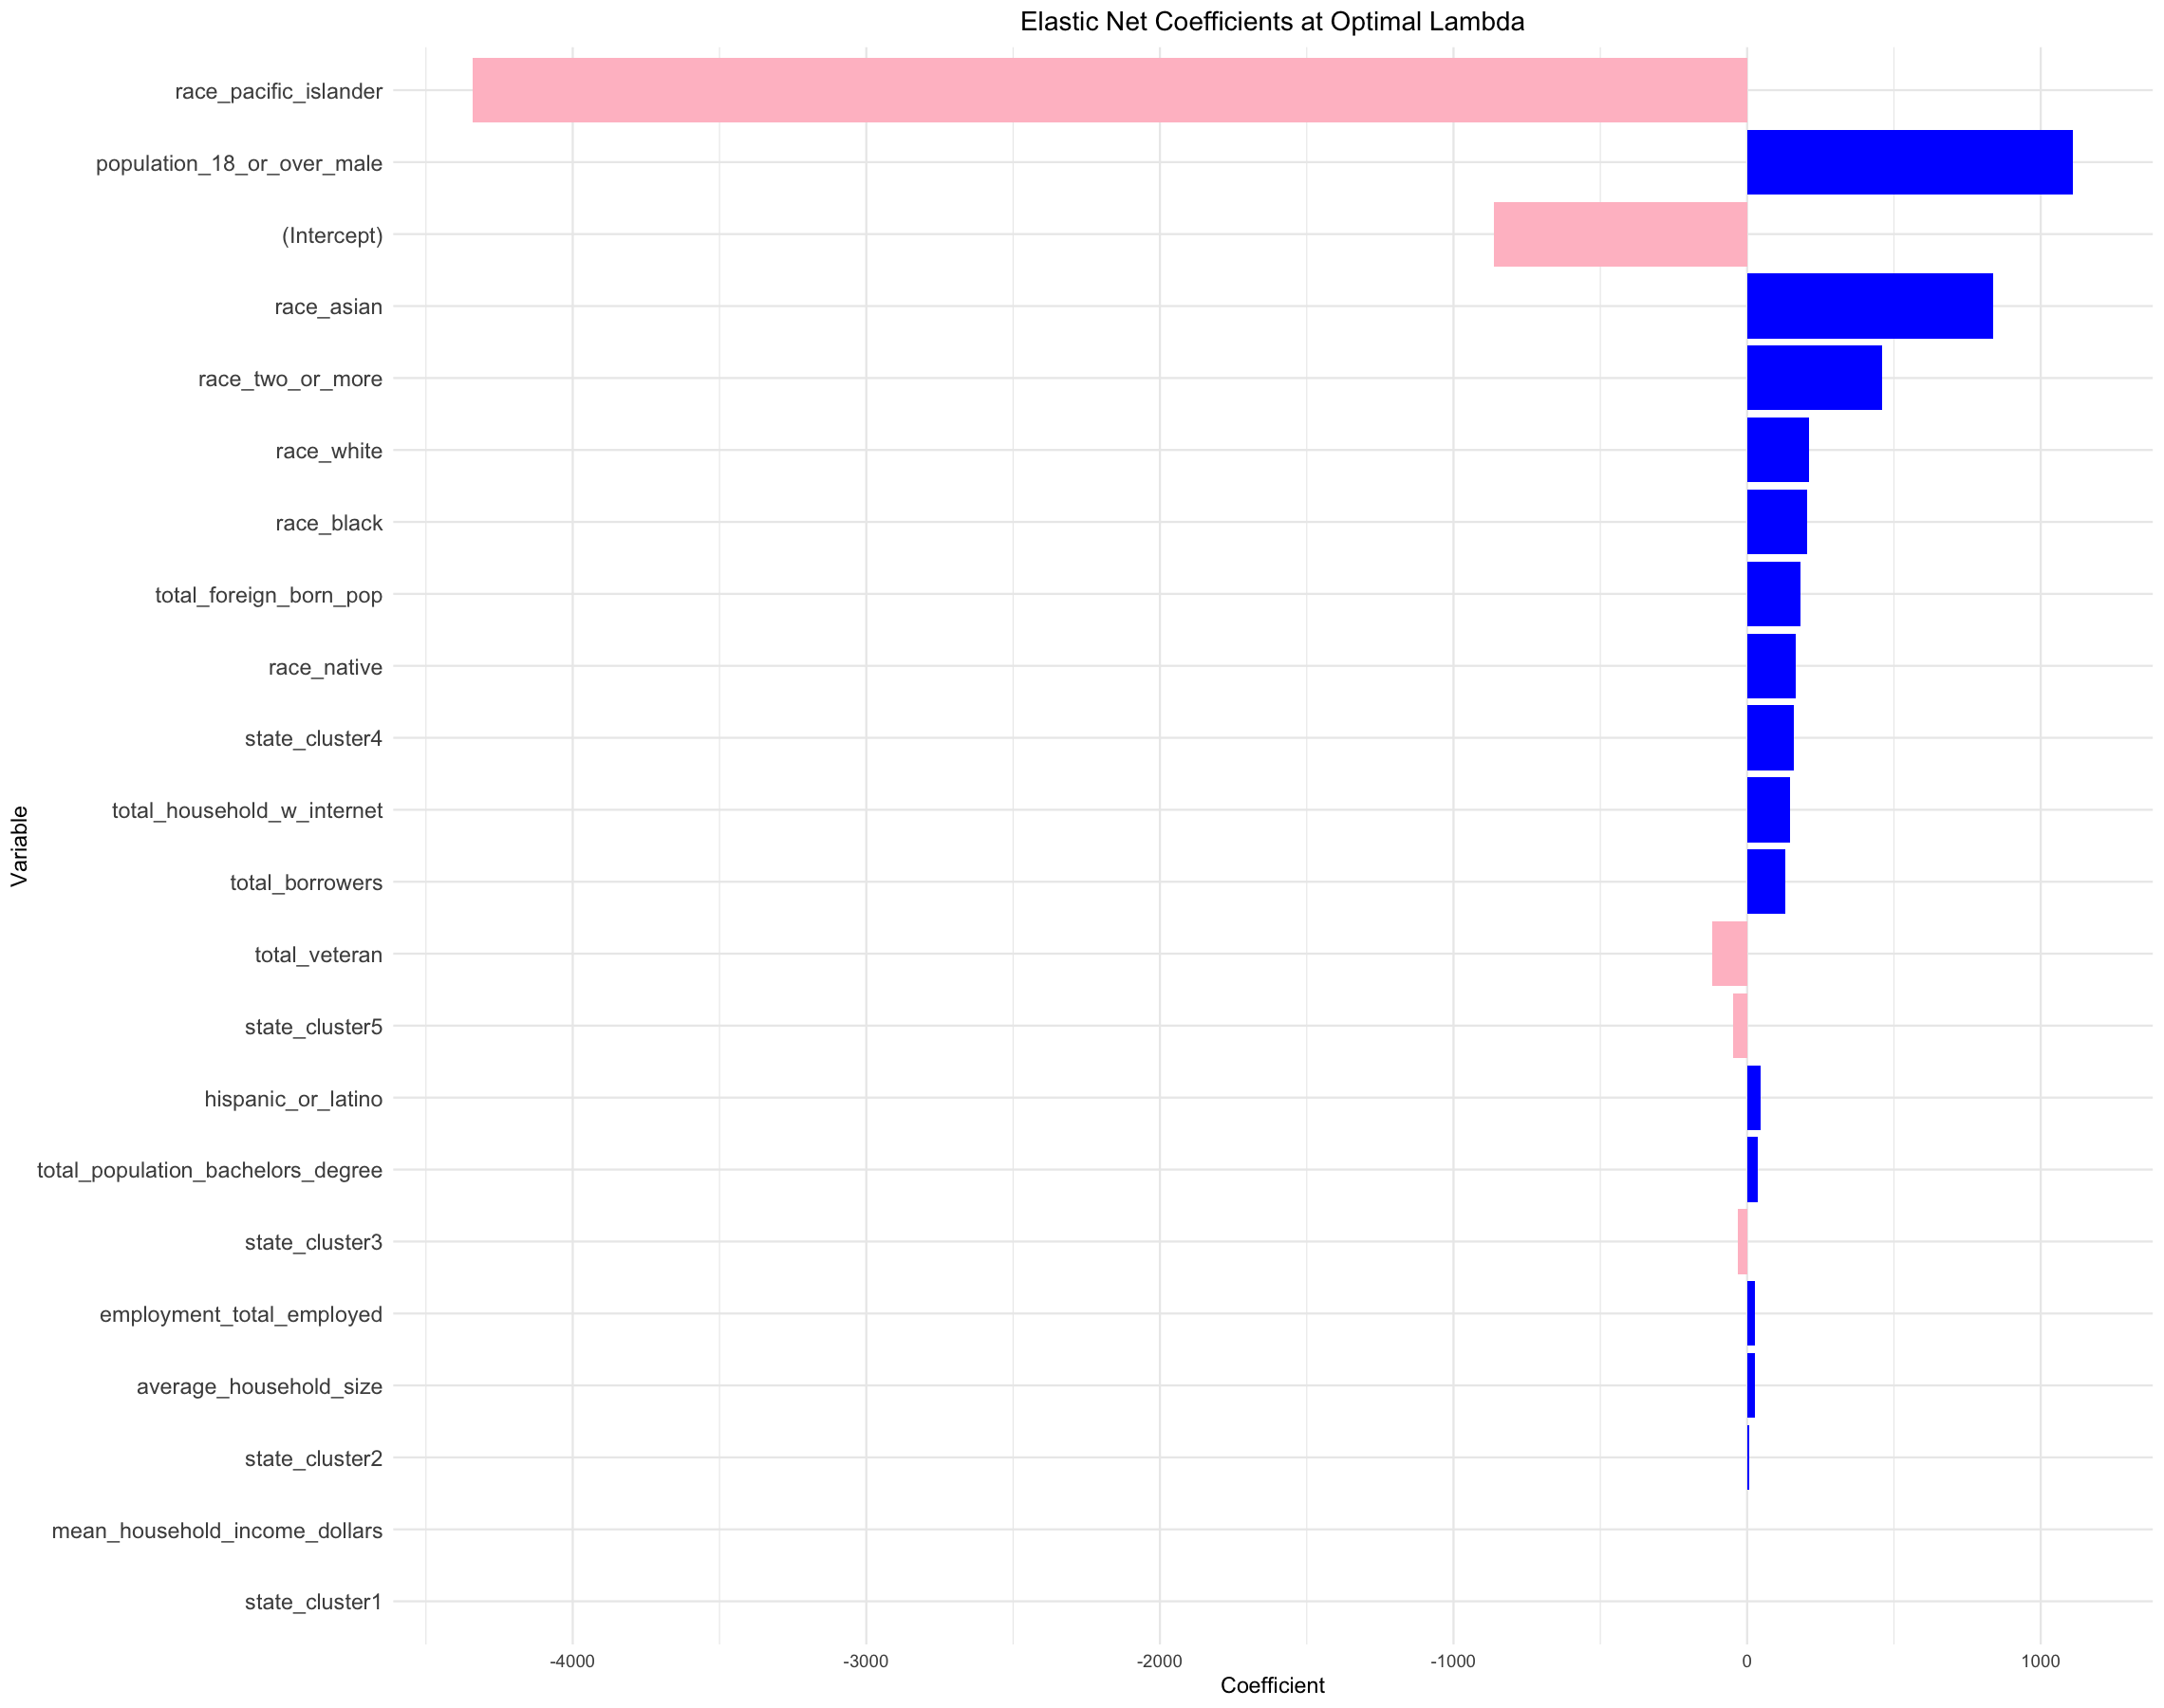

In [113]:
ggplot(coef_df, aes(x = reorder(Variable, Abs_Coefficient), y = Coefficient, fill = Coefficient > 0)) +
  geom_col() +
  coord_flip() +
  labs(
    title = "Elastic Net Coefficients at Optimal Lambda",
    x = "Variable", y = "Coefficient"
  ) +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "pink"), guide = FALSE) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.y = element_text(size = 14), 
    plot.title = element_text(hjust = 0.5)
  )

In [114]:
top_pos <- coef_df[order(-coef_df$Coefficient), ][1:5, ]
top_neg <- coef_df[order(coef_df$Coefficient), ][1:5, ]

print("Top 5 Positive Predictors:")
print(top_pos)

print("Top 5 Negative Predictors:")
print(top_neg)

[1] "Top 5 Positive Predictors:"
                           Coefficient                   Variable
population_18_or_over_male   1109.7908 population_18_or_over_male
race_asian                    837.4522                 race_asian
race_two_or_more              458.1778           race_two_or_more
race_white                    210.0623                 race_white
race_black                    203.4396                 race_black
                           Abs_Coefficient
population_18_or_over_male       1109.7908
race_asian                        837.4522
race_two_or_more                  458.1778
race_white                        210.0623
race_black                        203.4396
[1] "Top 5 Negative Predictors:"
                      Coefficient              Variable Abs_Coefficient
race_pacific_islander -4339.26828 race_pacific_islander      4339.26828
(Intercept)            -861.64373           (Intercept)       861.64373
total_veteran          -118.03448         total_veteran       11

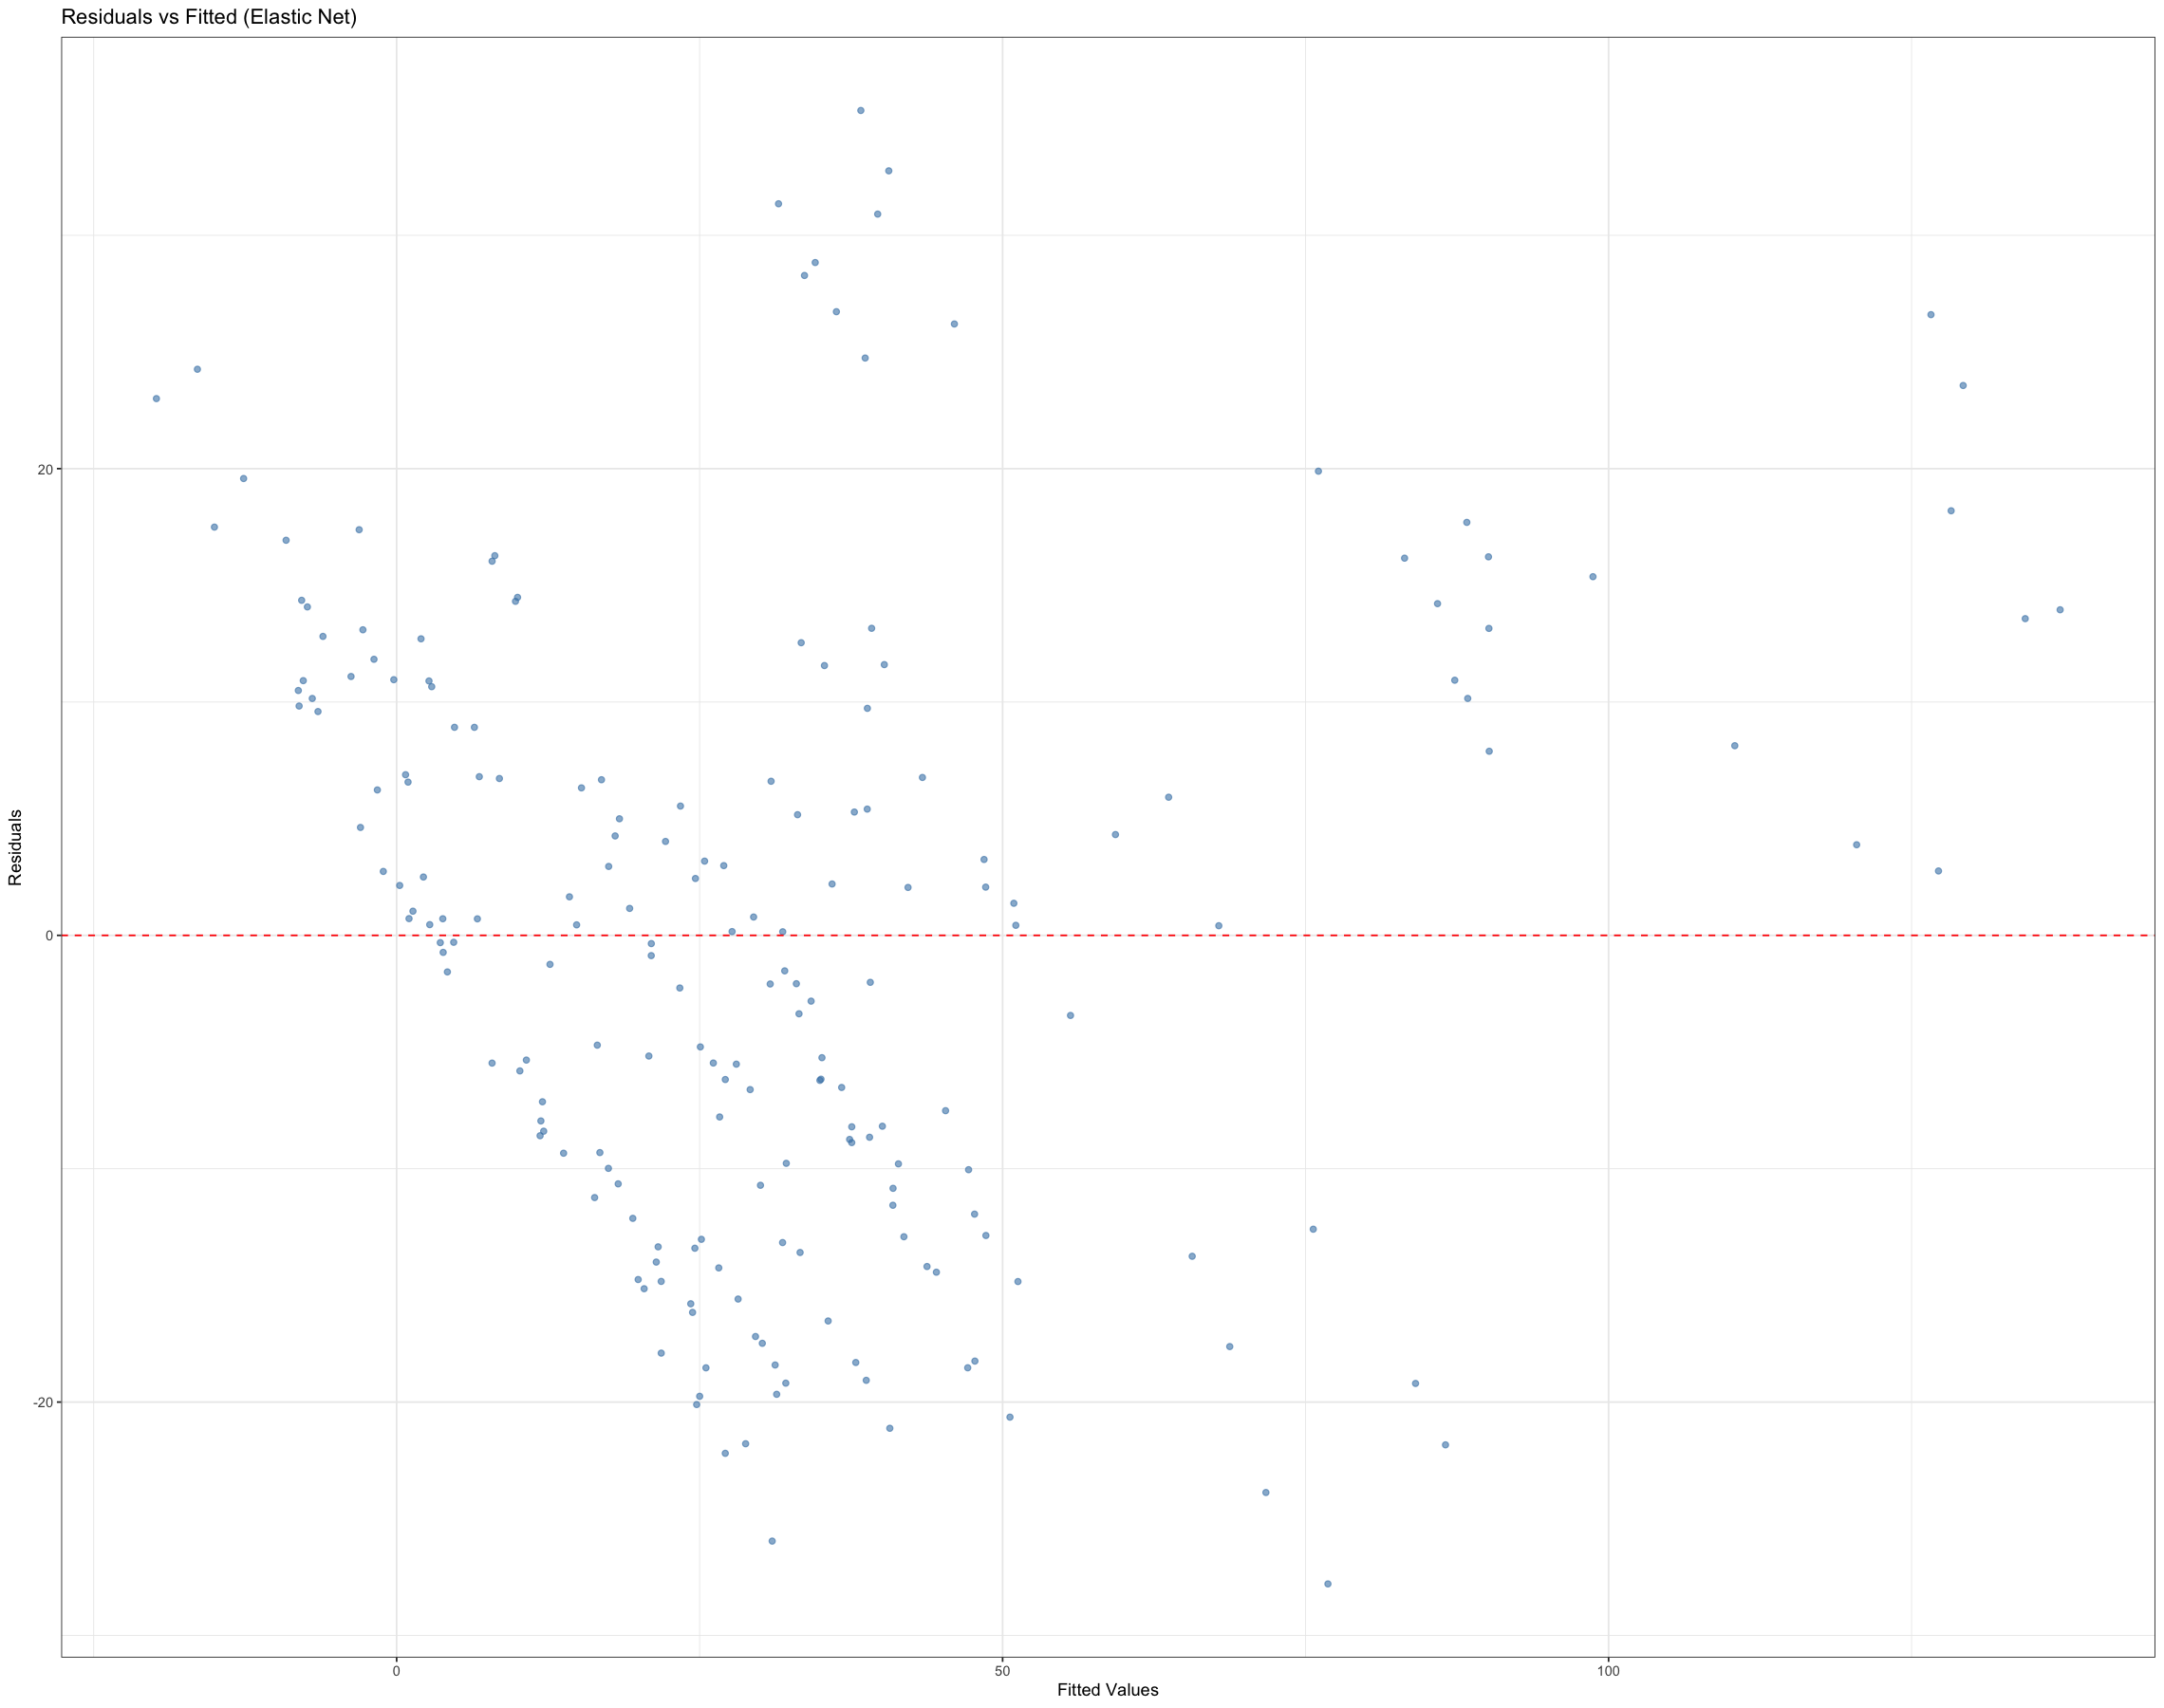

In [80]:
pred <- predict(elastic_net_model_cv, newx = all_var, s = "lambda.min")

resid <- train_data$total_balance_billions - pred

ggplot(data.frame(Fitted = as.numeric(pred), Residuals = as.numeric(resid)), 
       aes(x = Fitted, y = Residuals)) +
  geom_point(color = "steelblue", alpha = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Residuals vs Fitted (Elastic Net)",
    x = "Fitted Values",
    y = "Residuals"
  ) +
  theme_bw()

## Charts for checking assumptions

In [51]:
install.packages("ggfortify")
library(ggfortify)


The downloaded binary packages are in
	/var/folders/fn/64lk1btn1bn0n_6xftkww56c0000gn/T//RtmpLqmSij/downloaded_packages


## For mlr_model

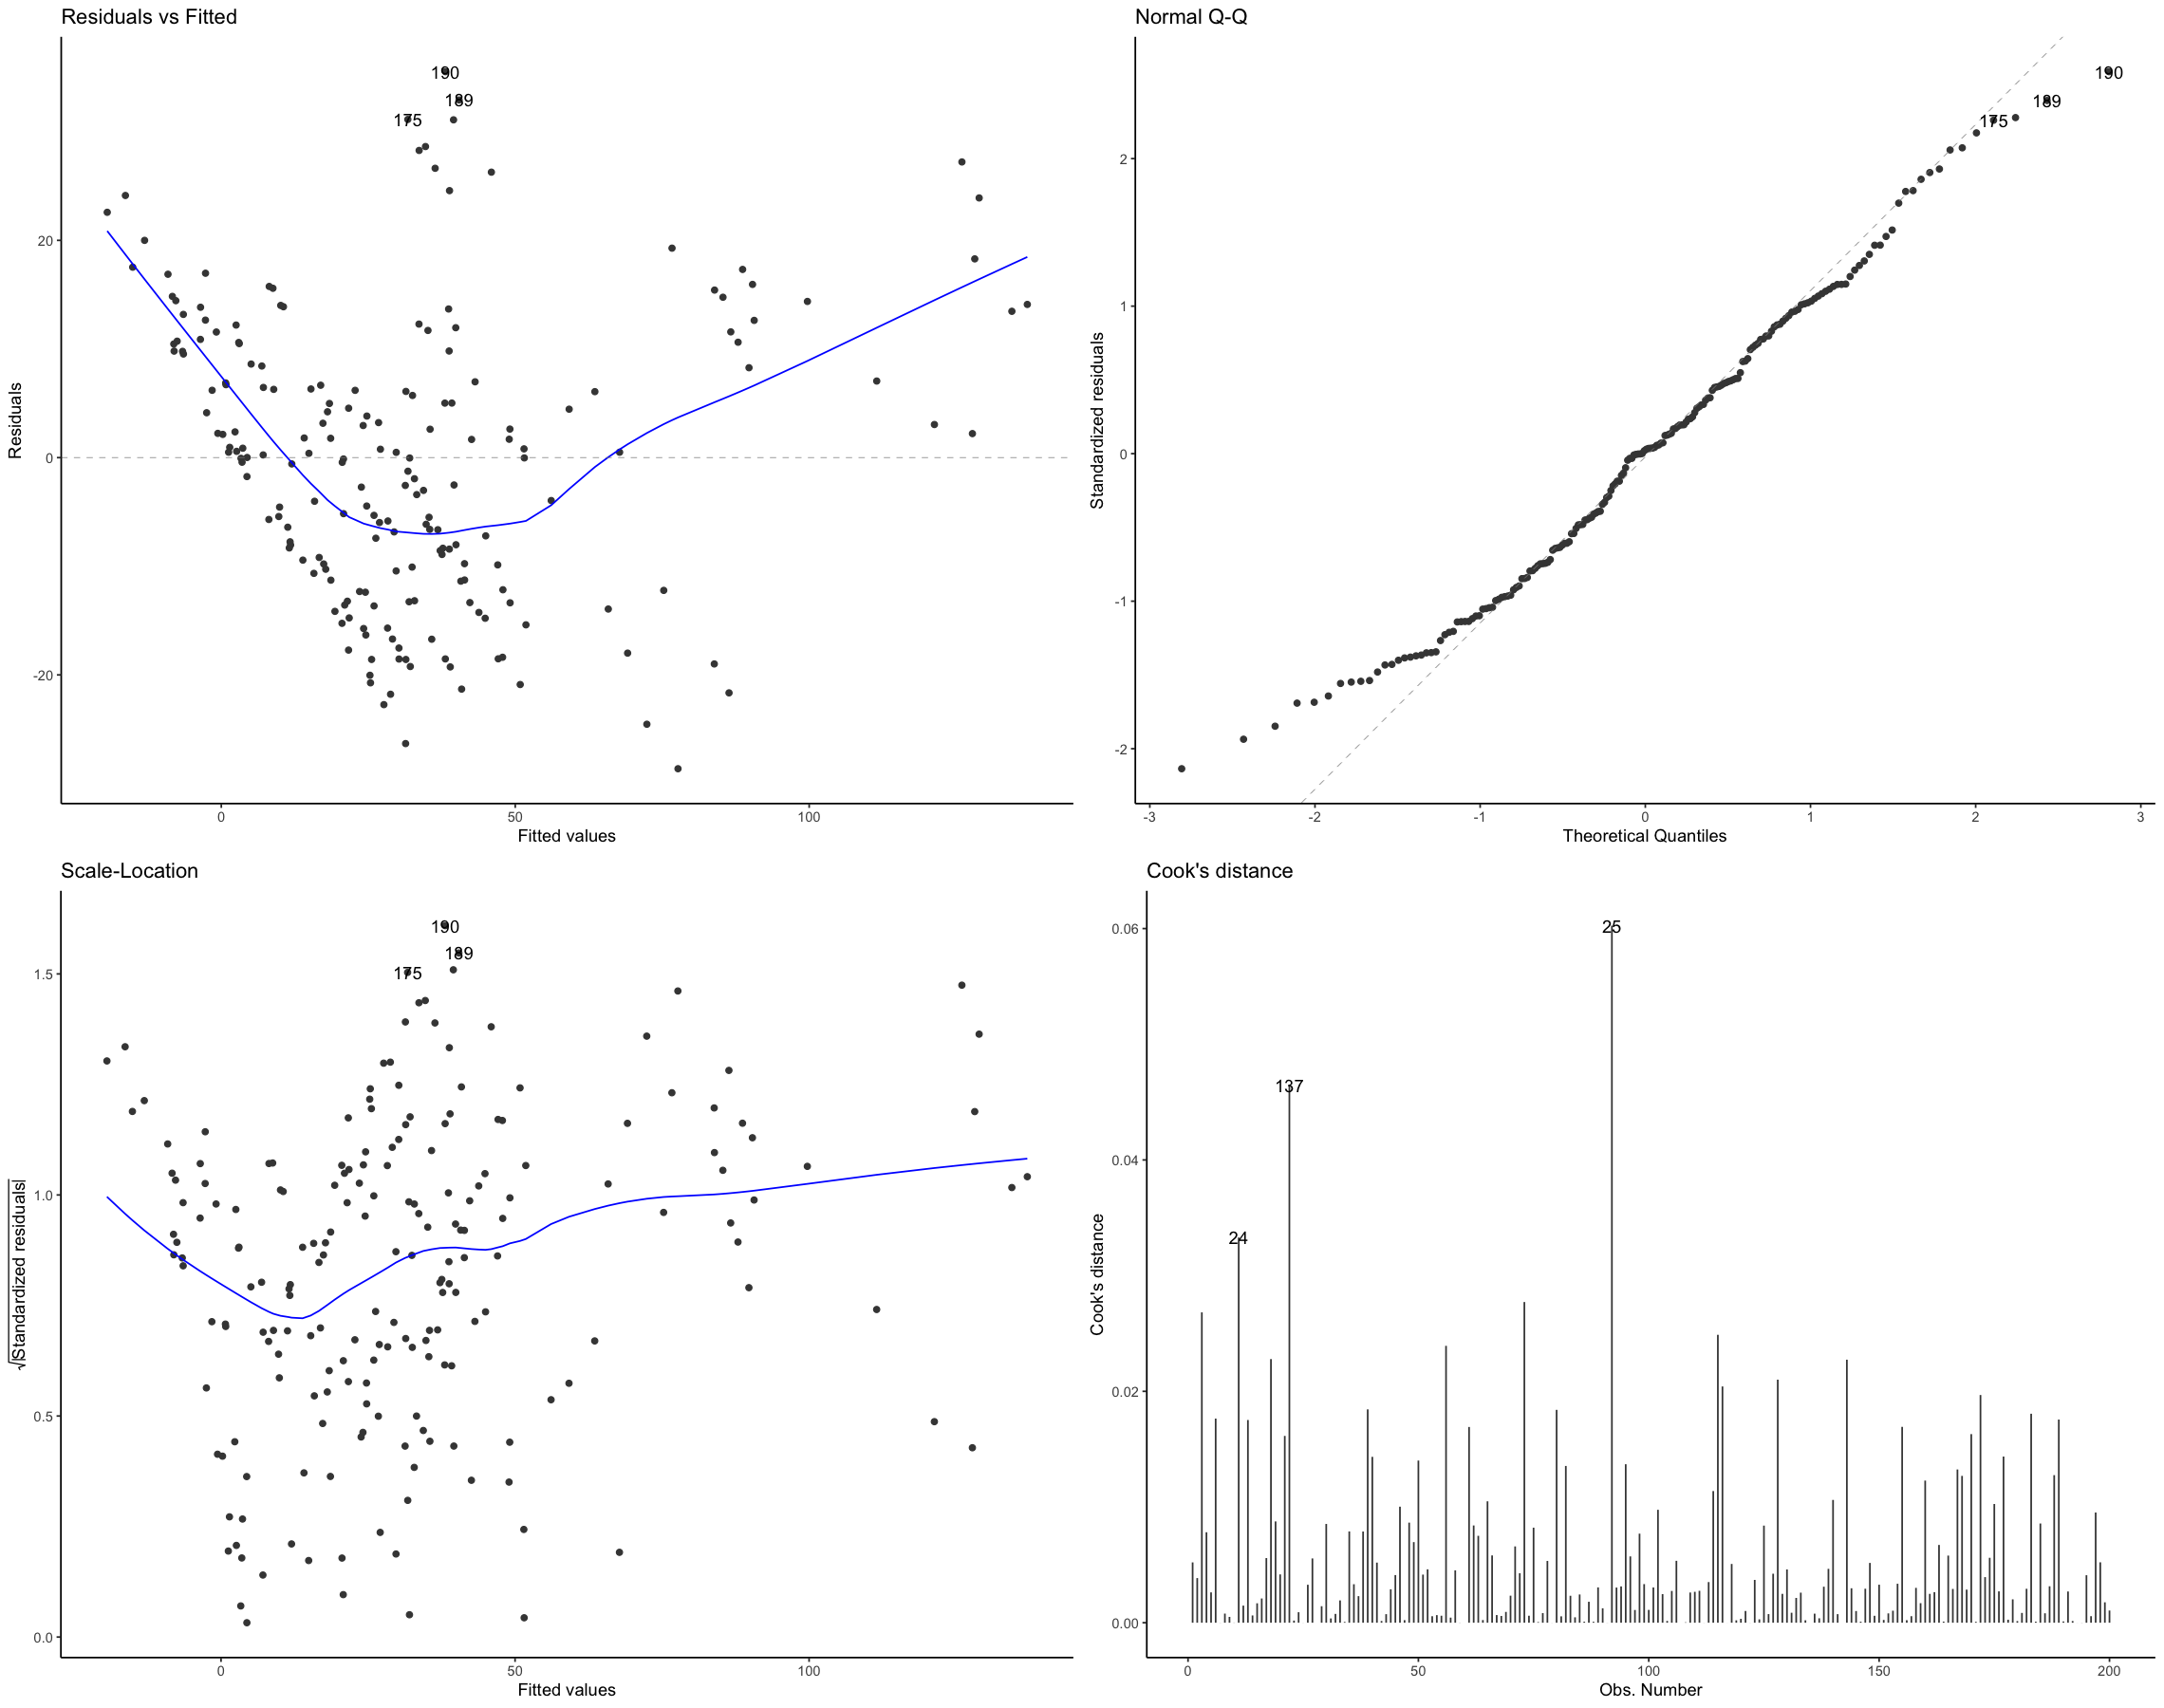

In [57]:
autoplot(mlr_model, which = 1:4) +
  theme_classic()

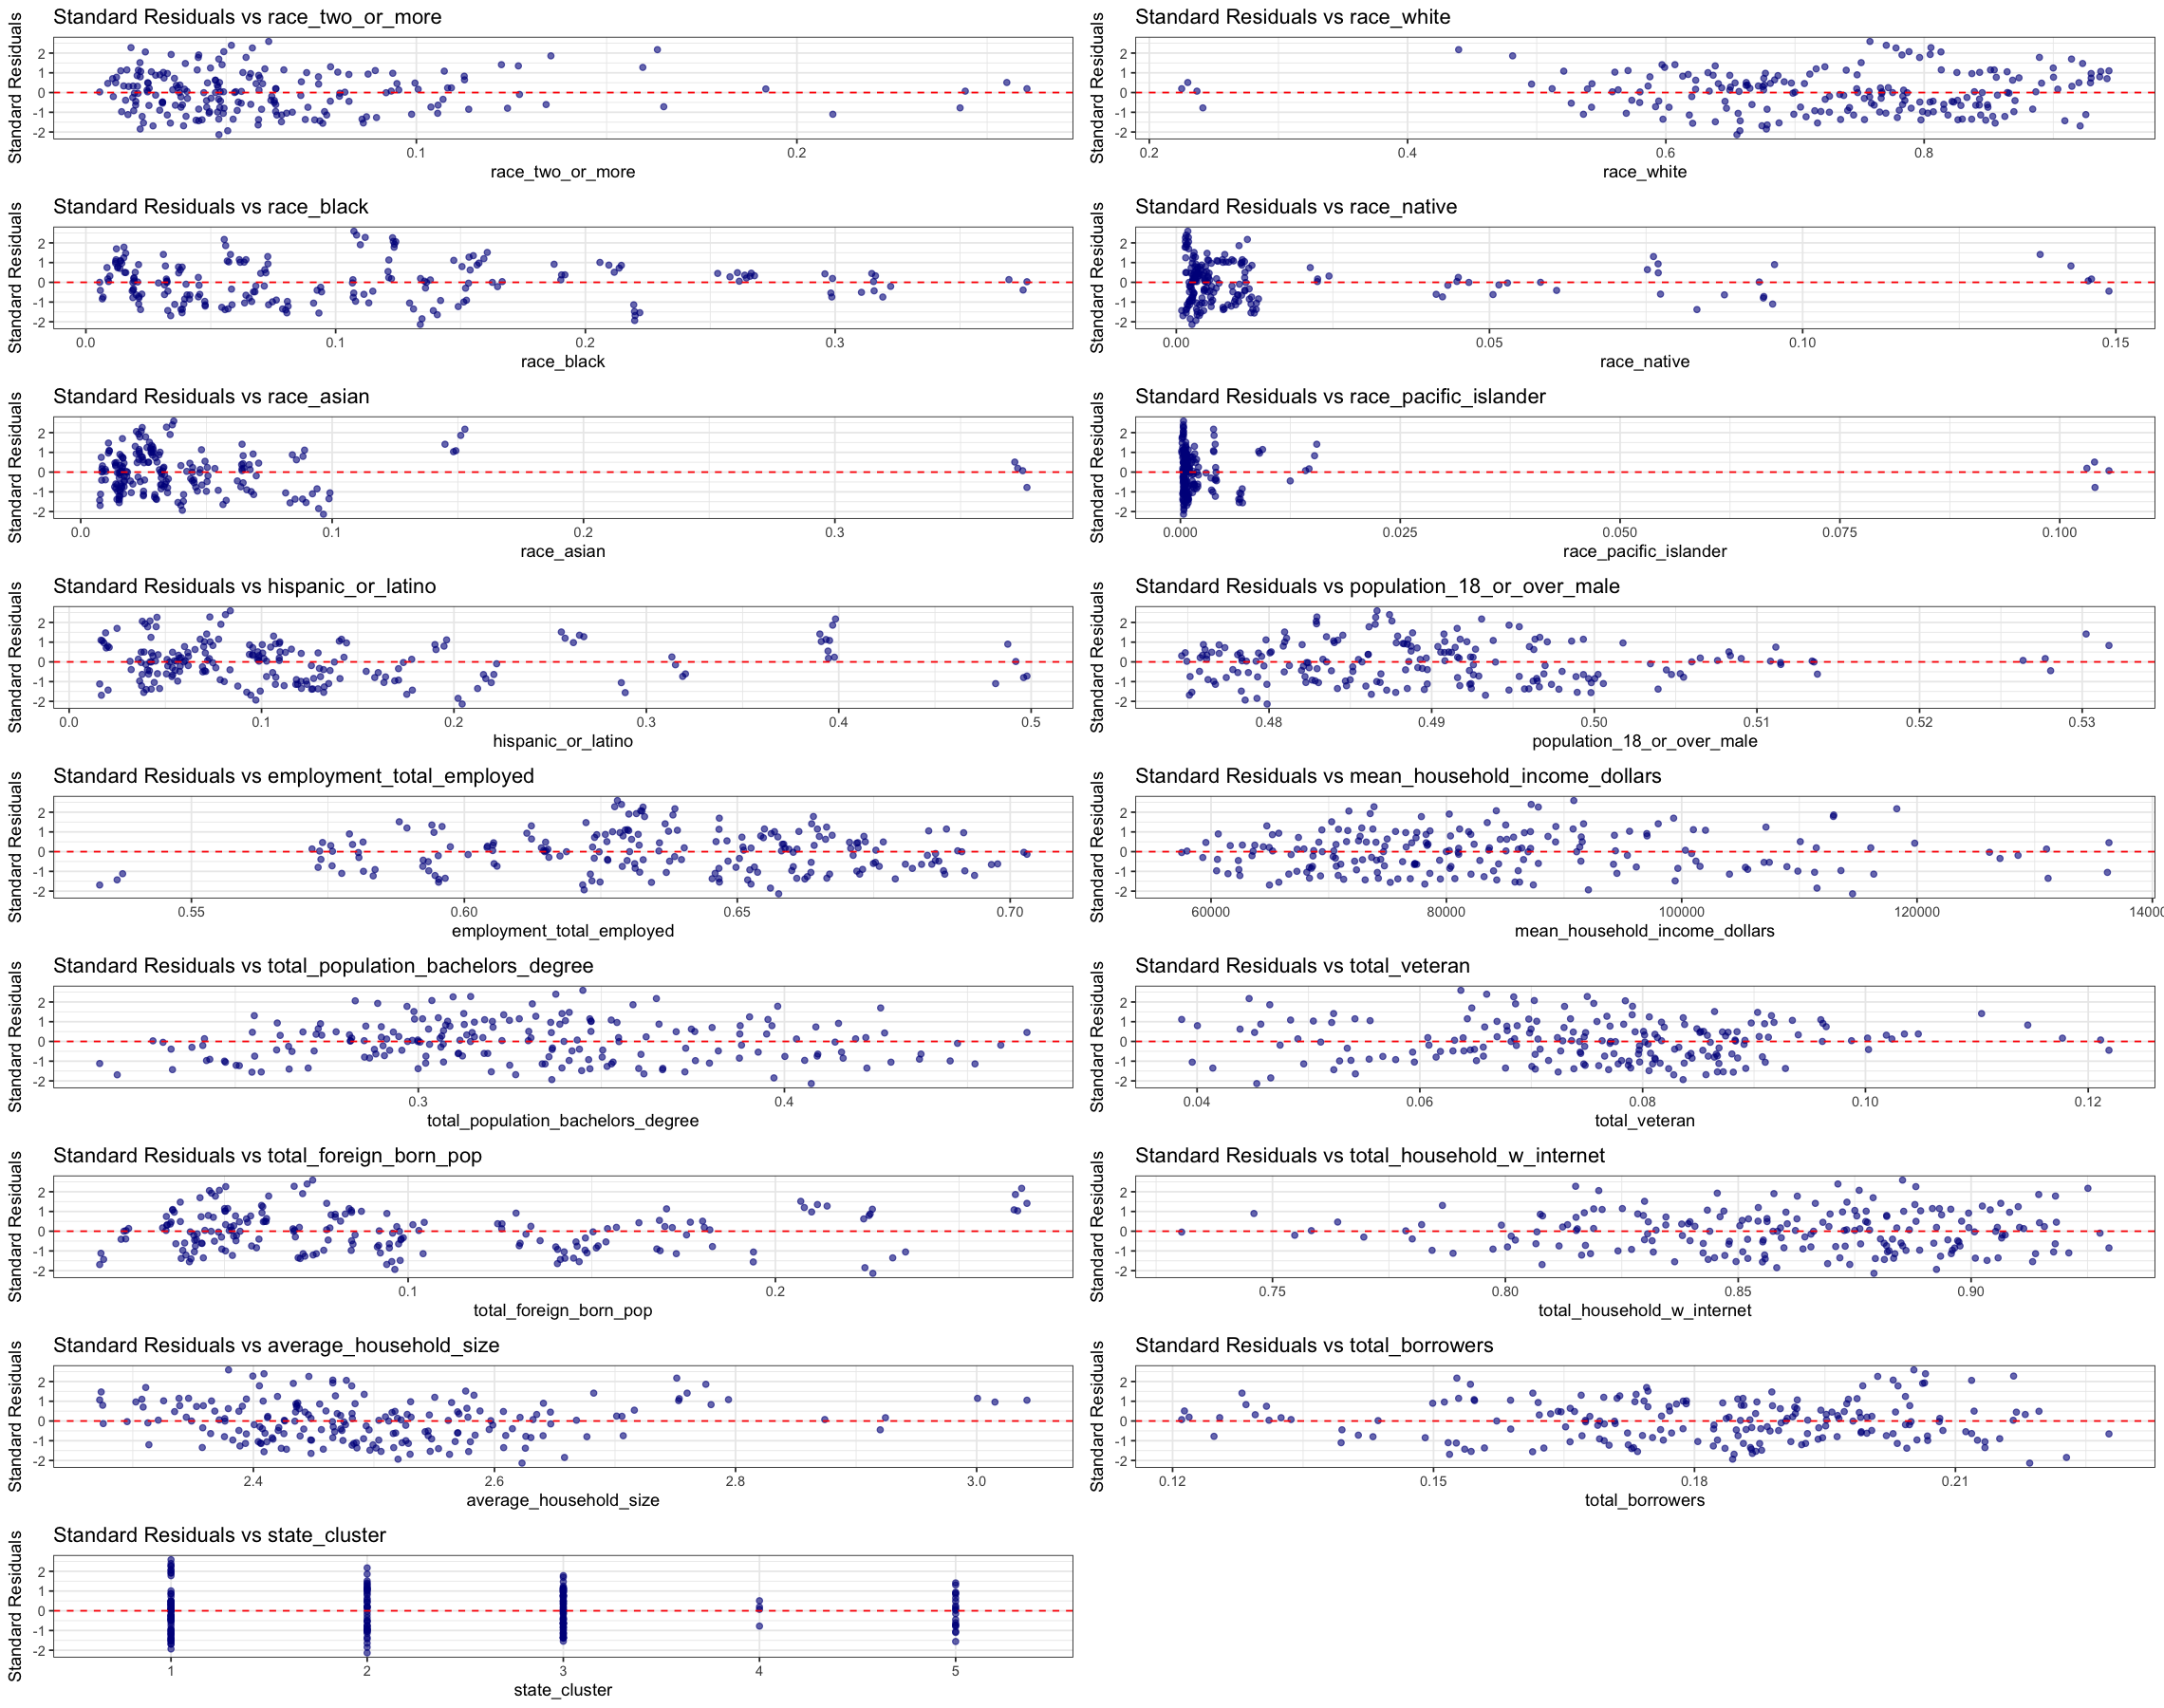

In [67]:
std_resid <- rstandard(mlr_model)
resid <- cbind(train_data, std_resid = std_resid)

predictors <- setdiff(names(train_data), "total_balance_billions")

plots <- lapply(predictors, function(var) {
  ggplot(resid, aes_string(x = var, y = "std_resid")) +
    geom_point(alpha = 0.6, color = "darkblue") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(
      title = paste("Standard Residuals vs", var),
      x = var,
      y = "Standard Residuals"
    ) +
    theme_bw() })

library(gridExtra)

do.call("grid.arrange", c(plots, ncol = 2))


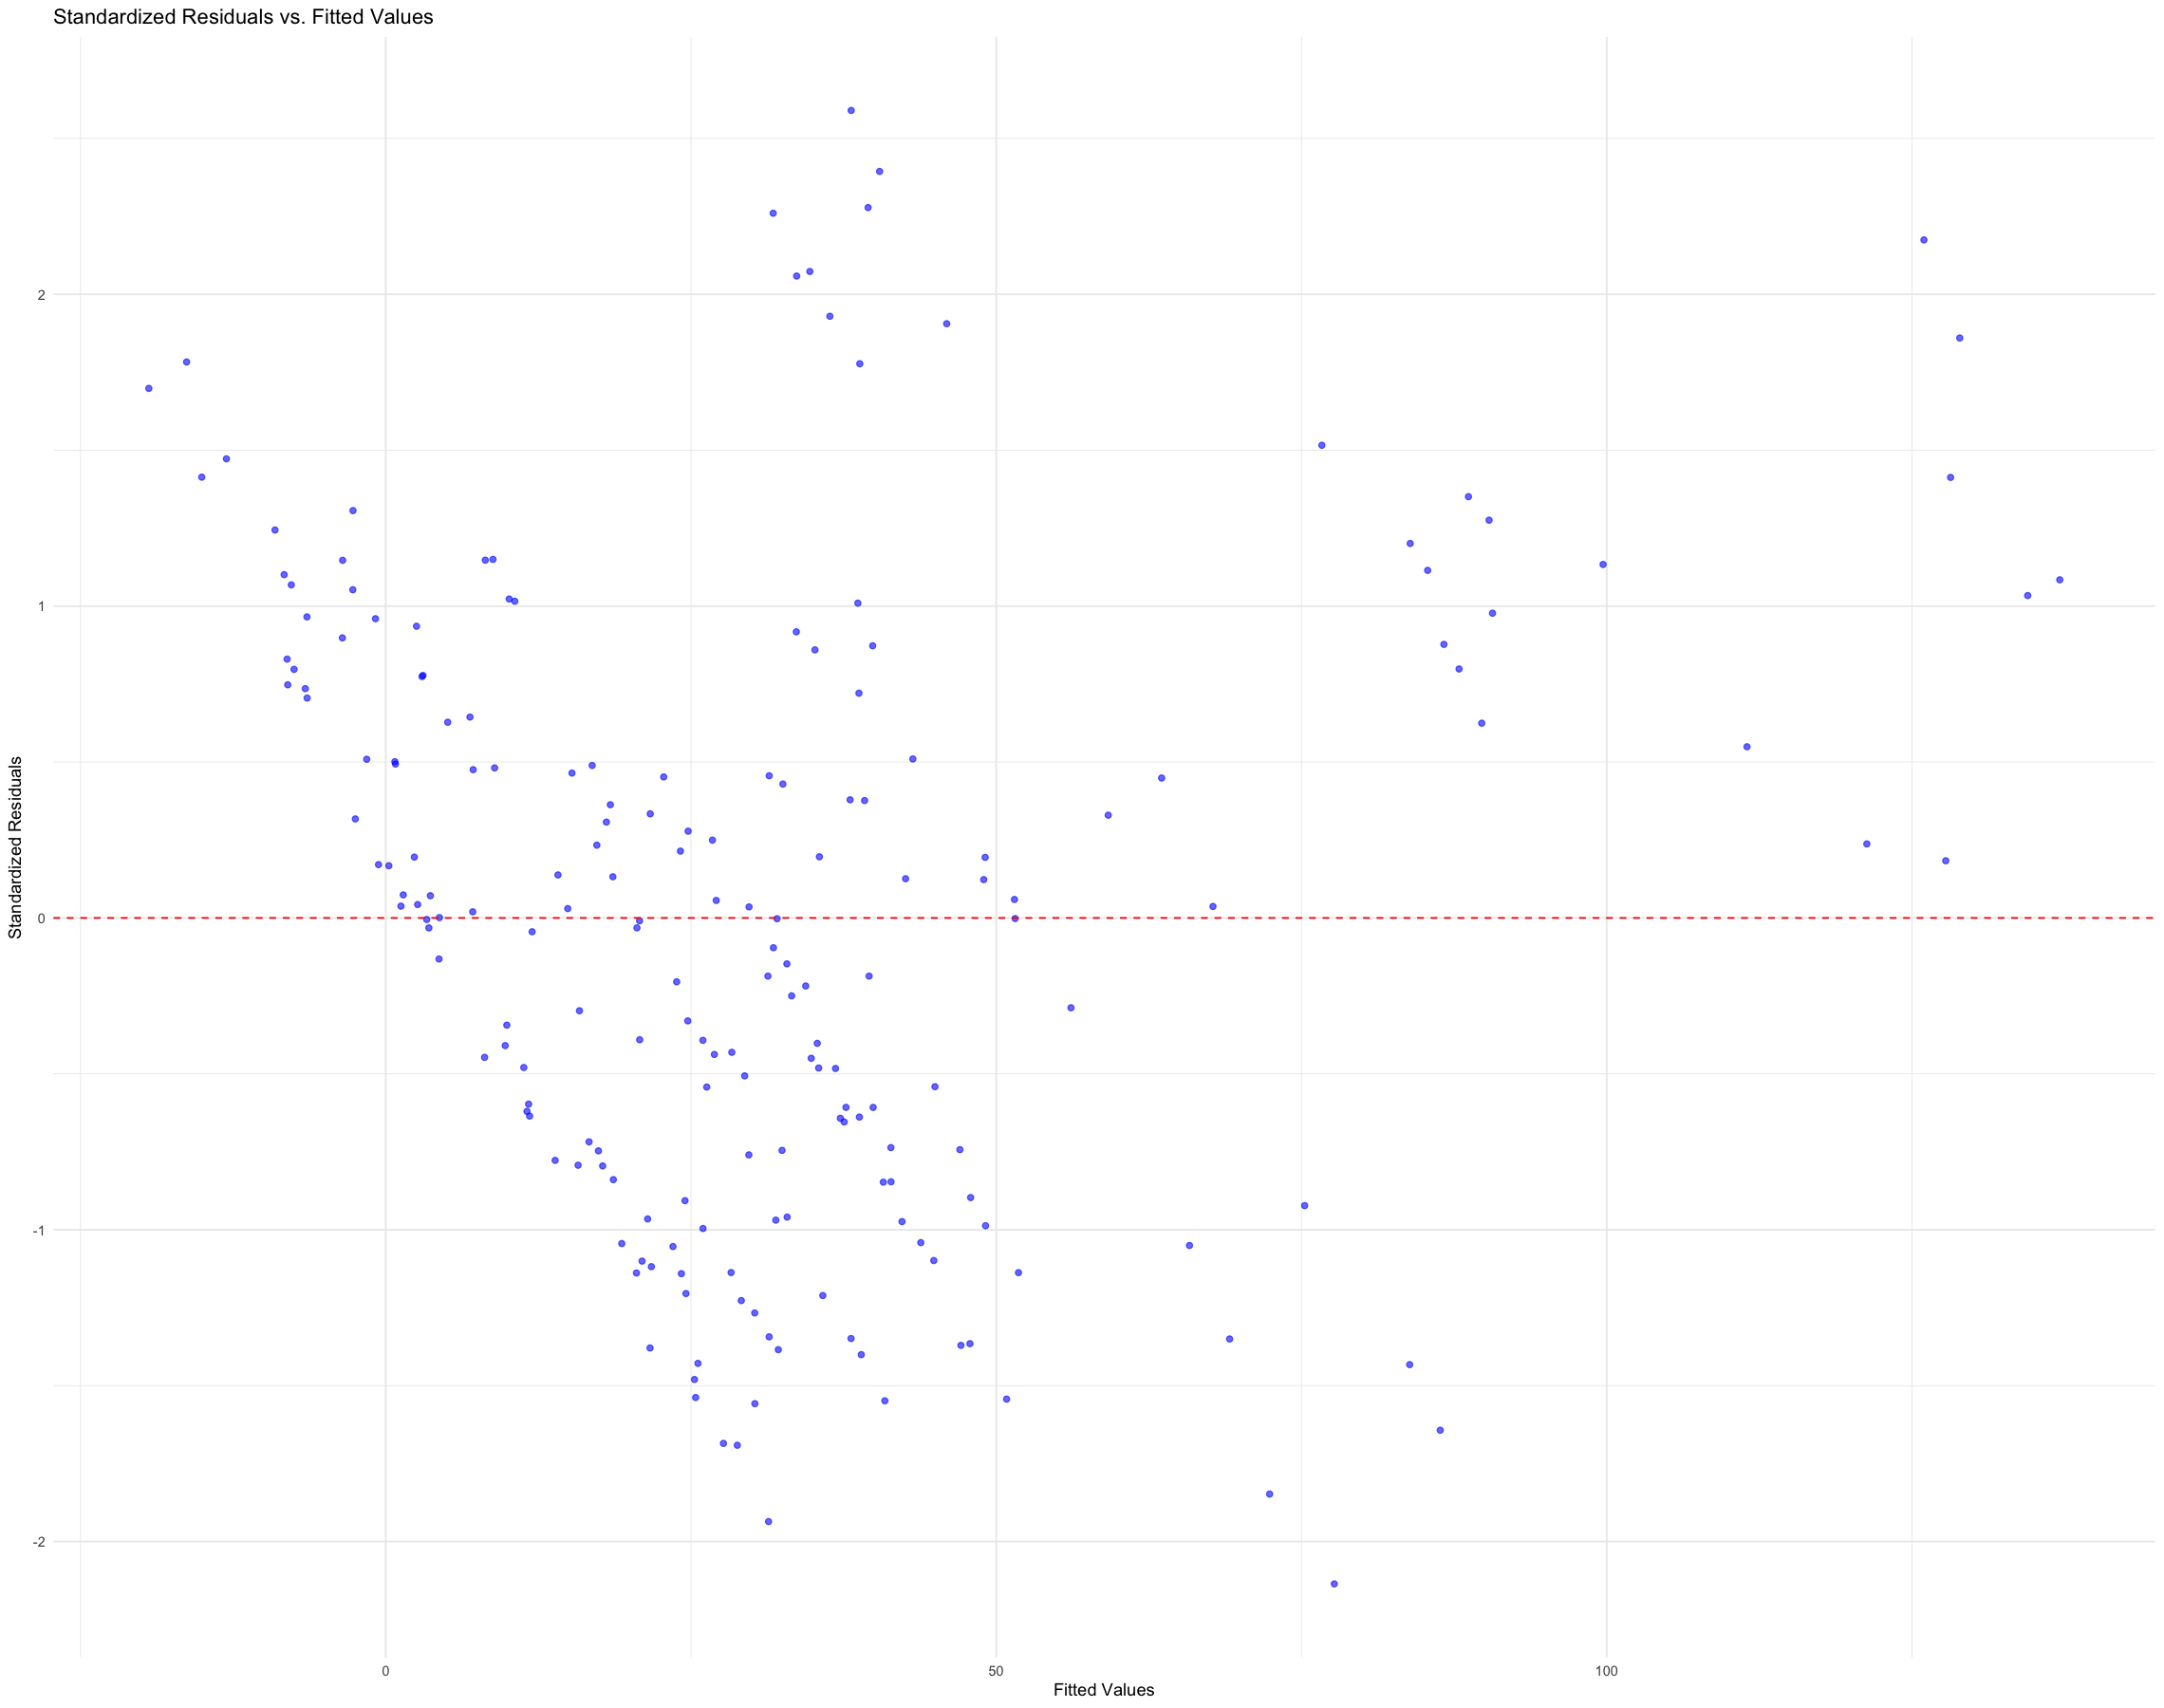

In [69]:
std_resid <- rstandard(mlr_model)
fitted_vals <- fitted(mlr_model)

ggplot(mapping = aes(x = fitted(mlr_model), y = rstandard(mlr_model))) +
  geom_point(alpha = 0.6, color = "blue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Standardized Residuals vs. Fitted Values",
    x = "Fitted Values",
    y = "Standardized Residuals"
  ) +
  theme_minimal()

190 189 
189  95

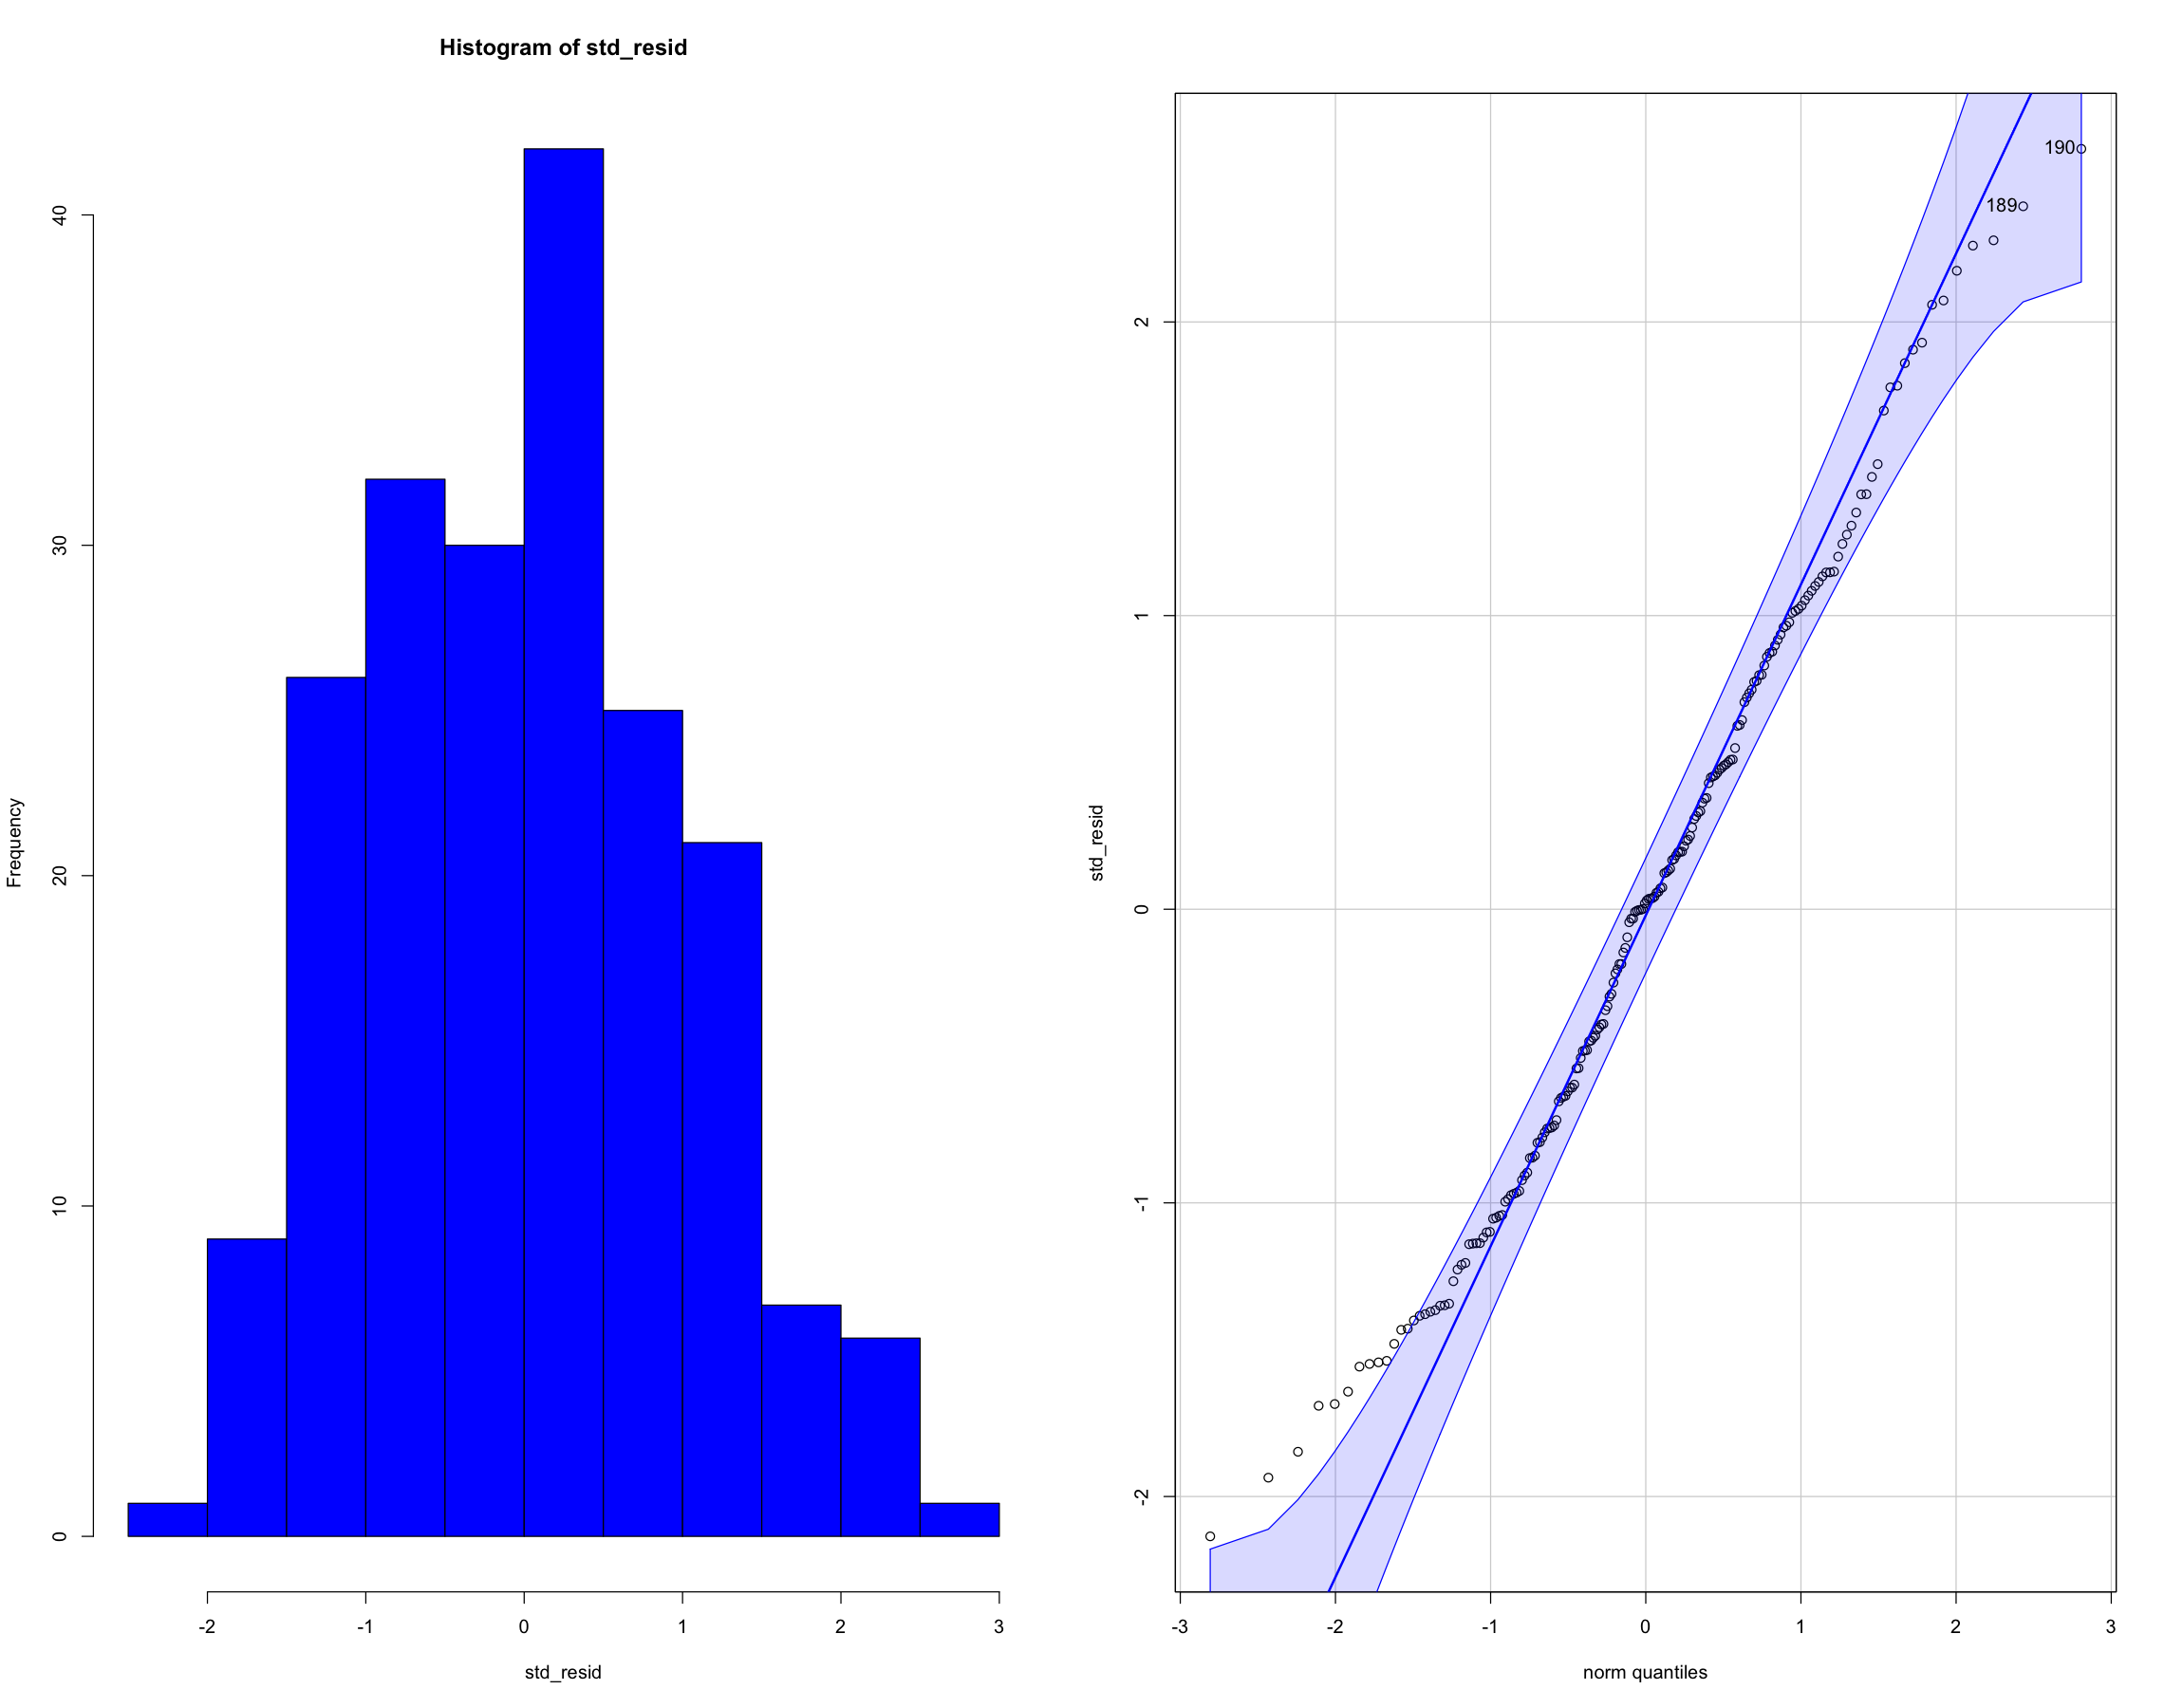

In [70]:
par(mfrow = c(1, 2))
hist(std_resid, col = "blue")
qqPlot(std_resid, envelope = 0.95)

## For mlr_model_cluster

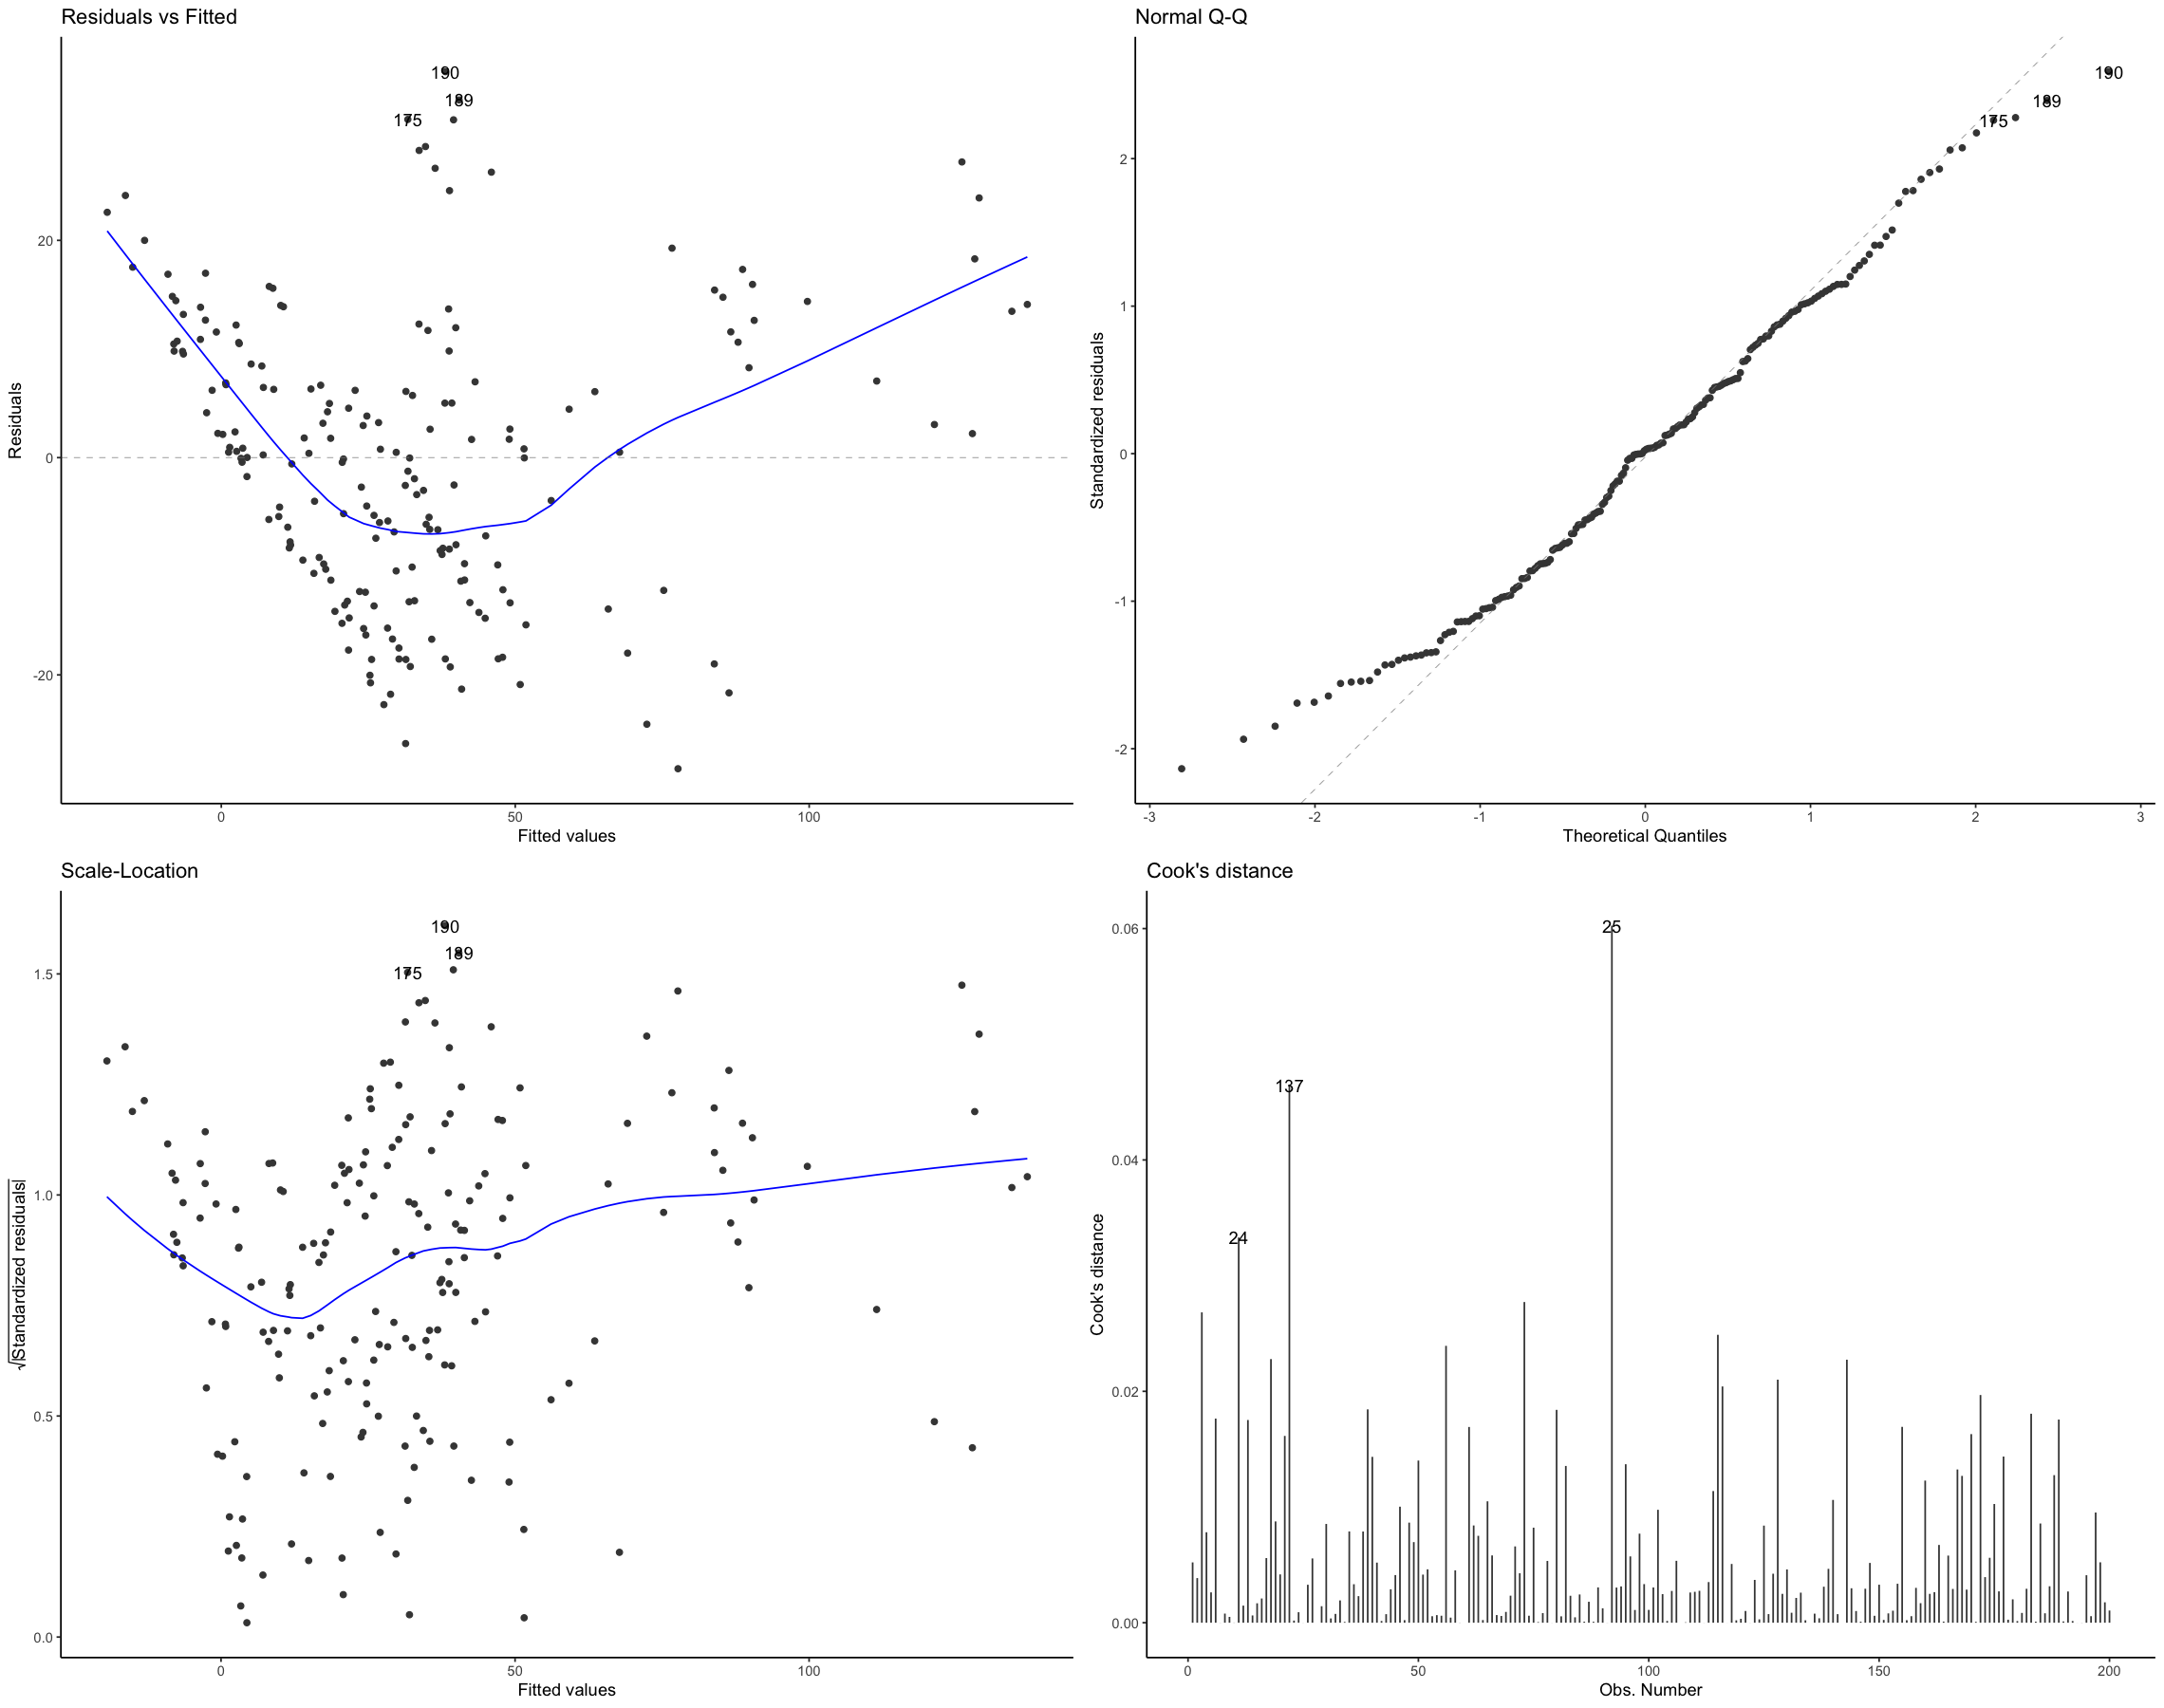

In [71]:
autoplot(mlr_model_cluster, which = 1:4) +
  theme_classic()

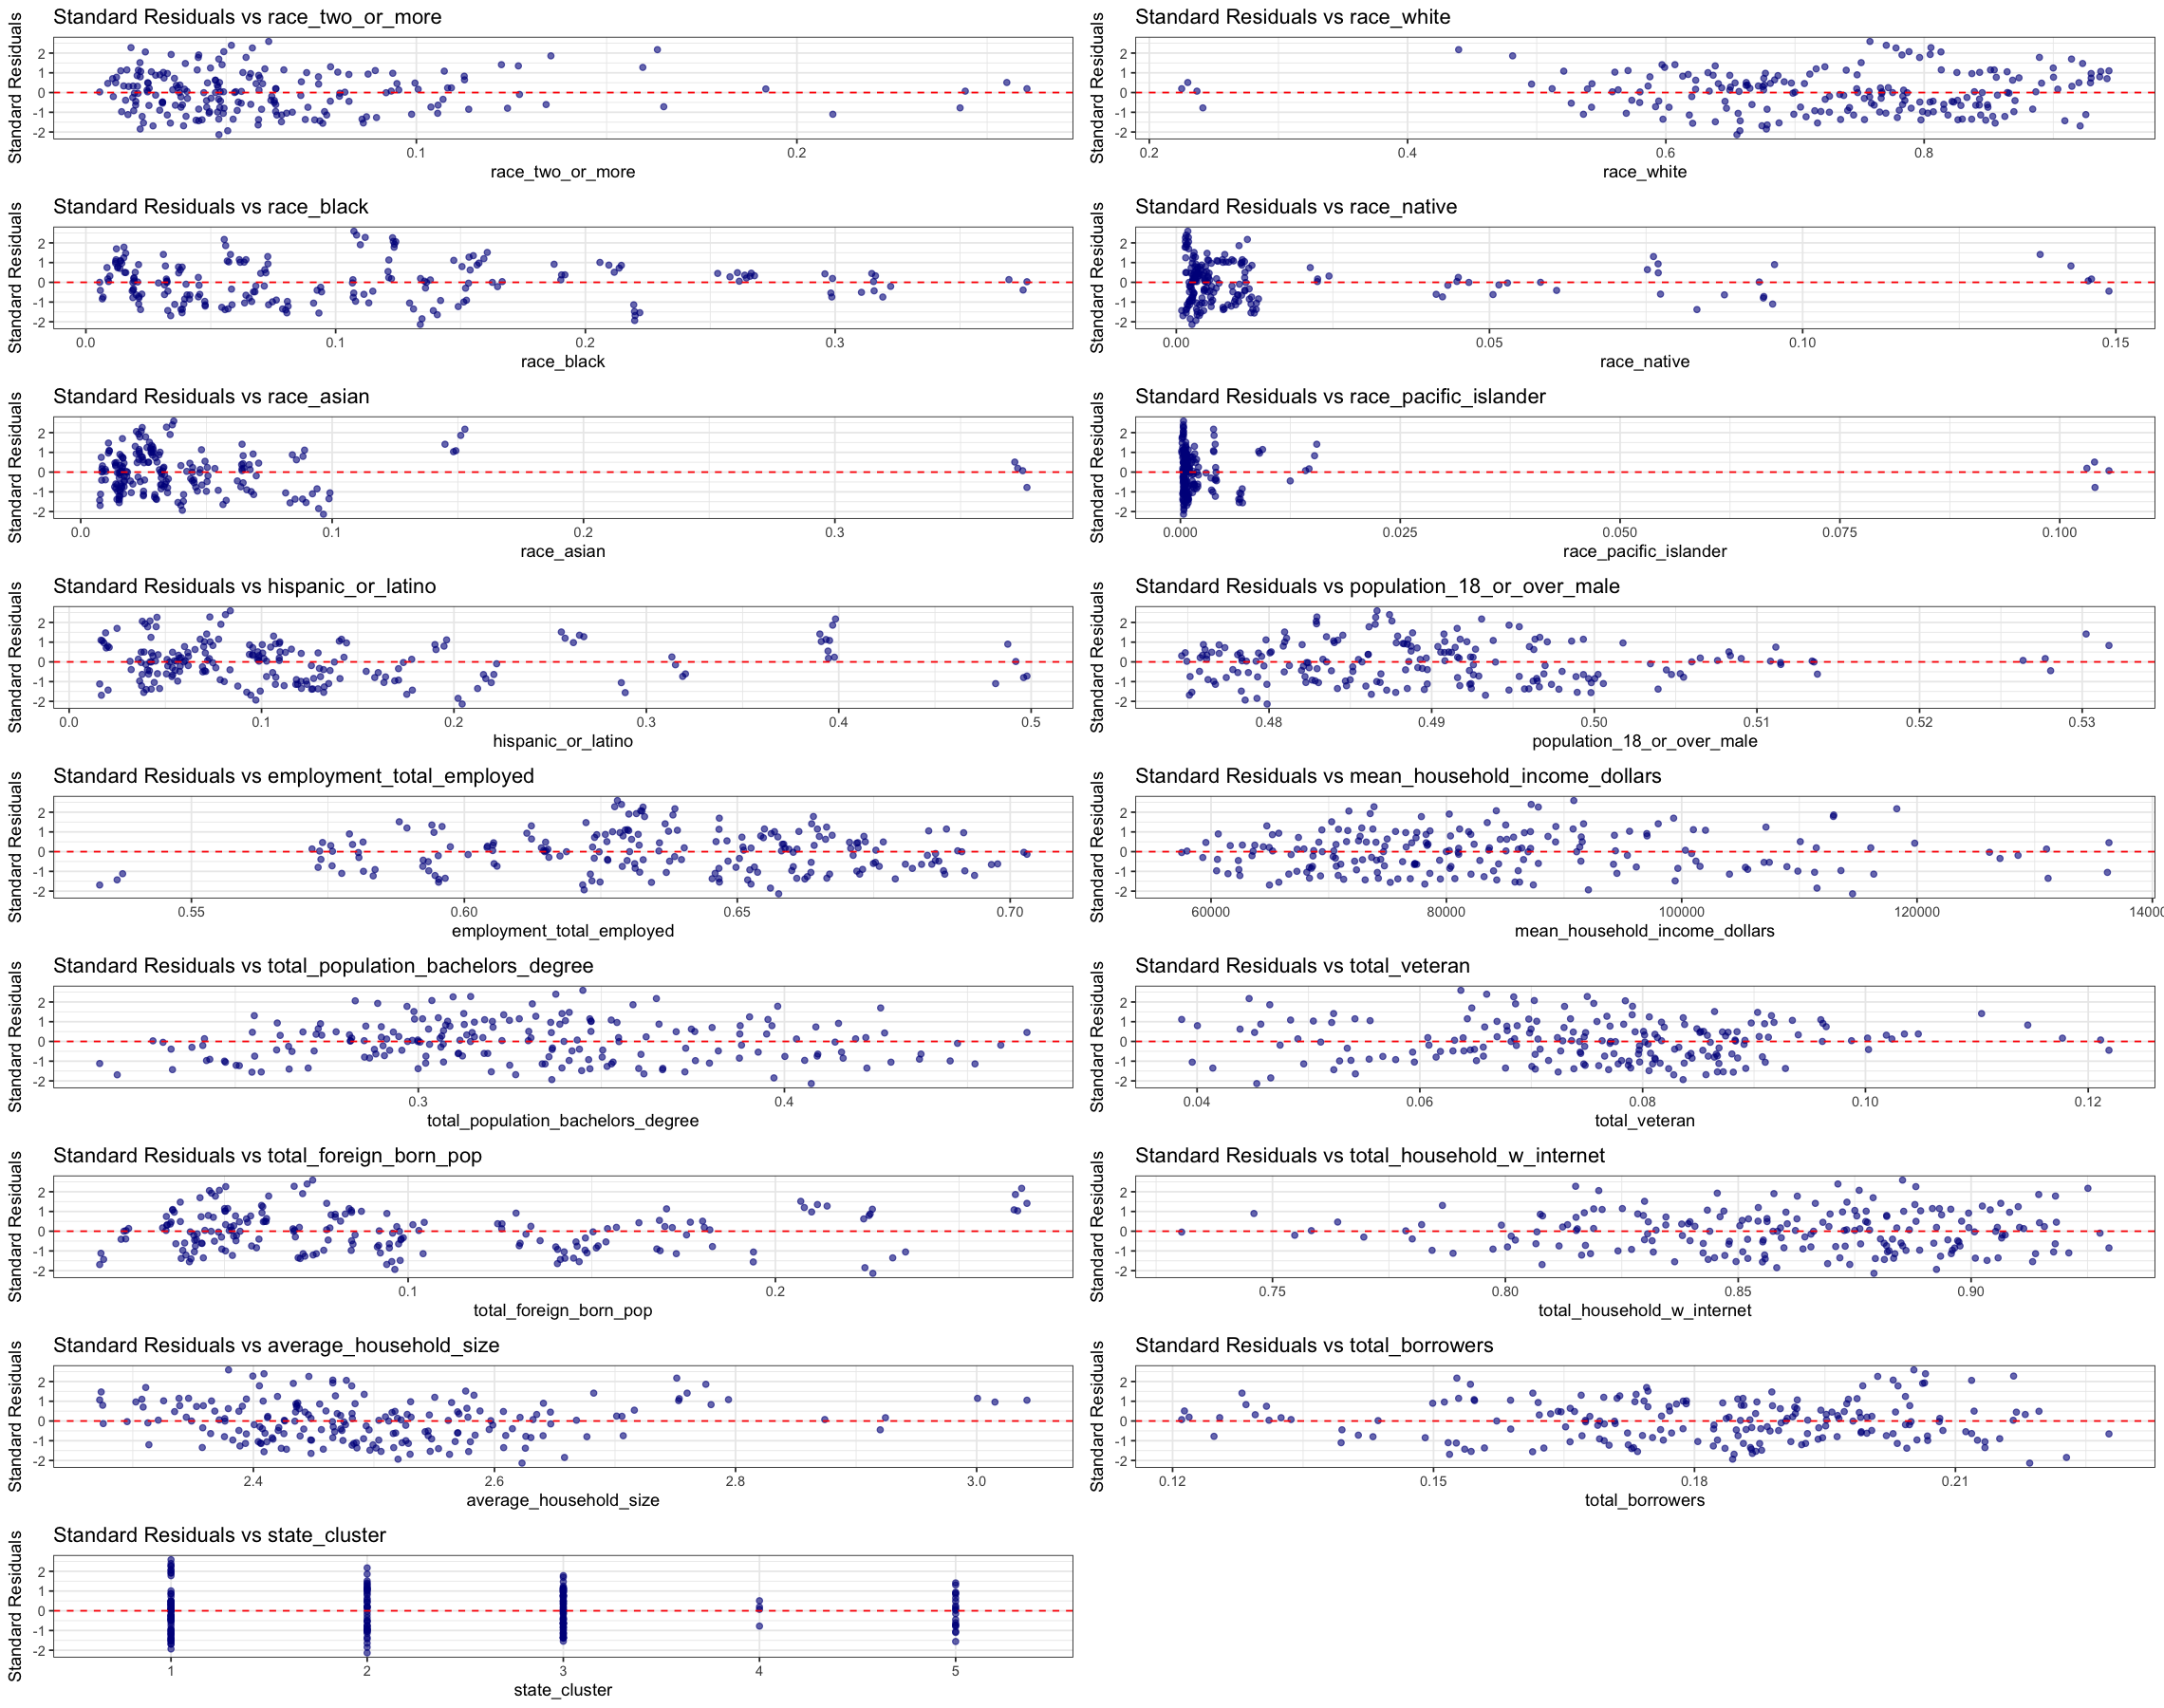

In [72]:
std_resid <- rstandard(mlr_model_cluster)
resid <- cbind(train_data, std_resid = std_resid)

predictors <- setdiff(names(train_data), "total_balance_billions")

plots <- lapply(predictors, function(var) {
  ggplot(resid, aes_string(x = var, y = "std_resid")) +
    geom_point(alpha = 0.6, color = "darkblue") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(
      title = paste("Standard Residuals vs", var),
      x = var,
      y = "Standard Residuals"
    ) +
    theme_bw() })

library(gridExtra)

do.call("grid.arrange", c(plots, ncol = 2))

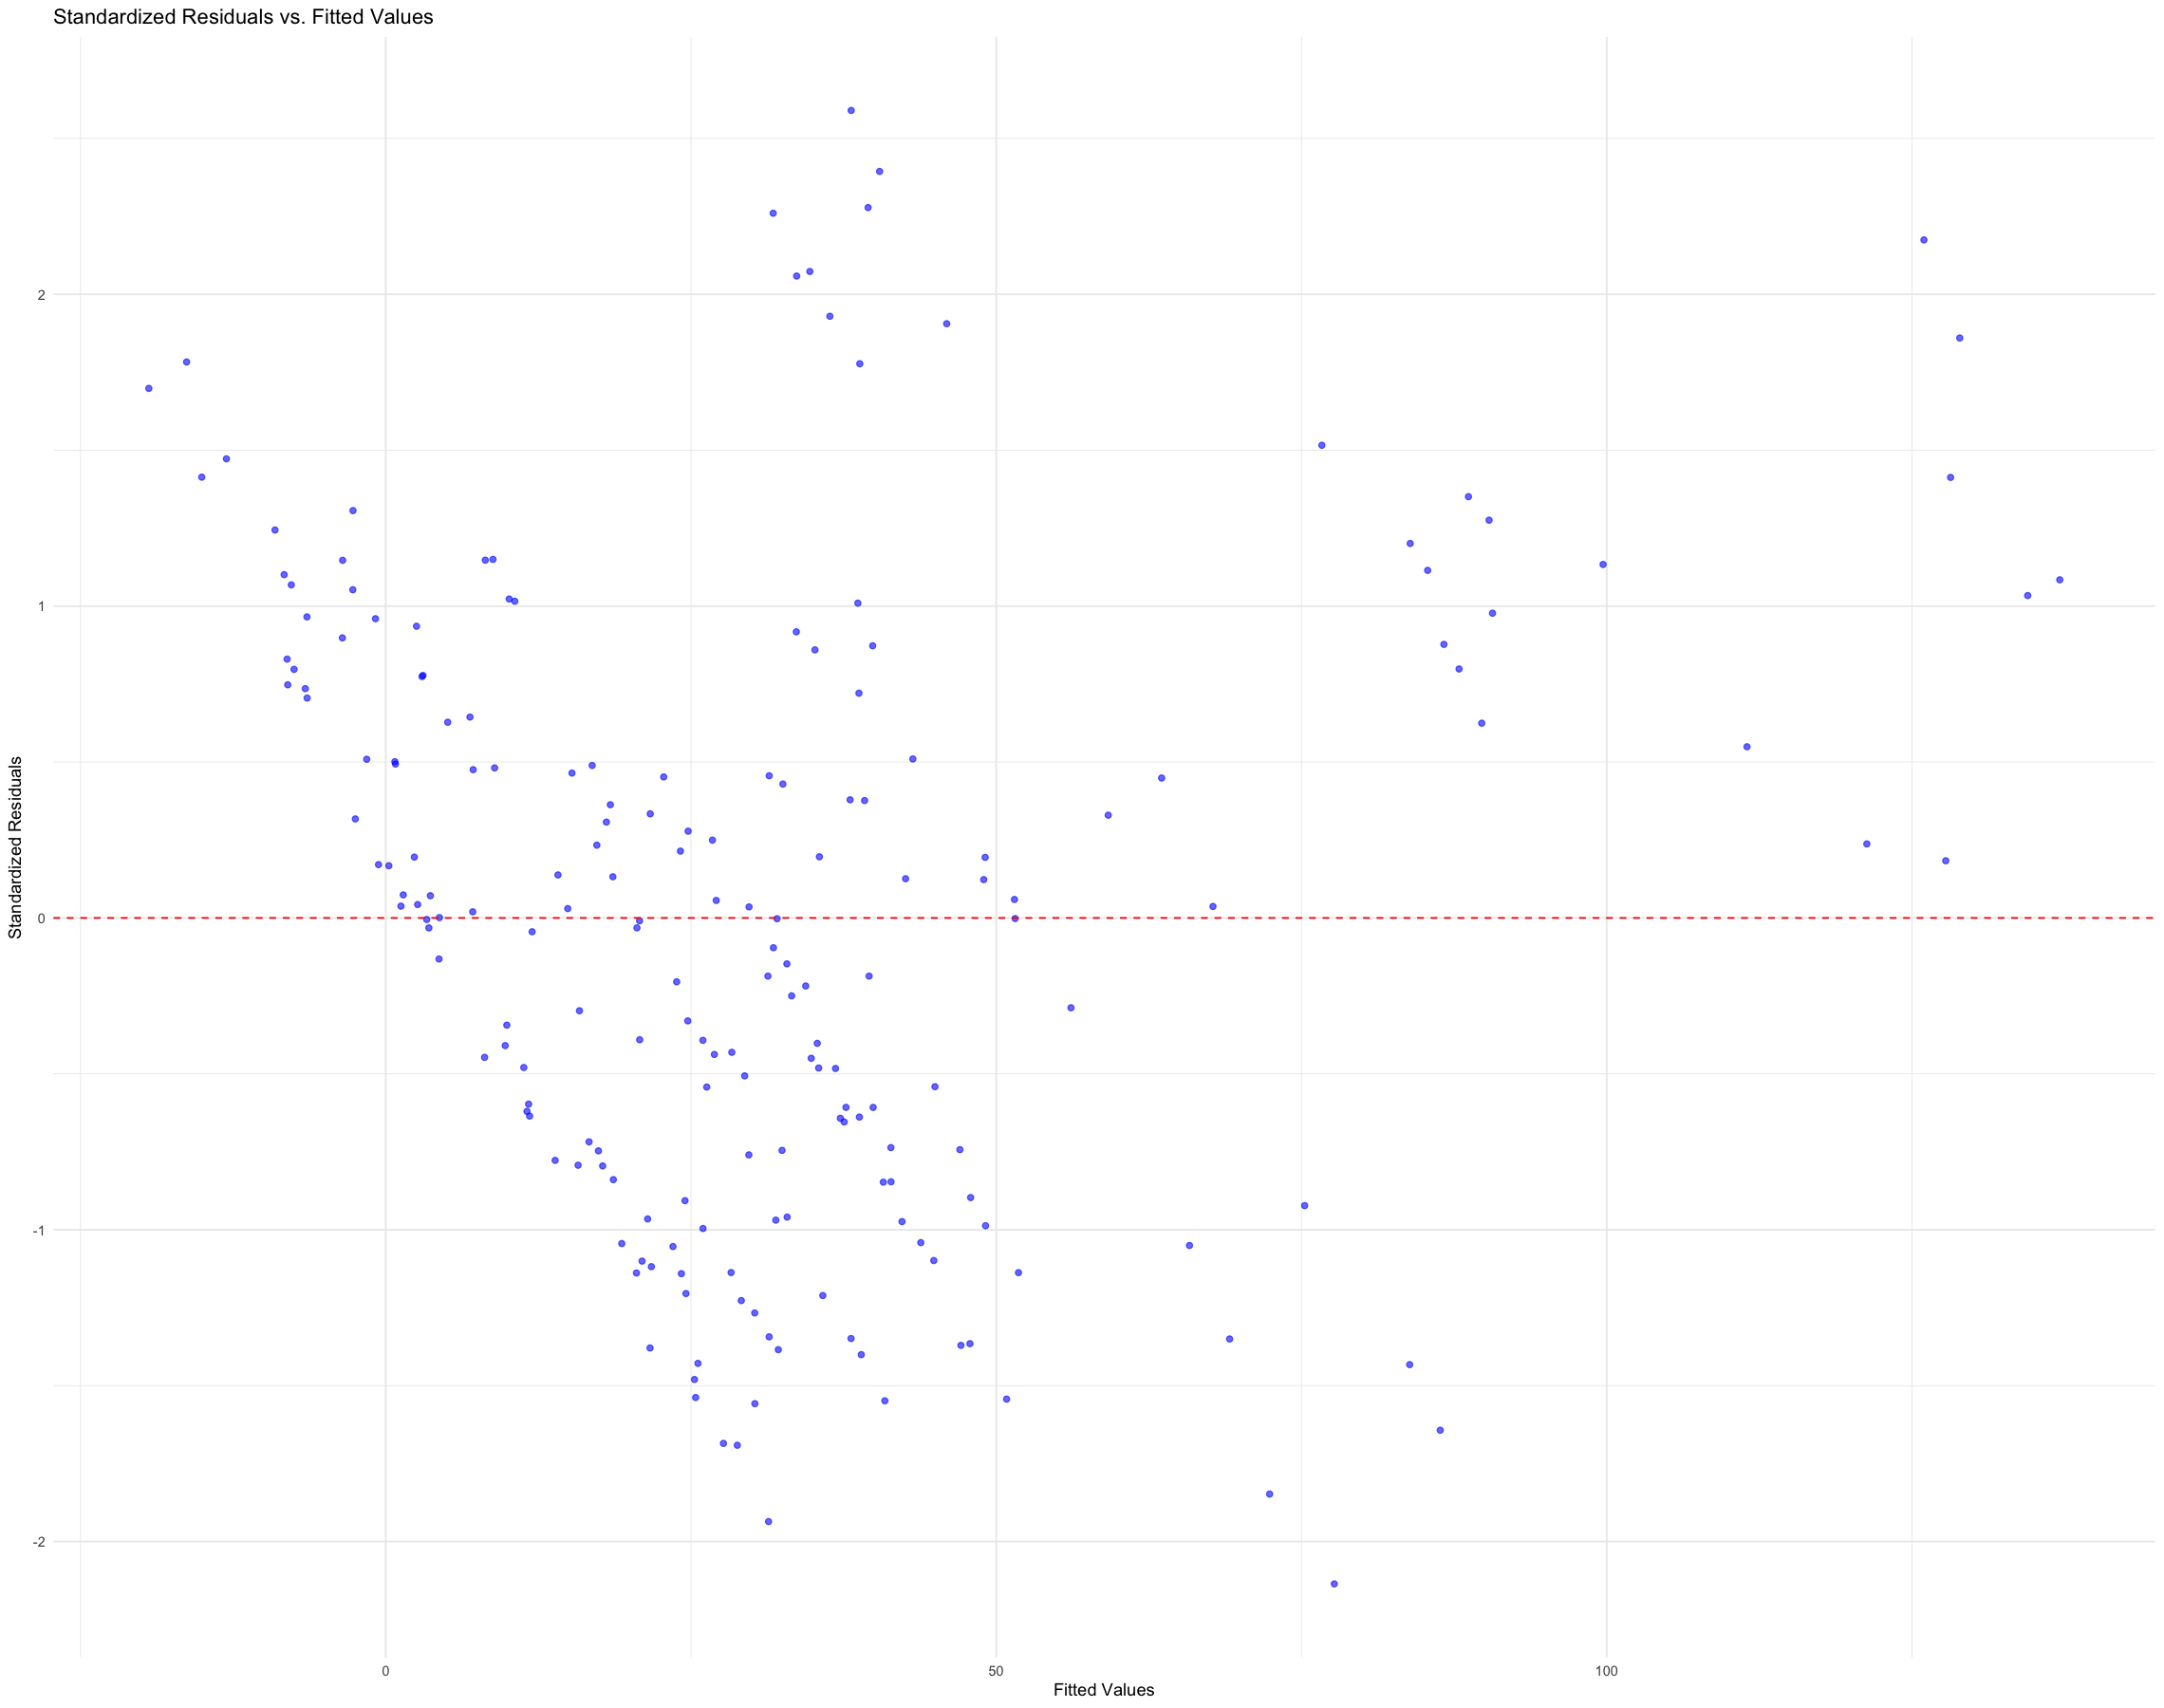

In [74]:
std_resid_cluster <- rstandard(mlr_model_cluster)
fitted_vals_cluster <- fitted(mlr_model_cluster)

ggplot(mapping = aes(x = fitted(mlr_model_cluster), y = rstandard(mlr_model_cluster))) +
  geom_point(alpha = 0.6, color = "blue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Standardized Residuals vs. Fitted Values",
    x = "Fitted Values",
    y = "Standardized Residuals"
  ) +
  theme_minimal()

190 189 
189  95

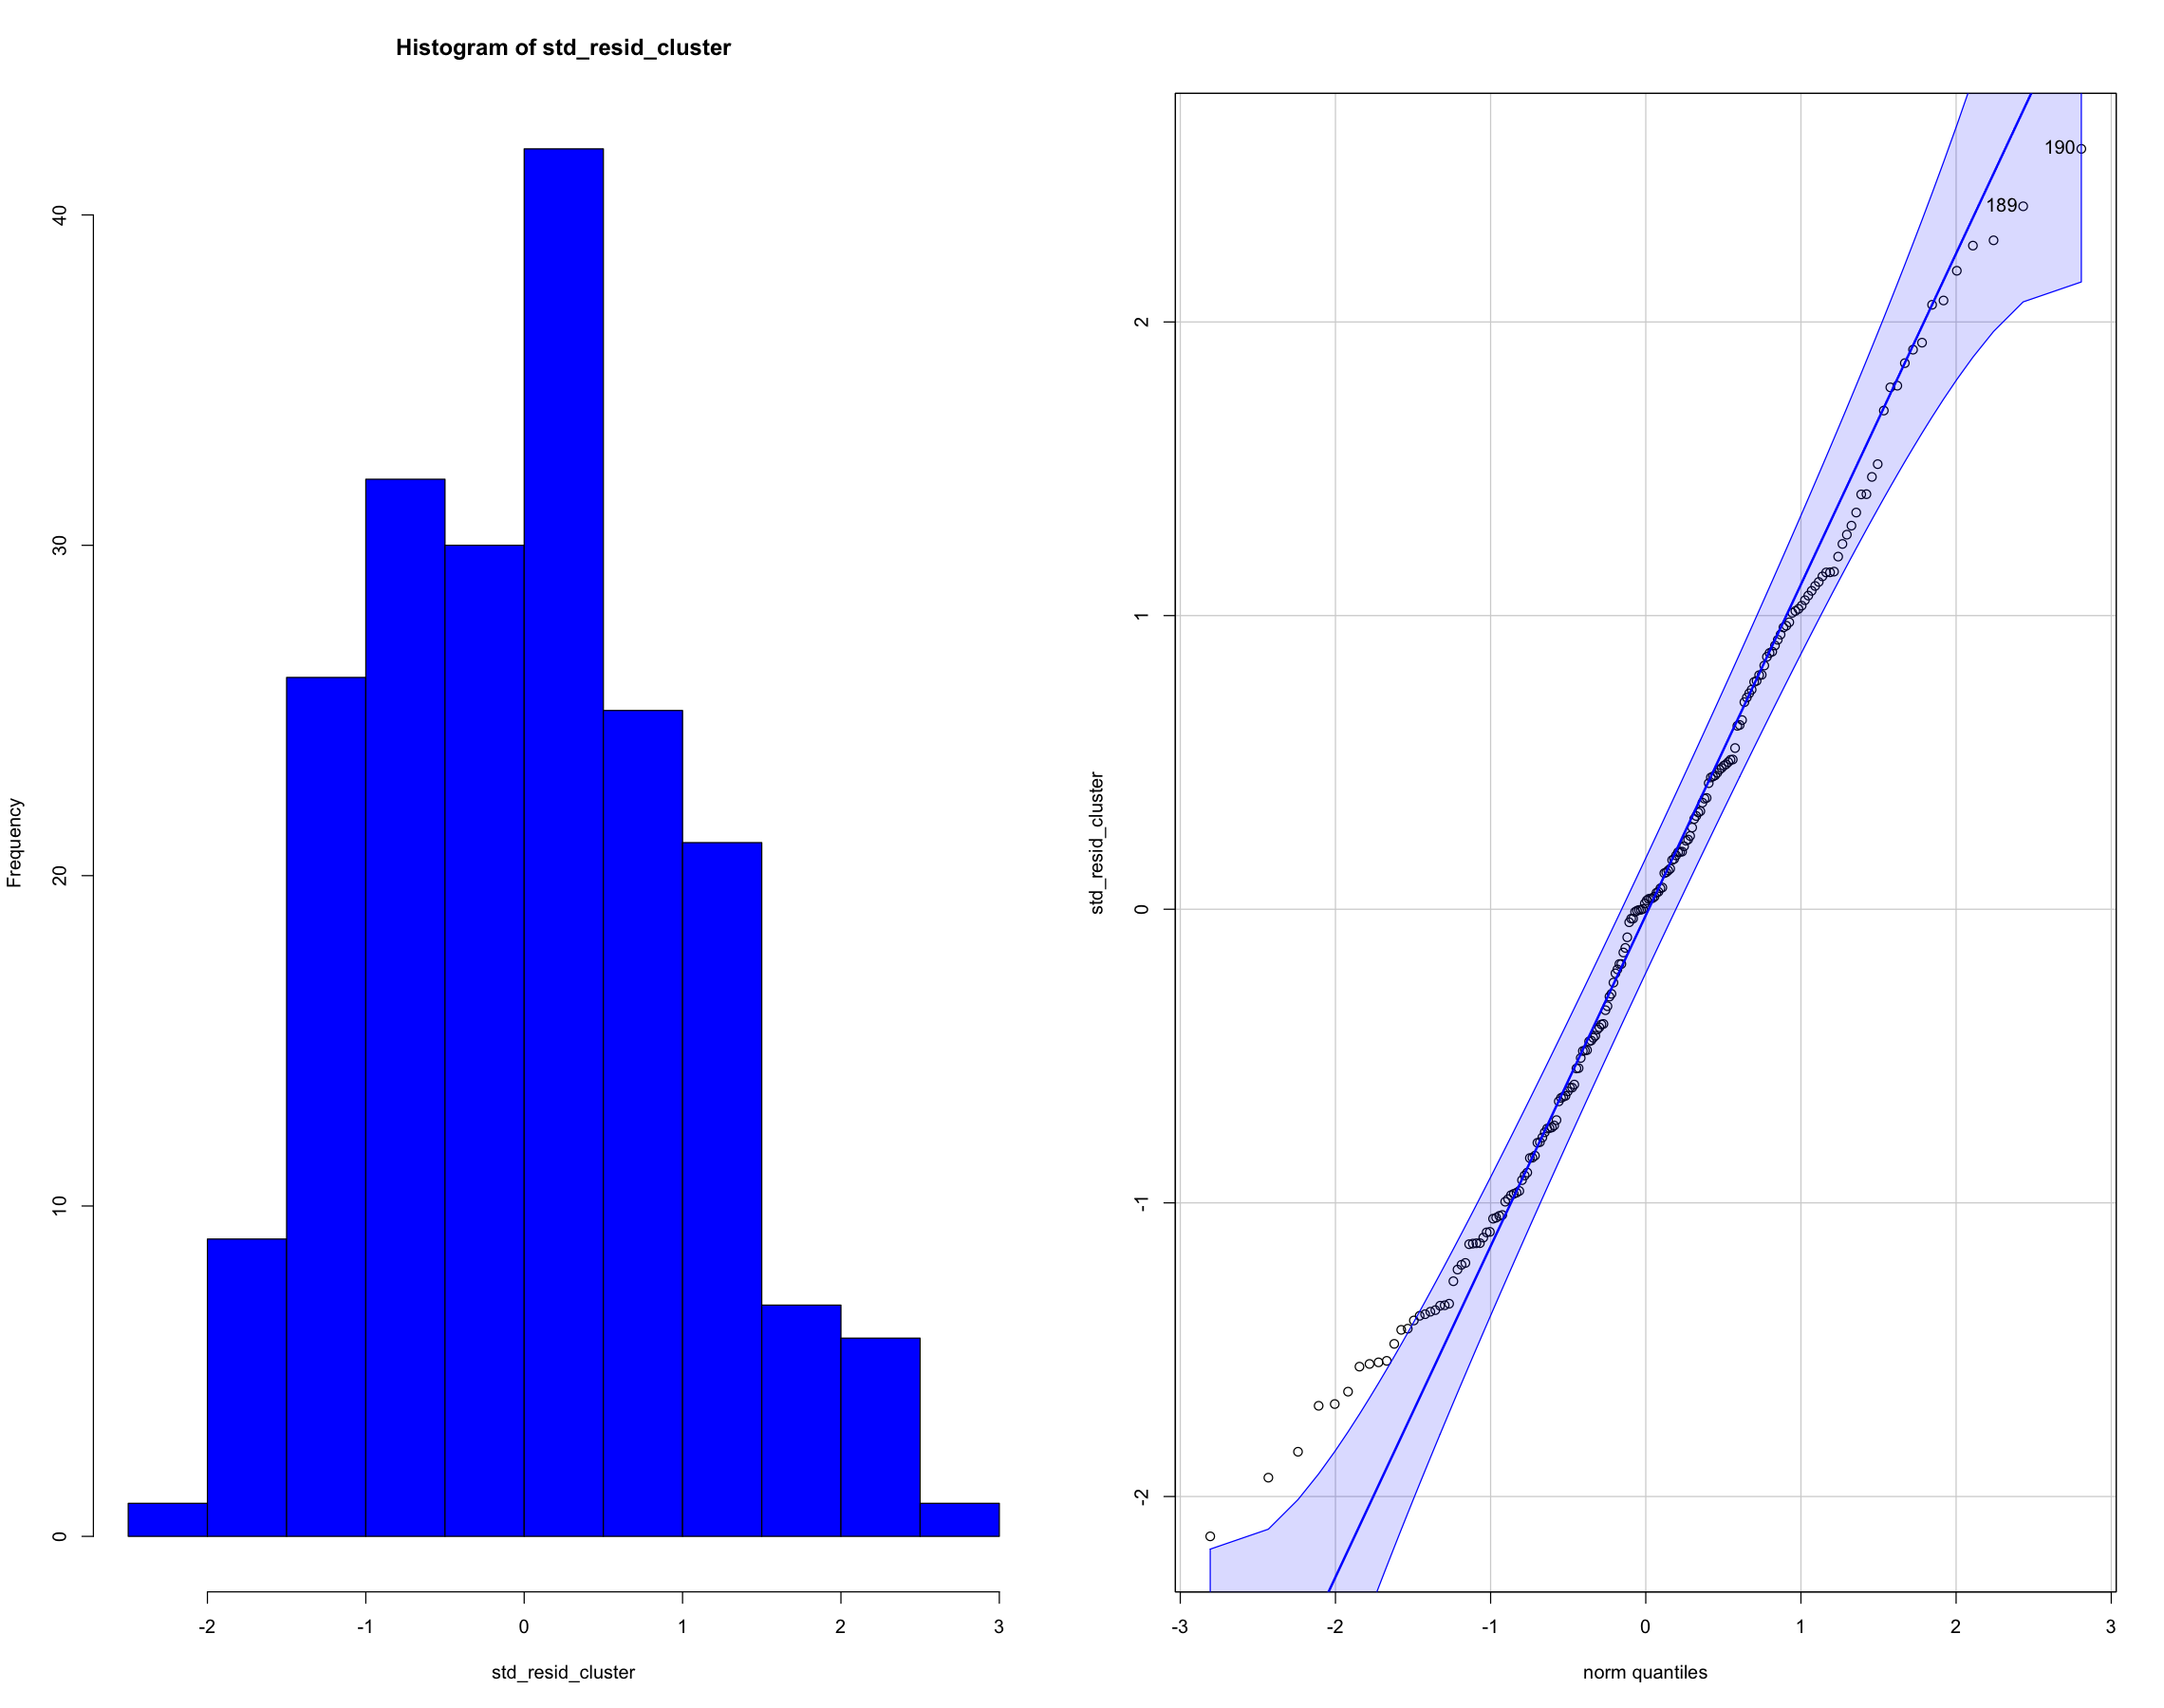

In [75]:
par(mfrow = c(1, 2))
hist(std_resid_cluster, col = "blue")
qqPlot(std_resid_cluster, envelope = 0.95)

## For mlr_model_transformed

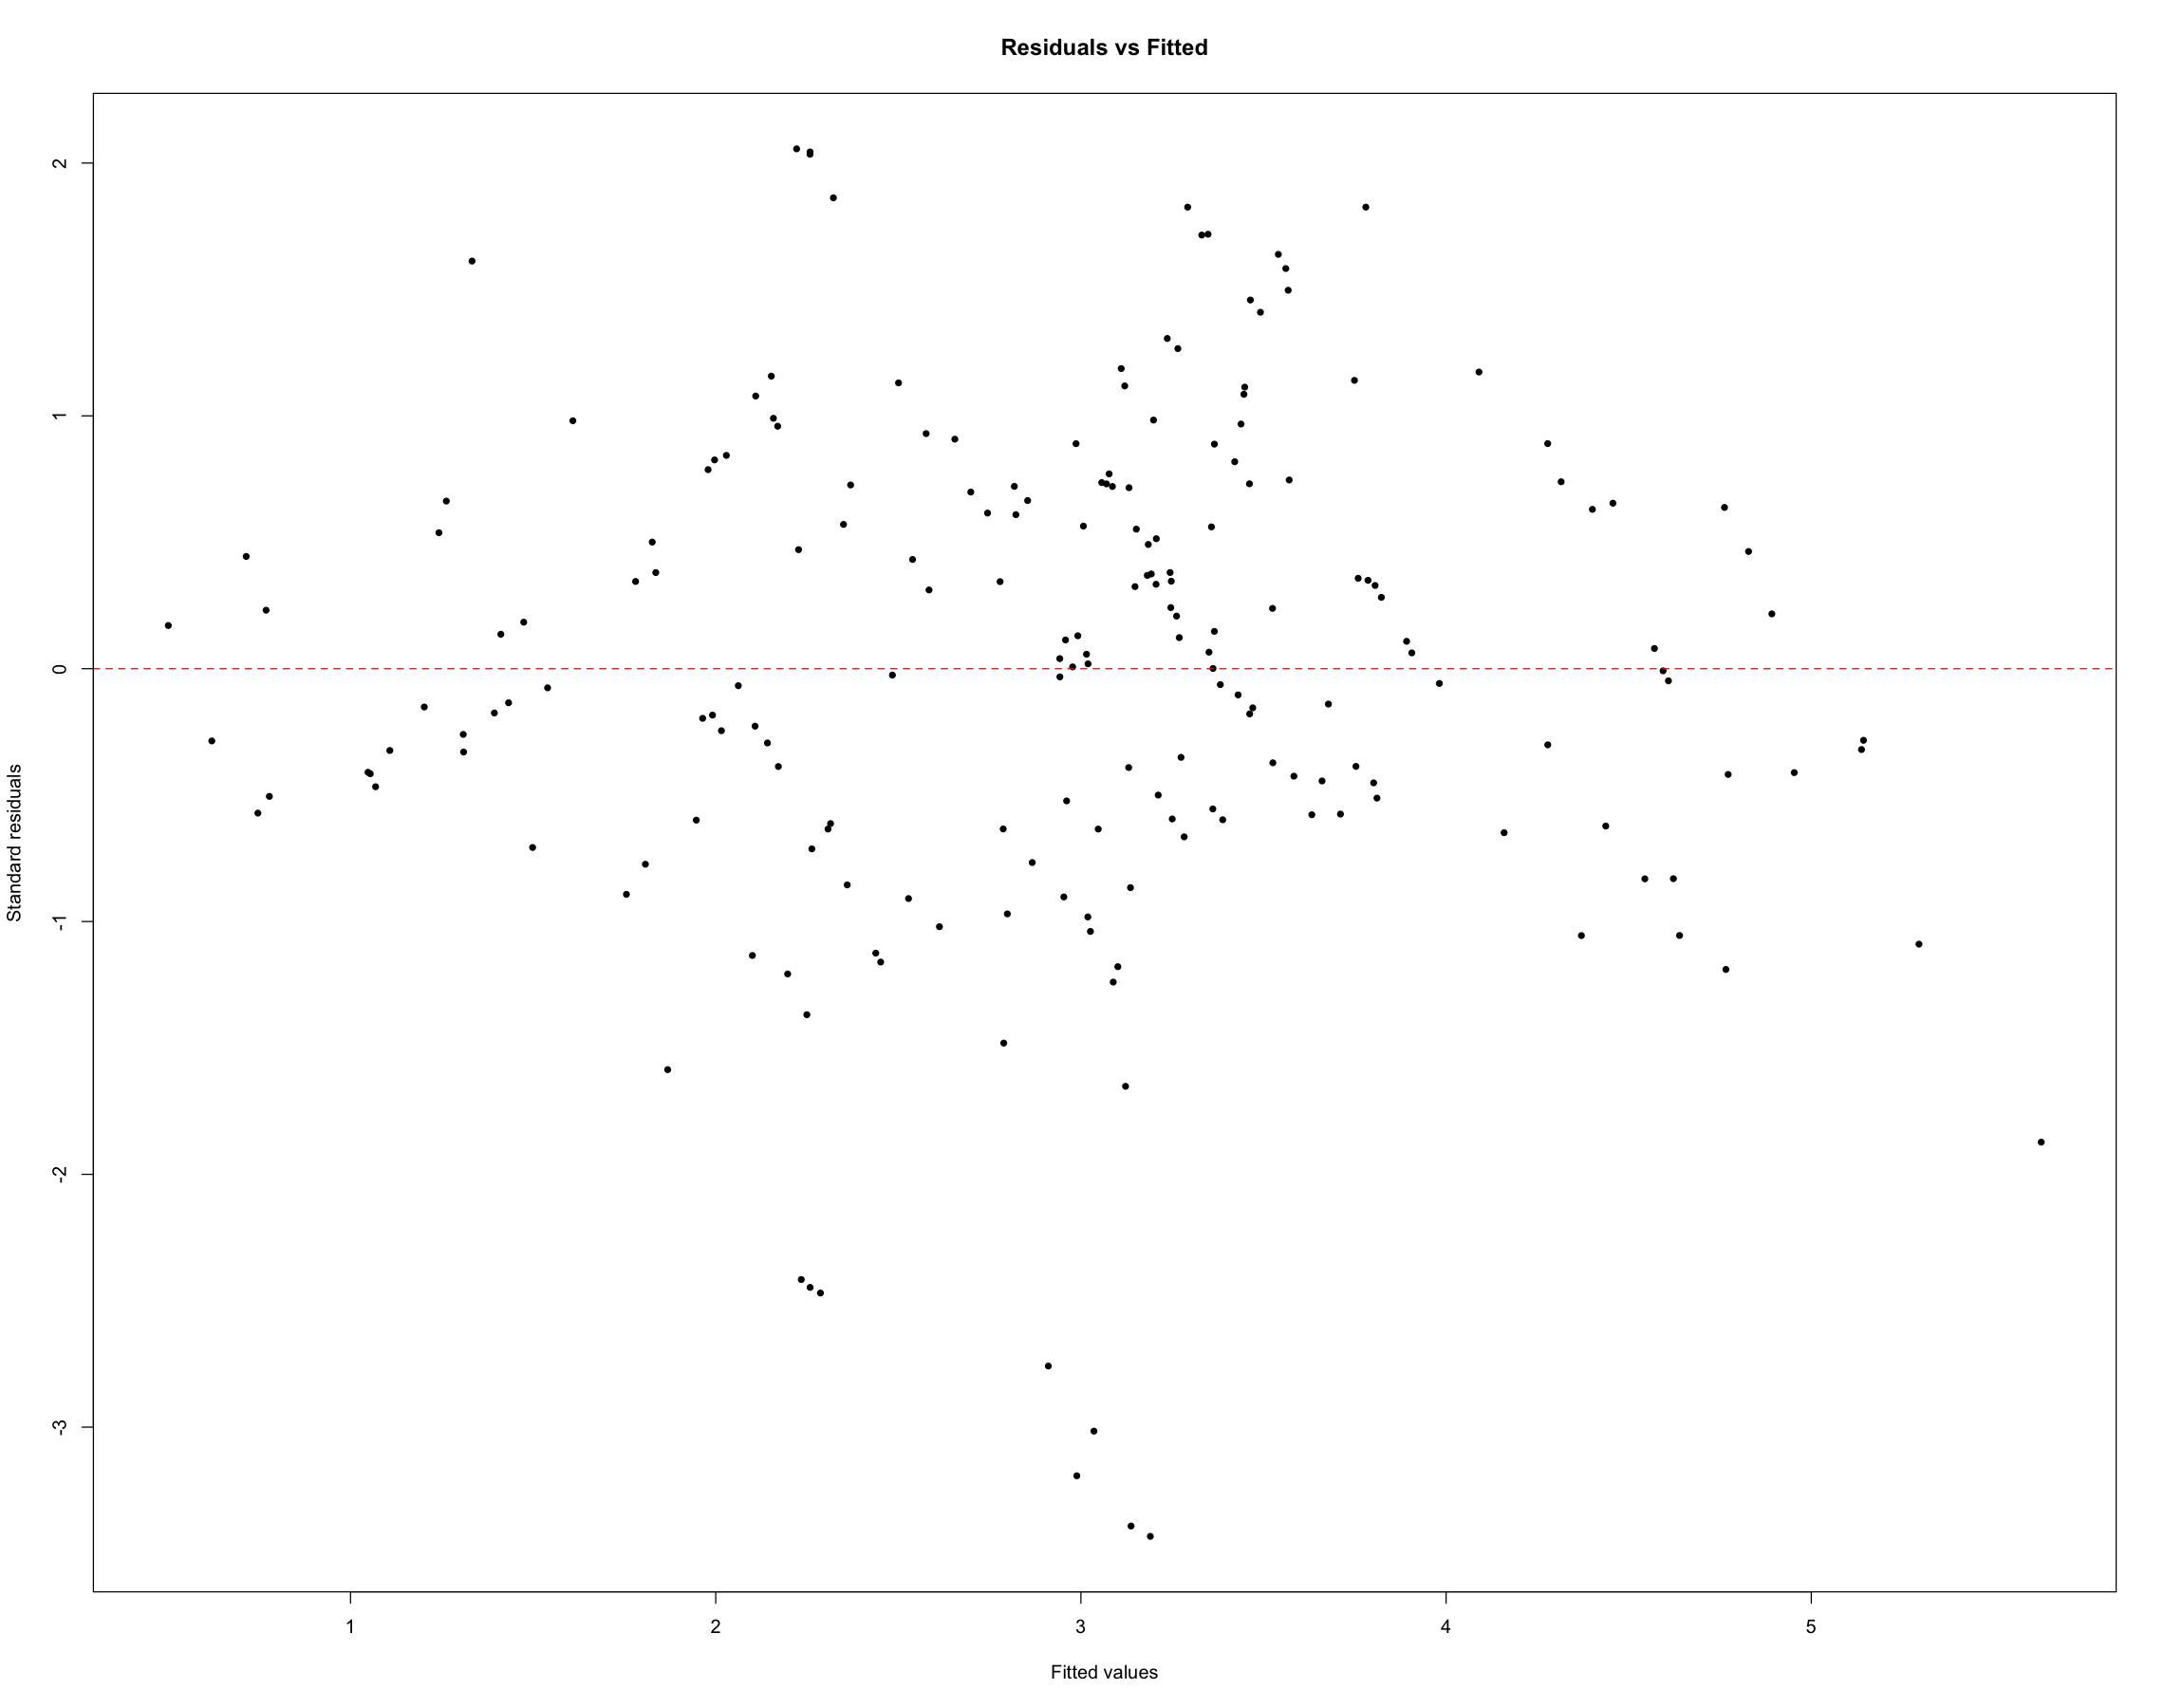

In [87]:
# Residuals vs Fitted (Linearity & Constant Variance)
par(mfrow = c(1, 1))
plot(mlr_model_transformed$fitted.values, rstandard(mlr_model_transformed),
     xlab = "Fitted values",
     ylab = "Standard residuals",
     main = "Residuals vs Fitted",
     pch = 20)
abline(h = 0, lty = 2, col = "red")

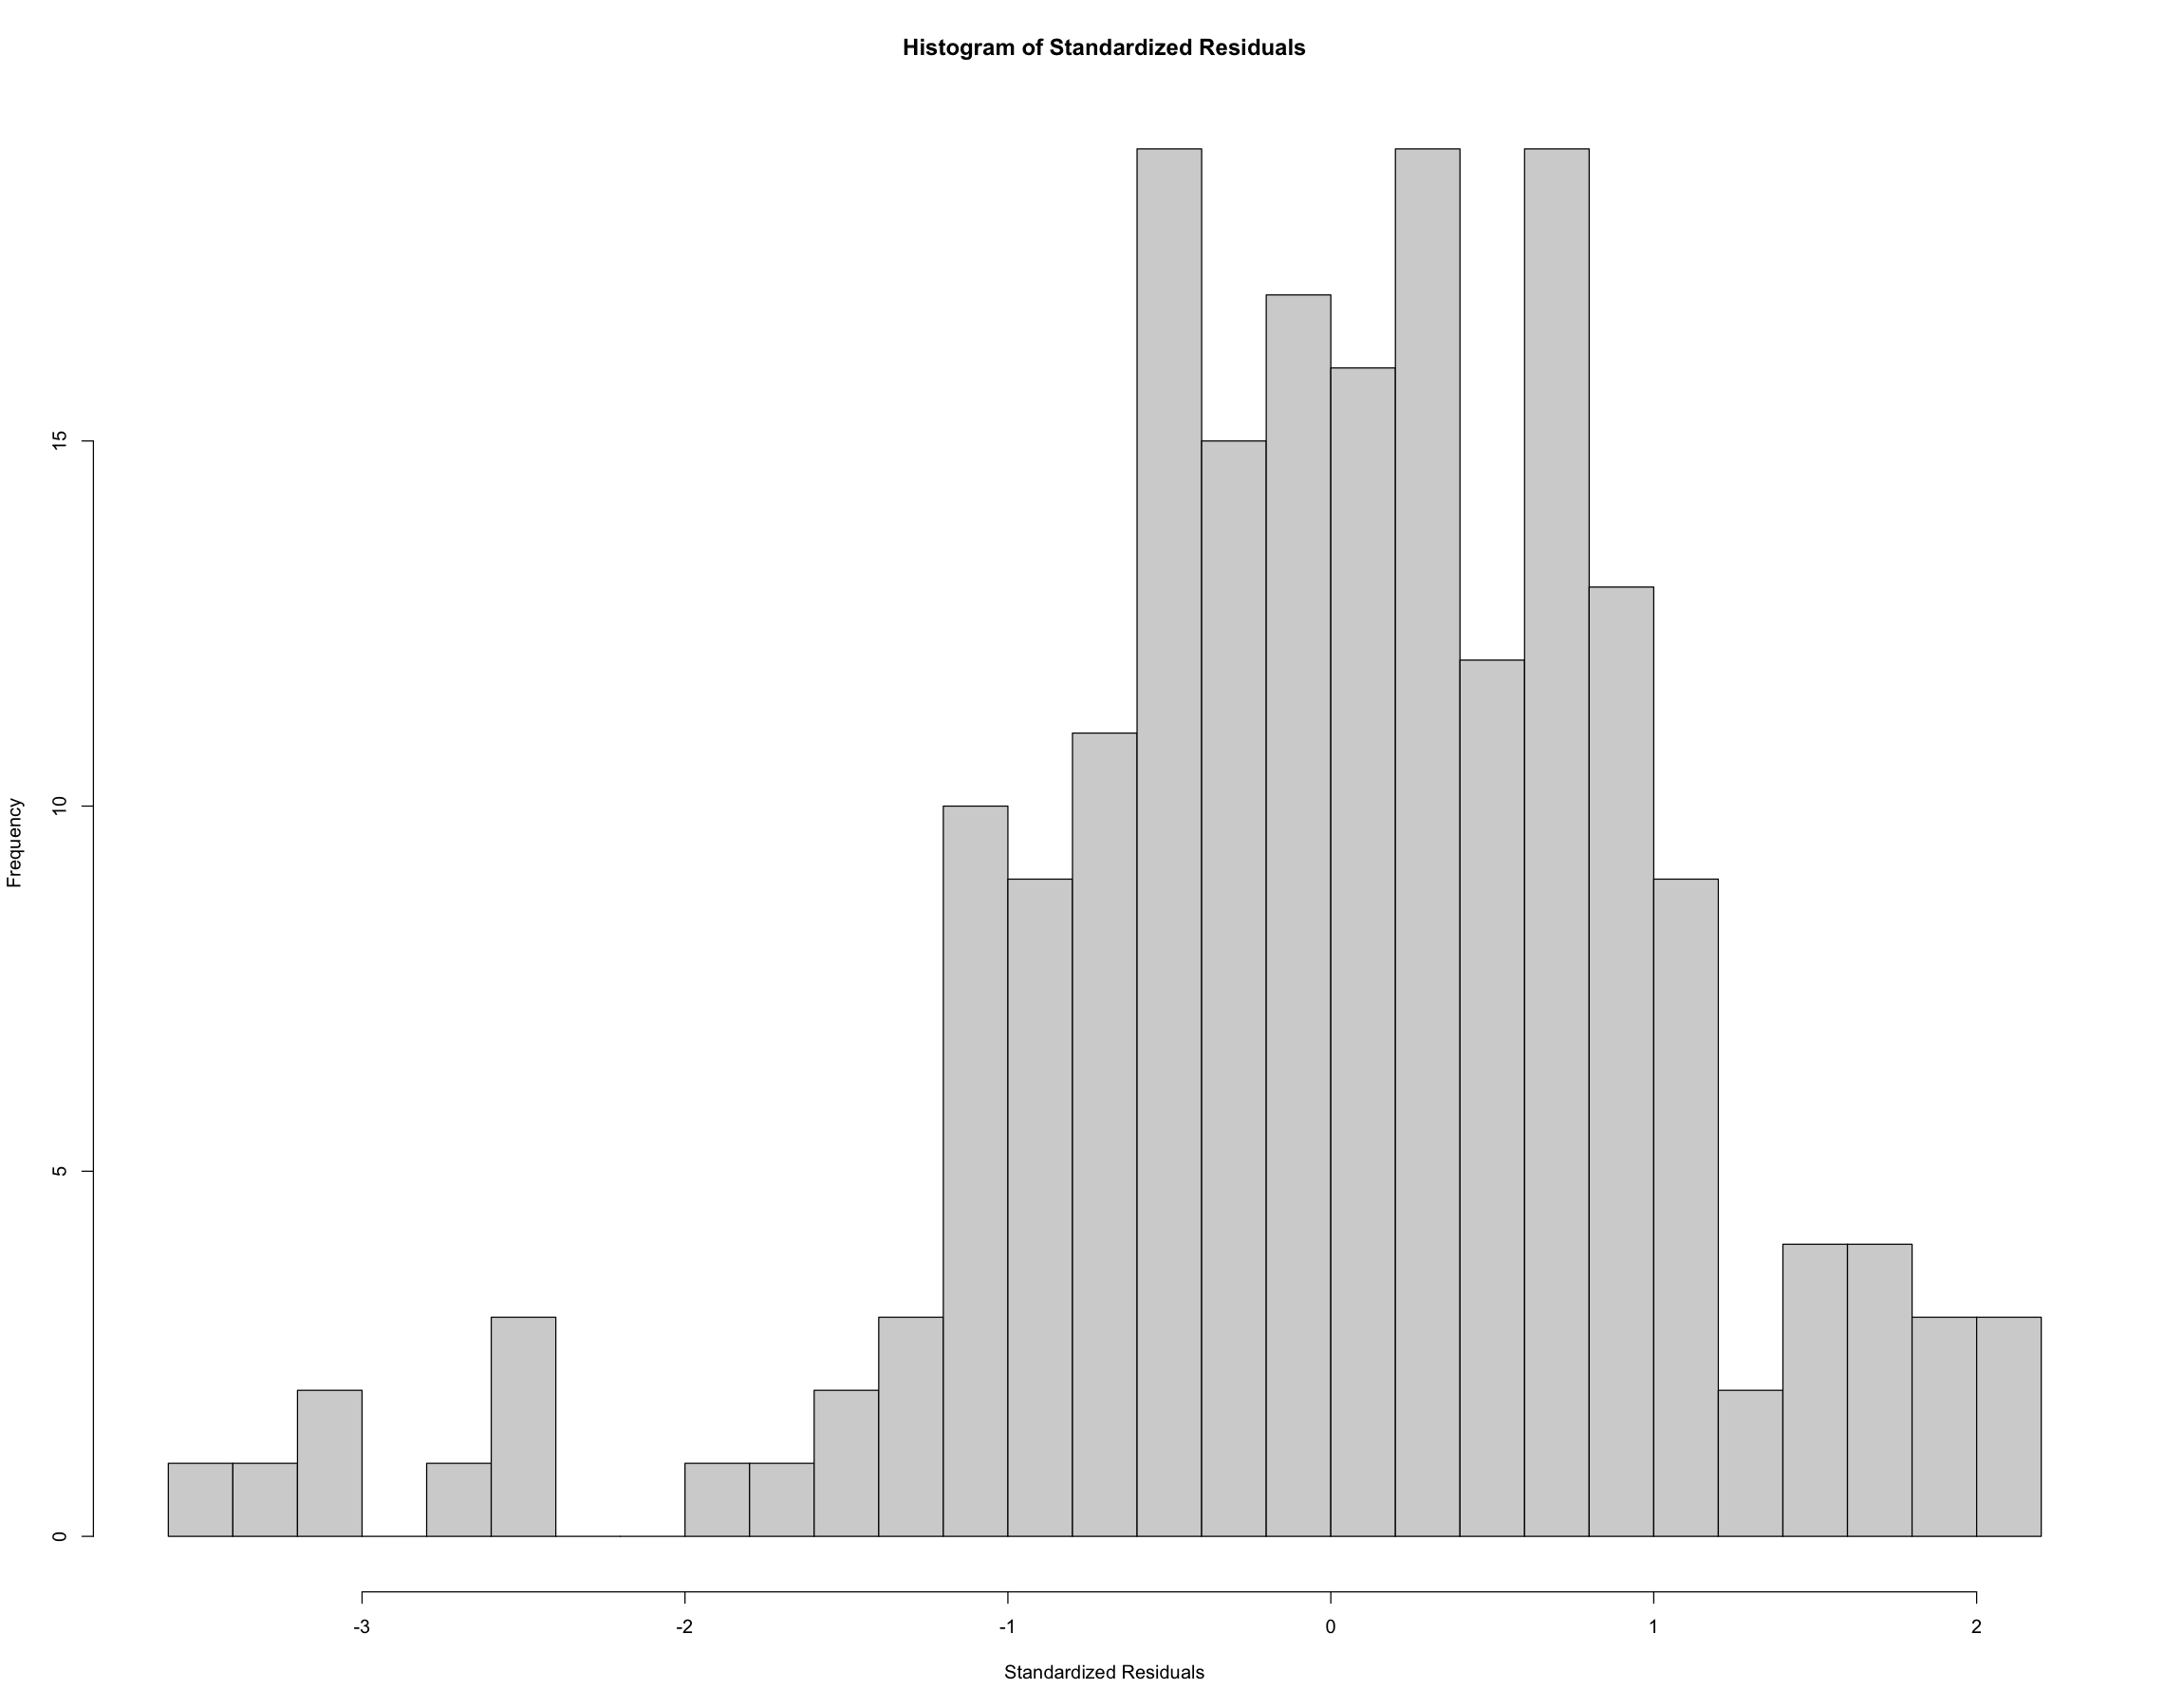

In [86]:
# Normal distibution for standardized residuals
hist(rstandard(mlr_model_transformed), breaks = 30,
     main = "Histogram of Standardized Residuals",
     xlab = "Standardized Residuals")

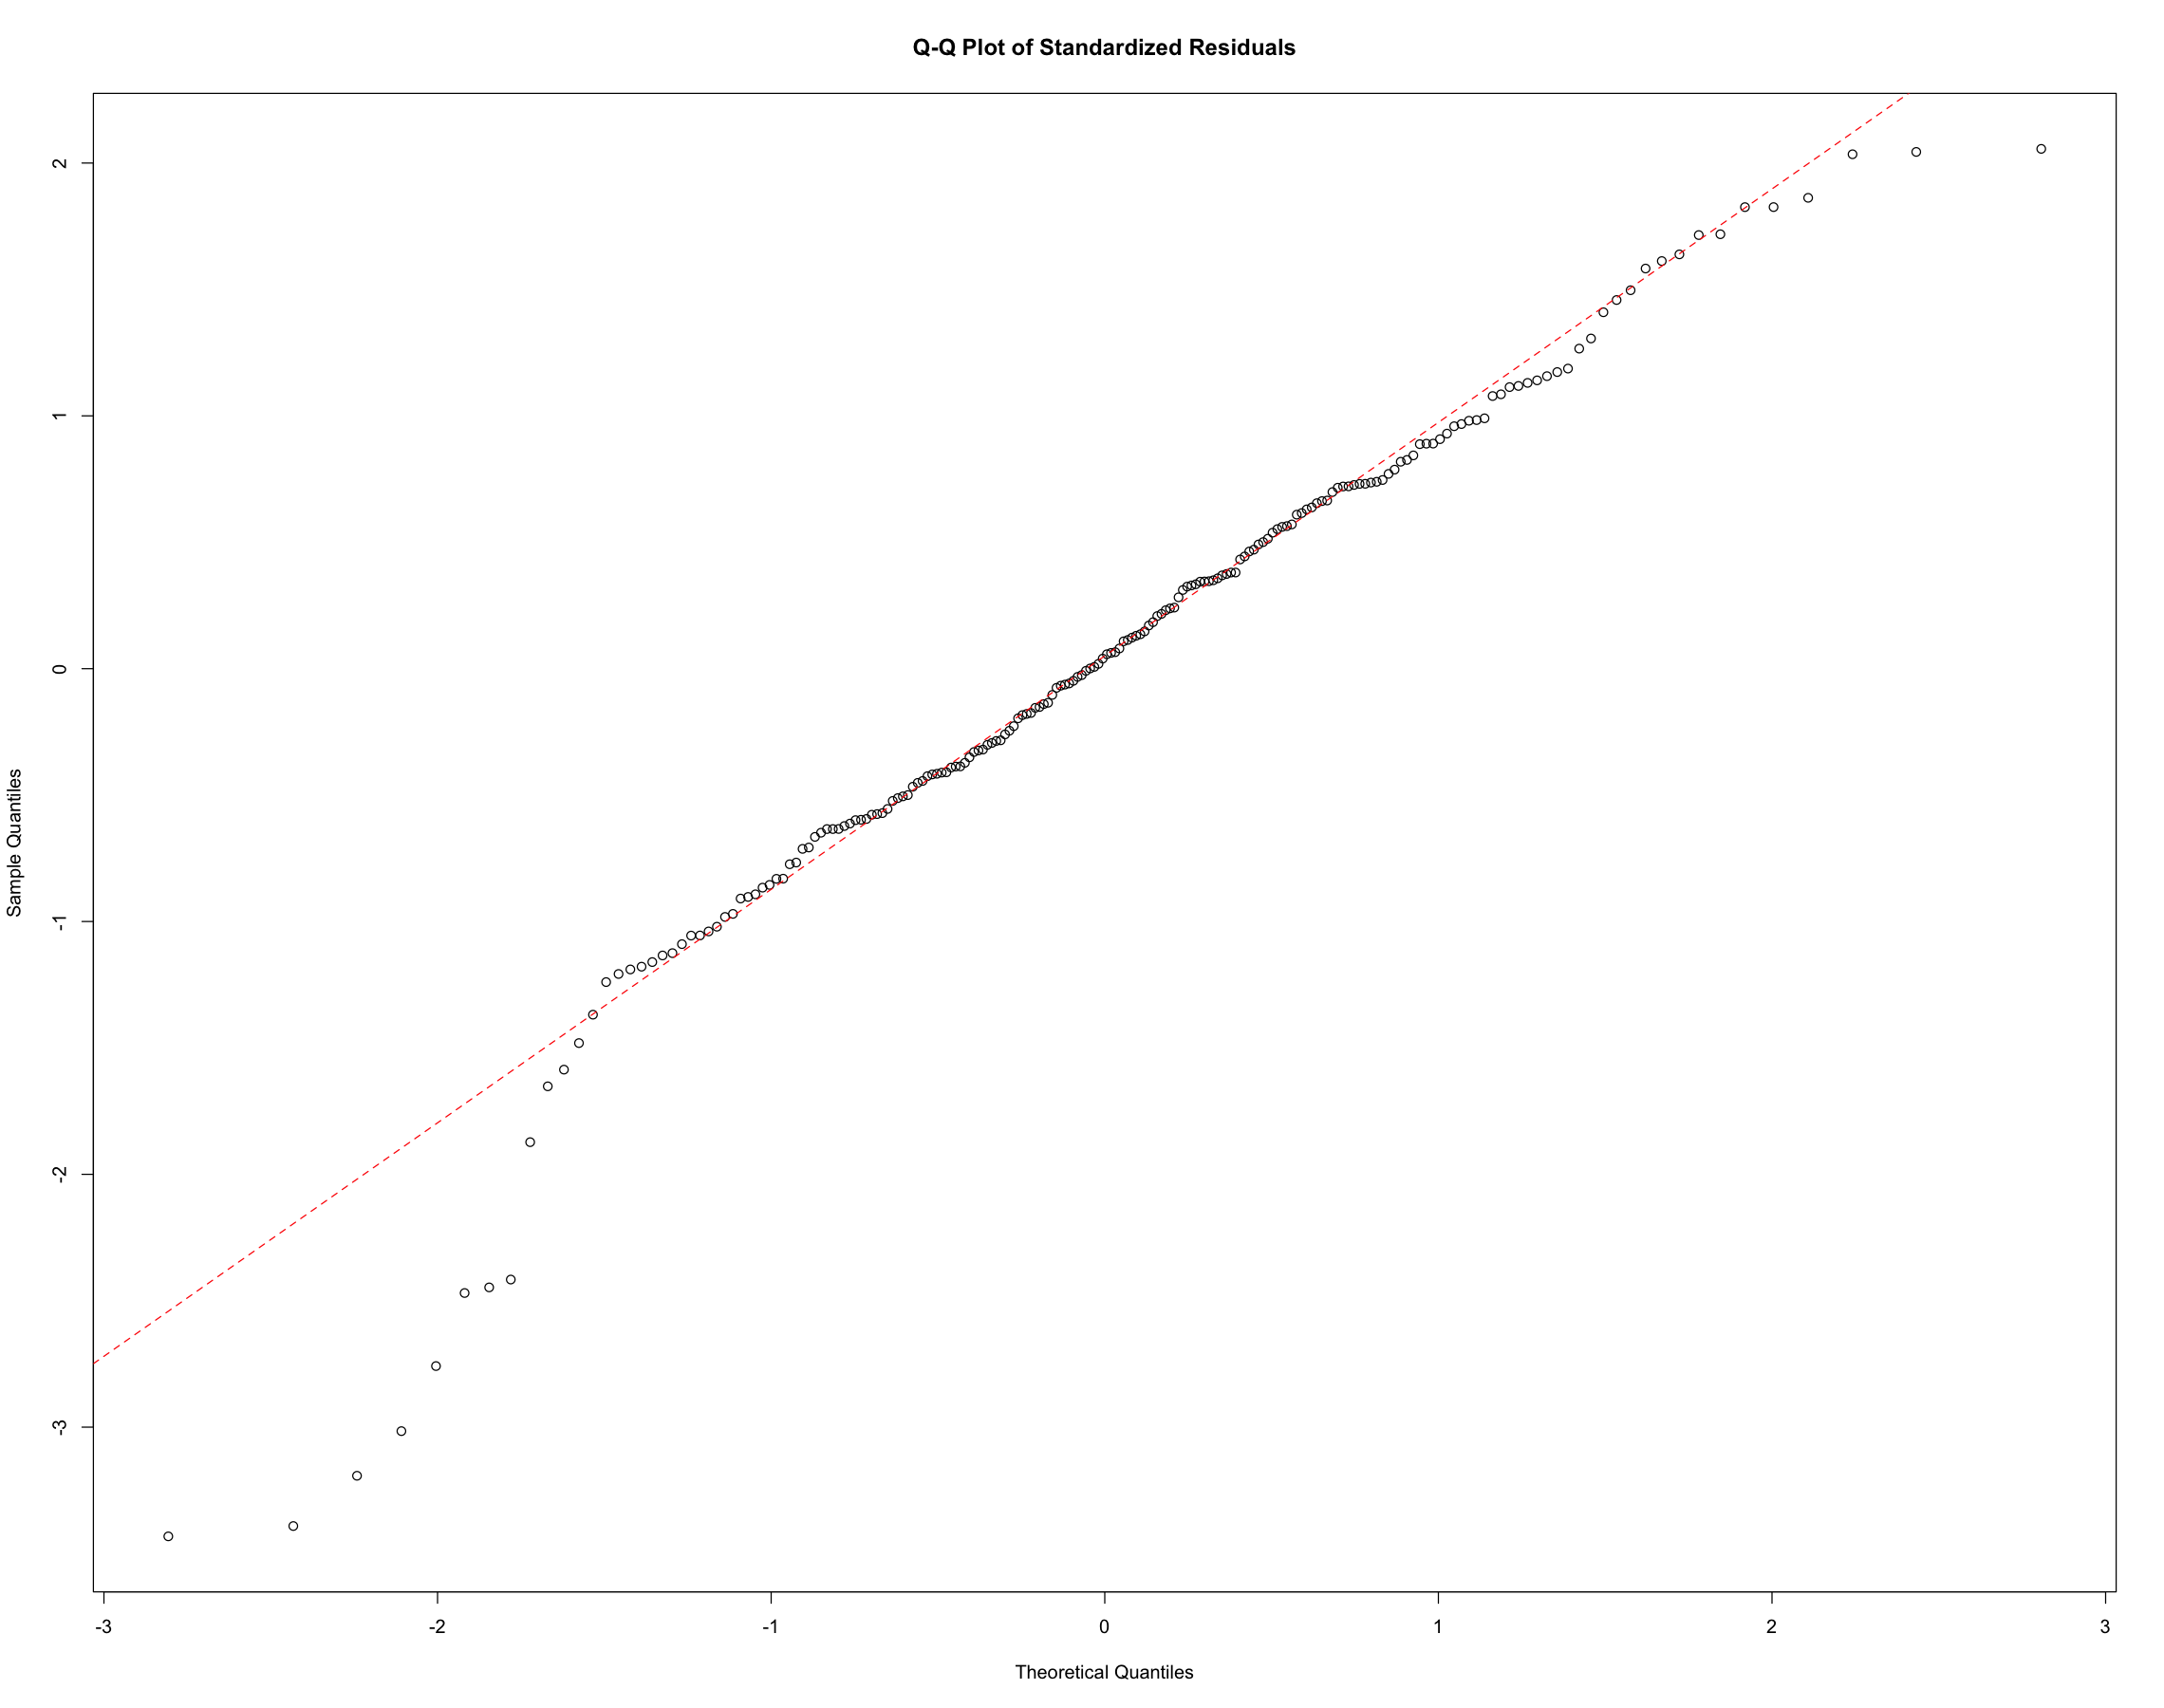

In [83]:
#Normal Q-Q Plot (Normality of Residuals)
qqnorm(rstandard(mlr_model_transformed), main = "Q-Q Plot of Standardized Residuals")
qqline(rstandard(mlr_model_transformed), col = "red", lty = 2)

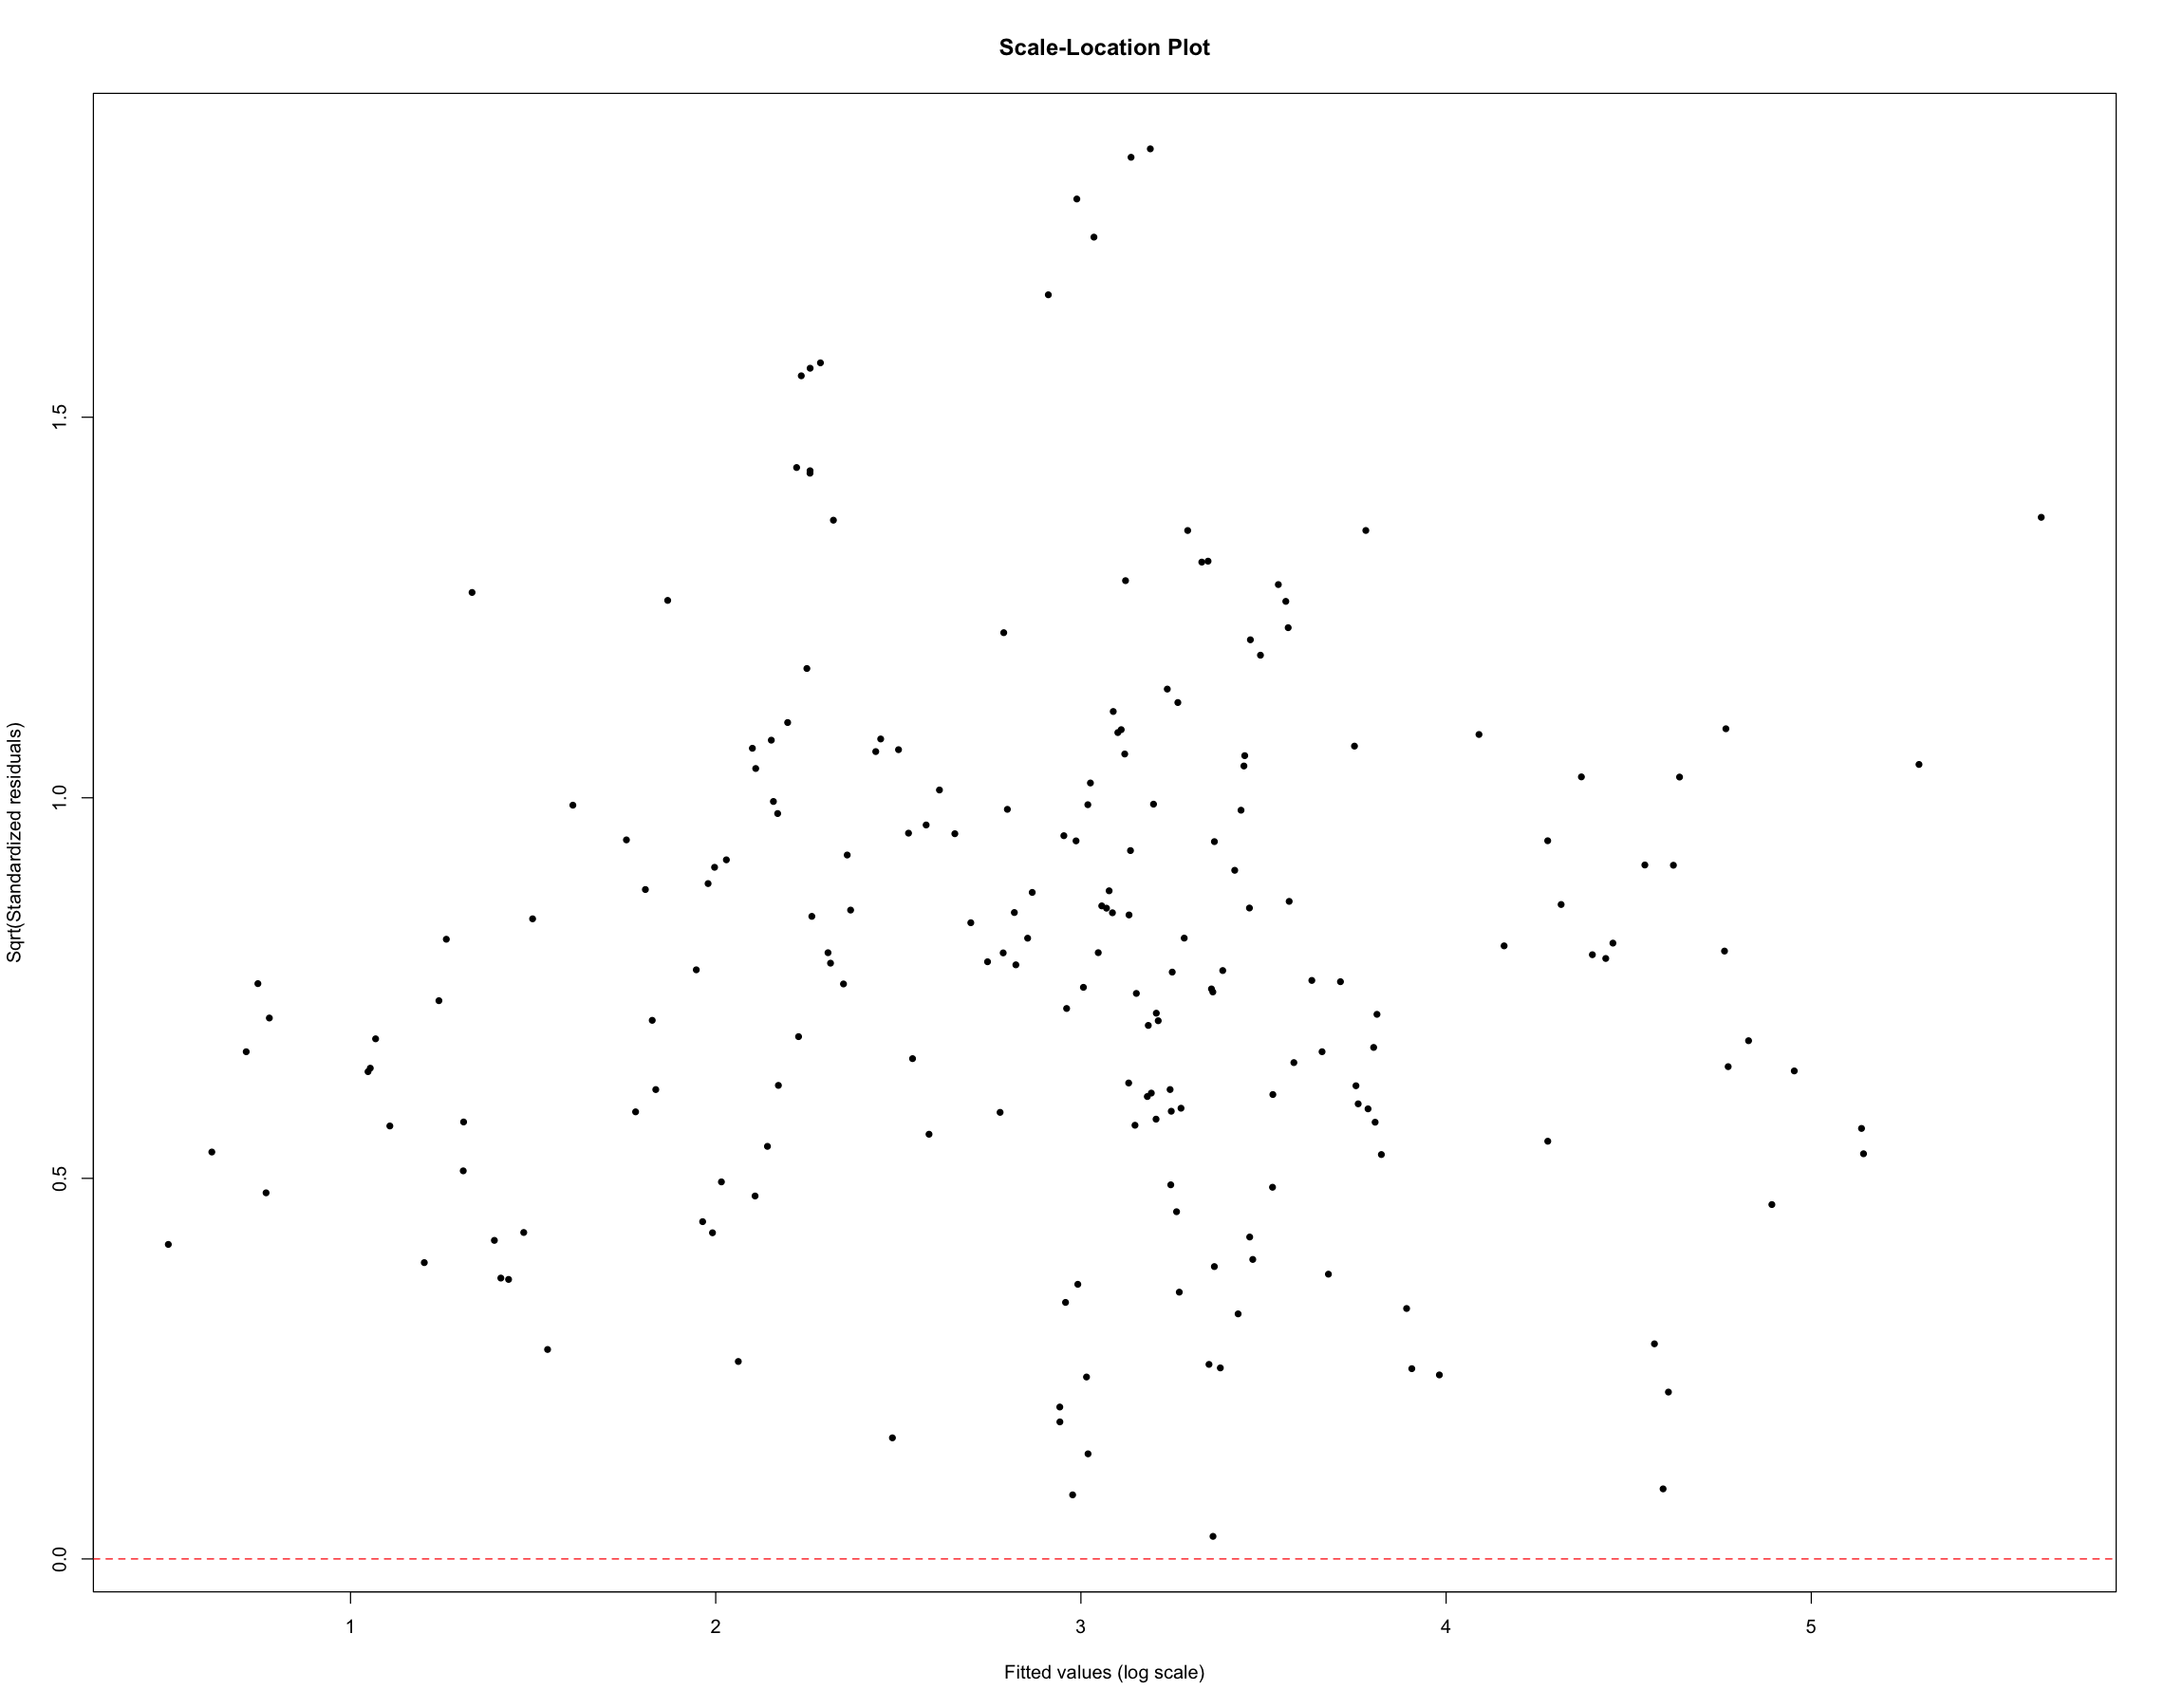

In [84]:
#Scale-Location Plot (Homoscedasticity)
plot(mlr_model_transformed$fitted.values, sqrt(abs(rstandard(mlr_model_transformed))),
     xlab = "Fitted values (log scale)",
     ylab = "Sqrt(Standardized residuals)",
     main = "Scale-Location Plot",
     pch = 20)
abline(h = 0, lty = 2, col = "red")

## For mlr_model_cluster_transformed

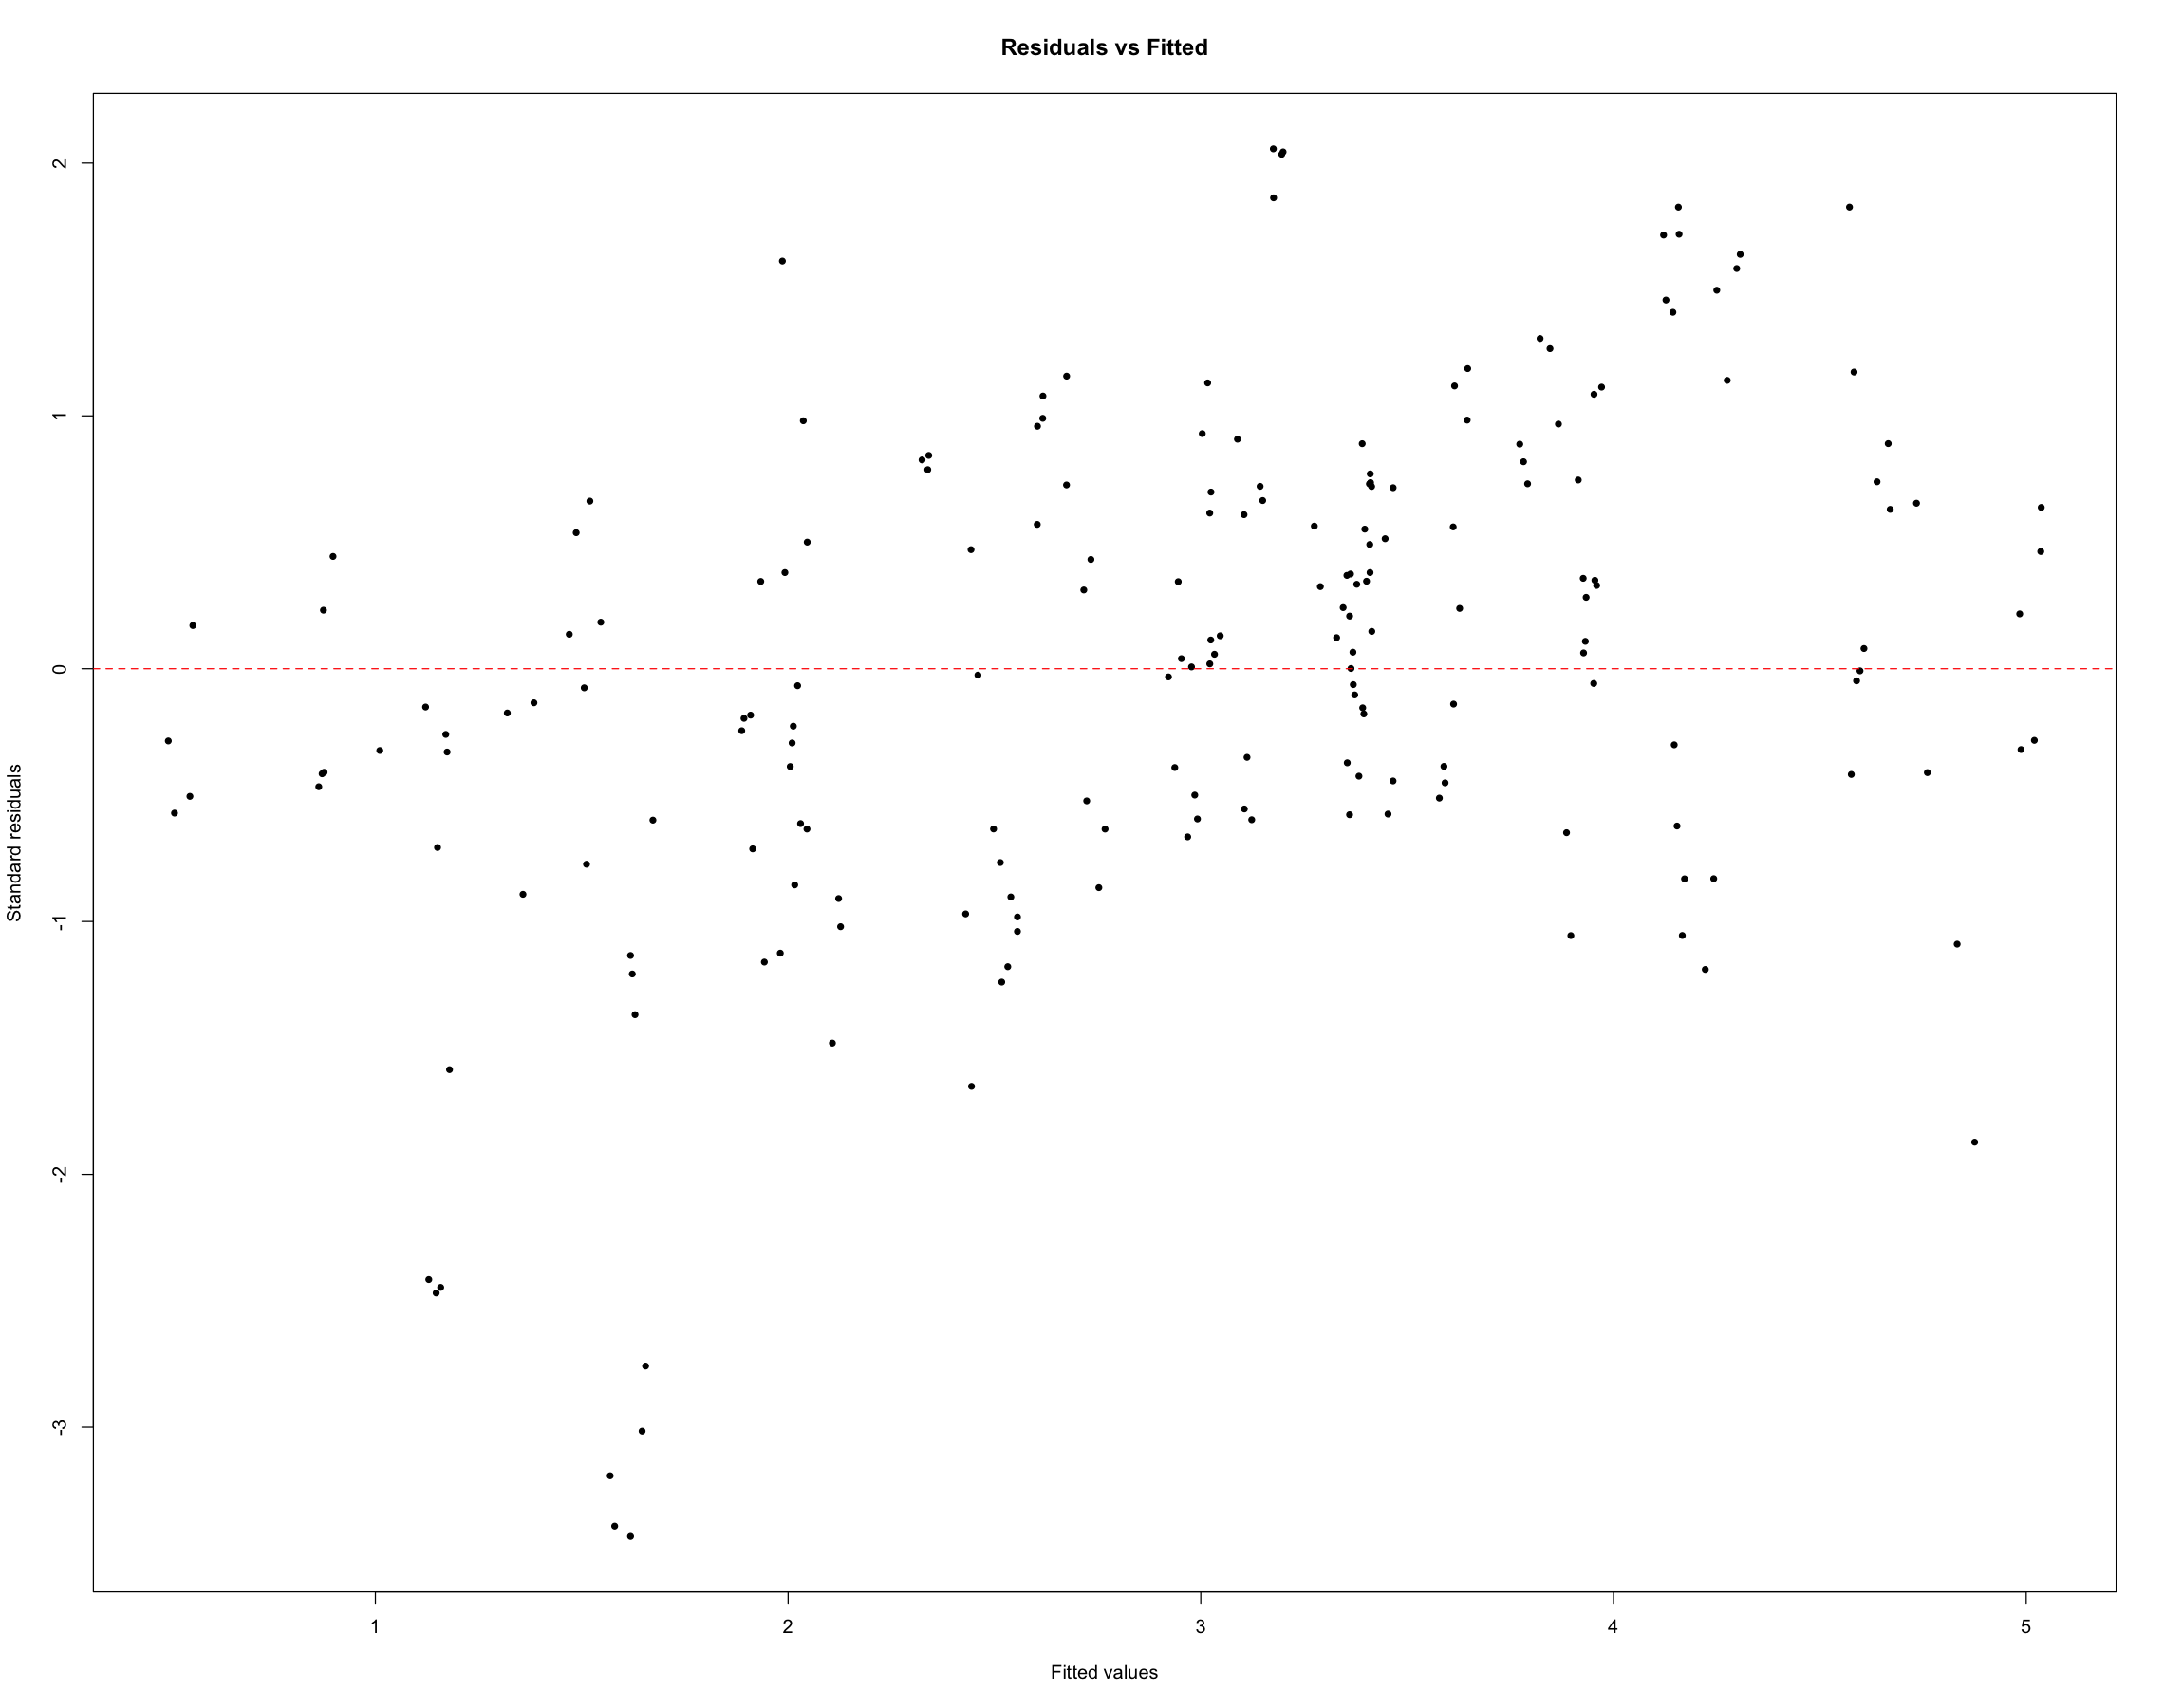

In [89]:
# Residuals vs Fitted (Linearity & Constant Variance)
par(mfrow = c(1, 1))
plot(mlr_model_cluster_transformed$fitted.values, rstandard(mlr_model_transformed),
     xlab = "Fitted values",
     ylab = "Standard residuals",
     main = "Residuals vs Fitted",
     pch = 20)
abline(h = 0, lty = 2, col = "red")

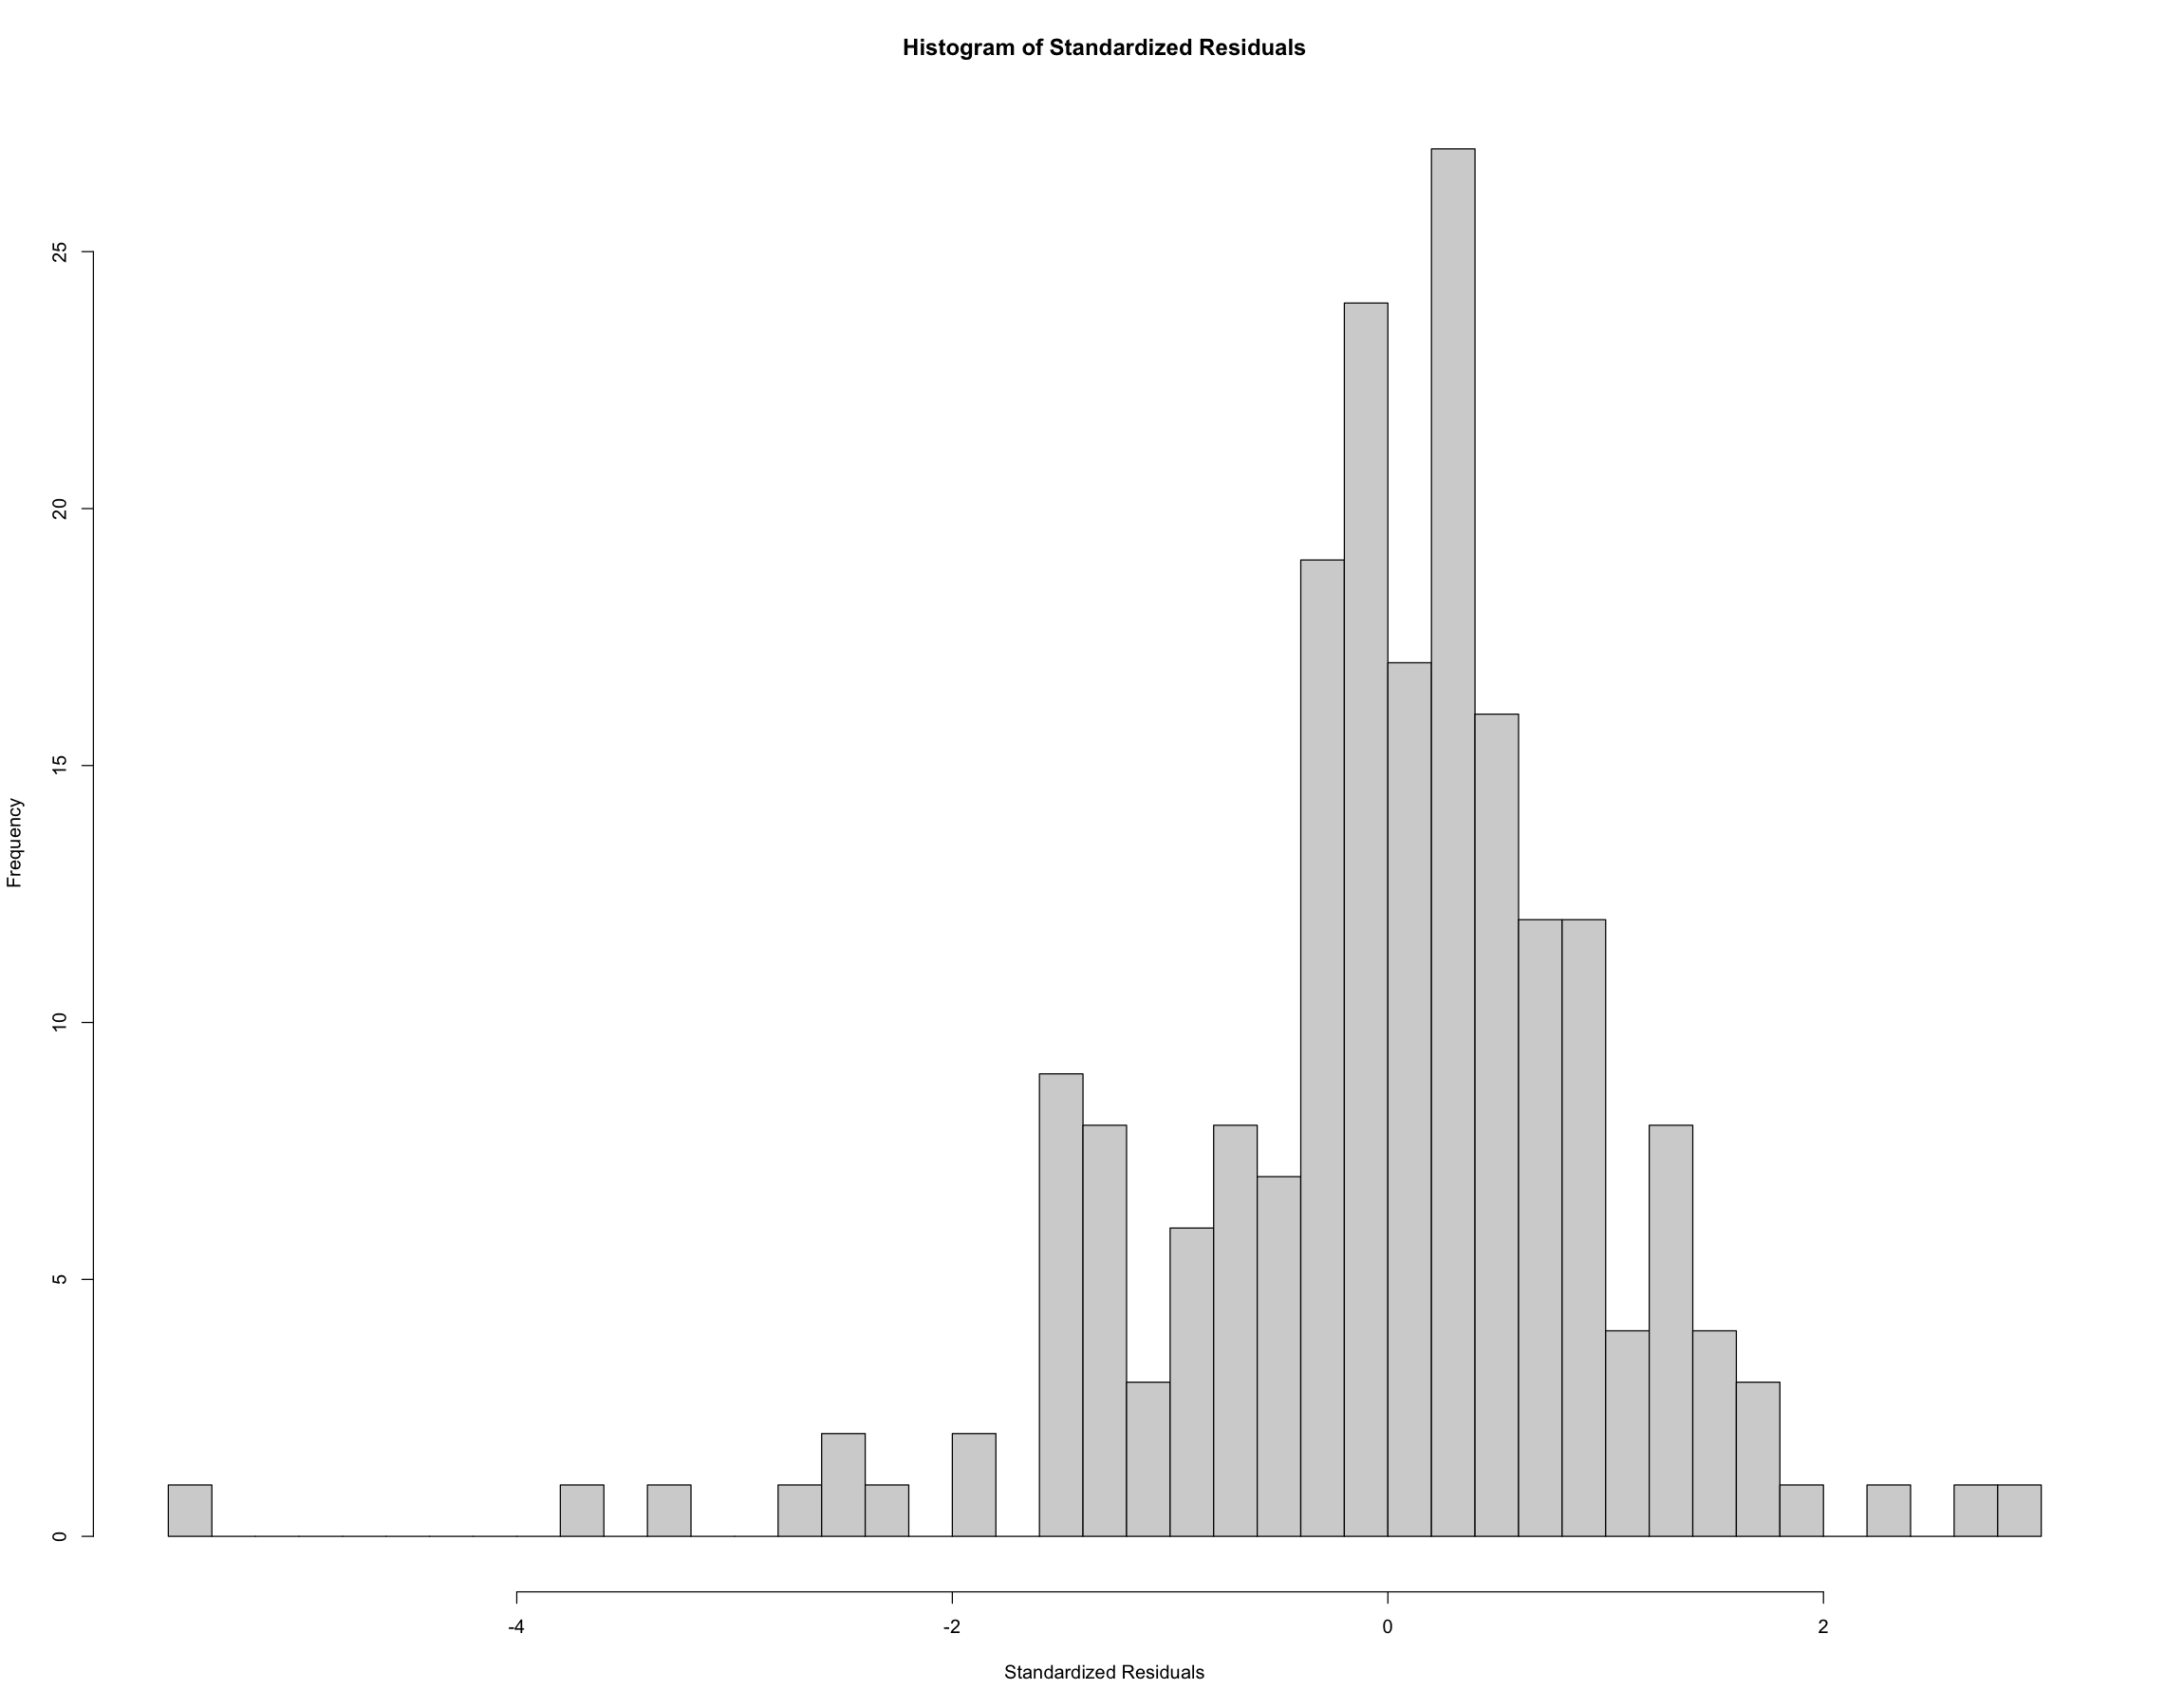

In [92]:
# Normal distibution for standardized residuals
hist(rstandard(mlr_model_cluster_transformed), breaks = 30,
     main = "Histogram of Standardized Residuals",
     xlab = "Standardized Residuals")

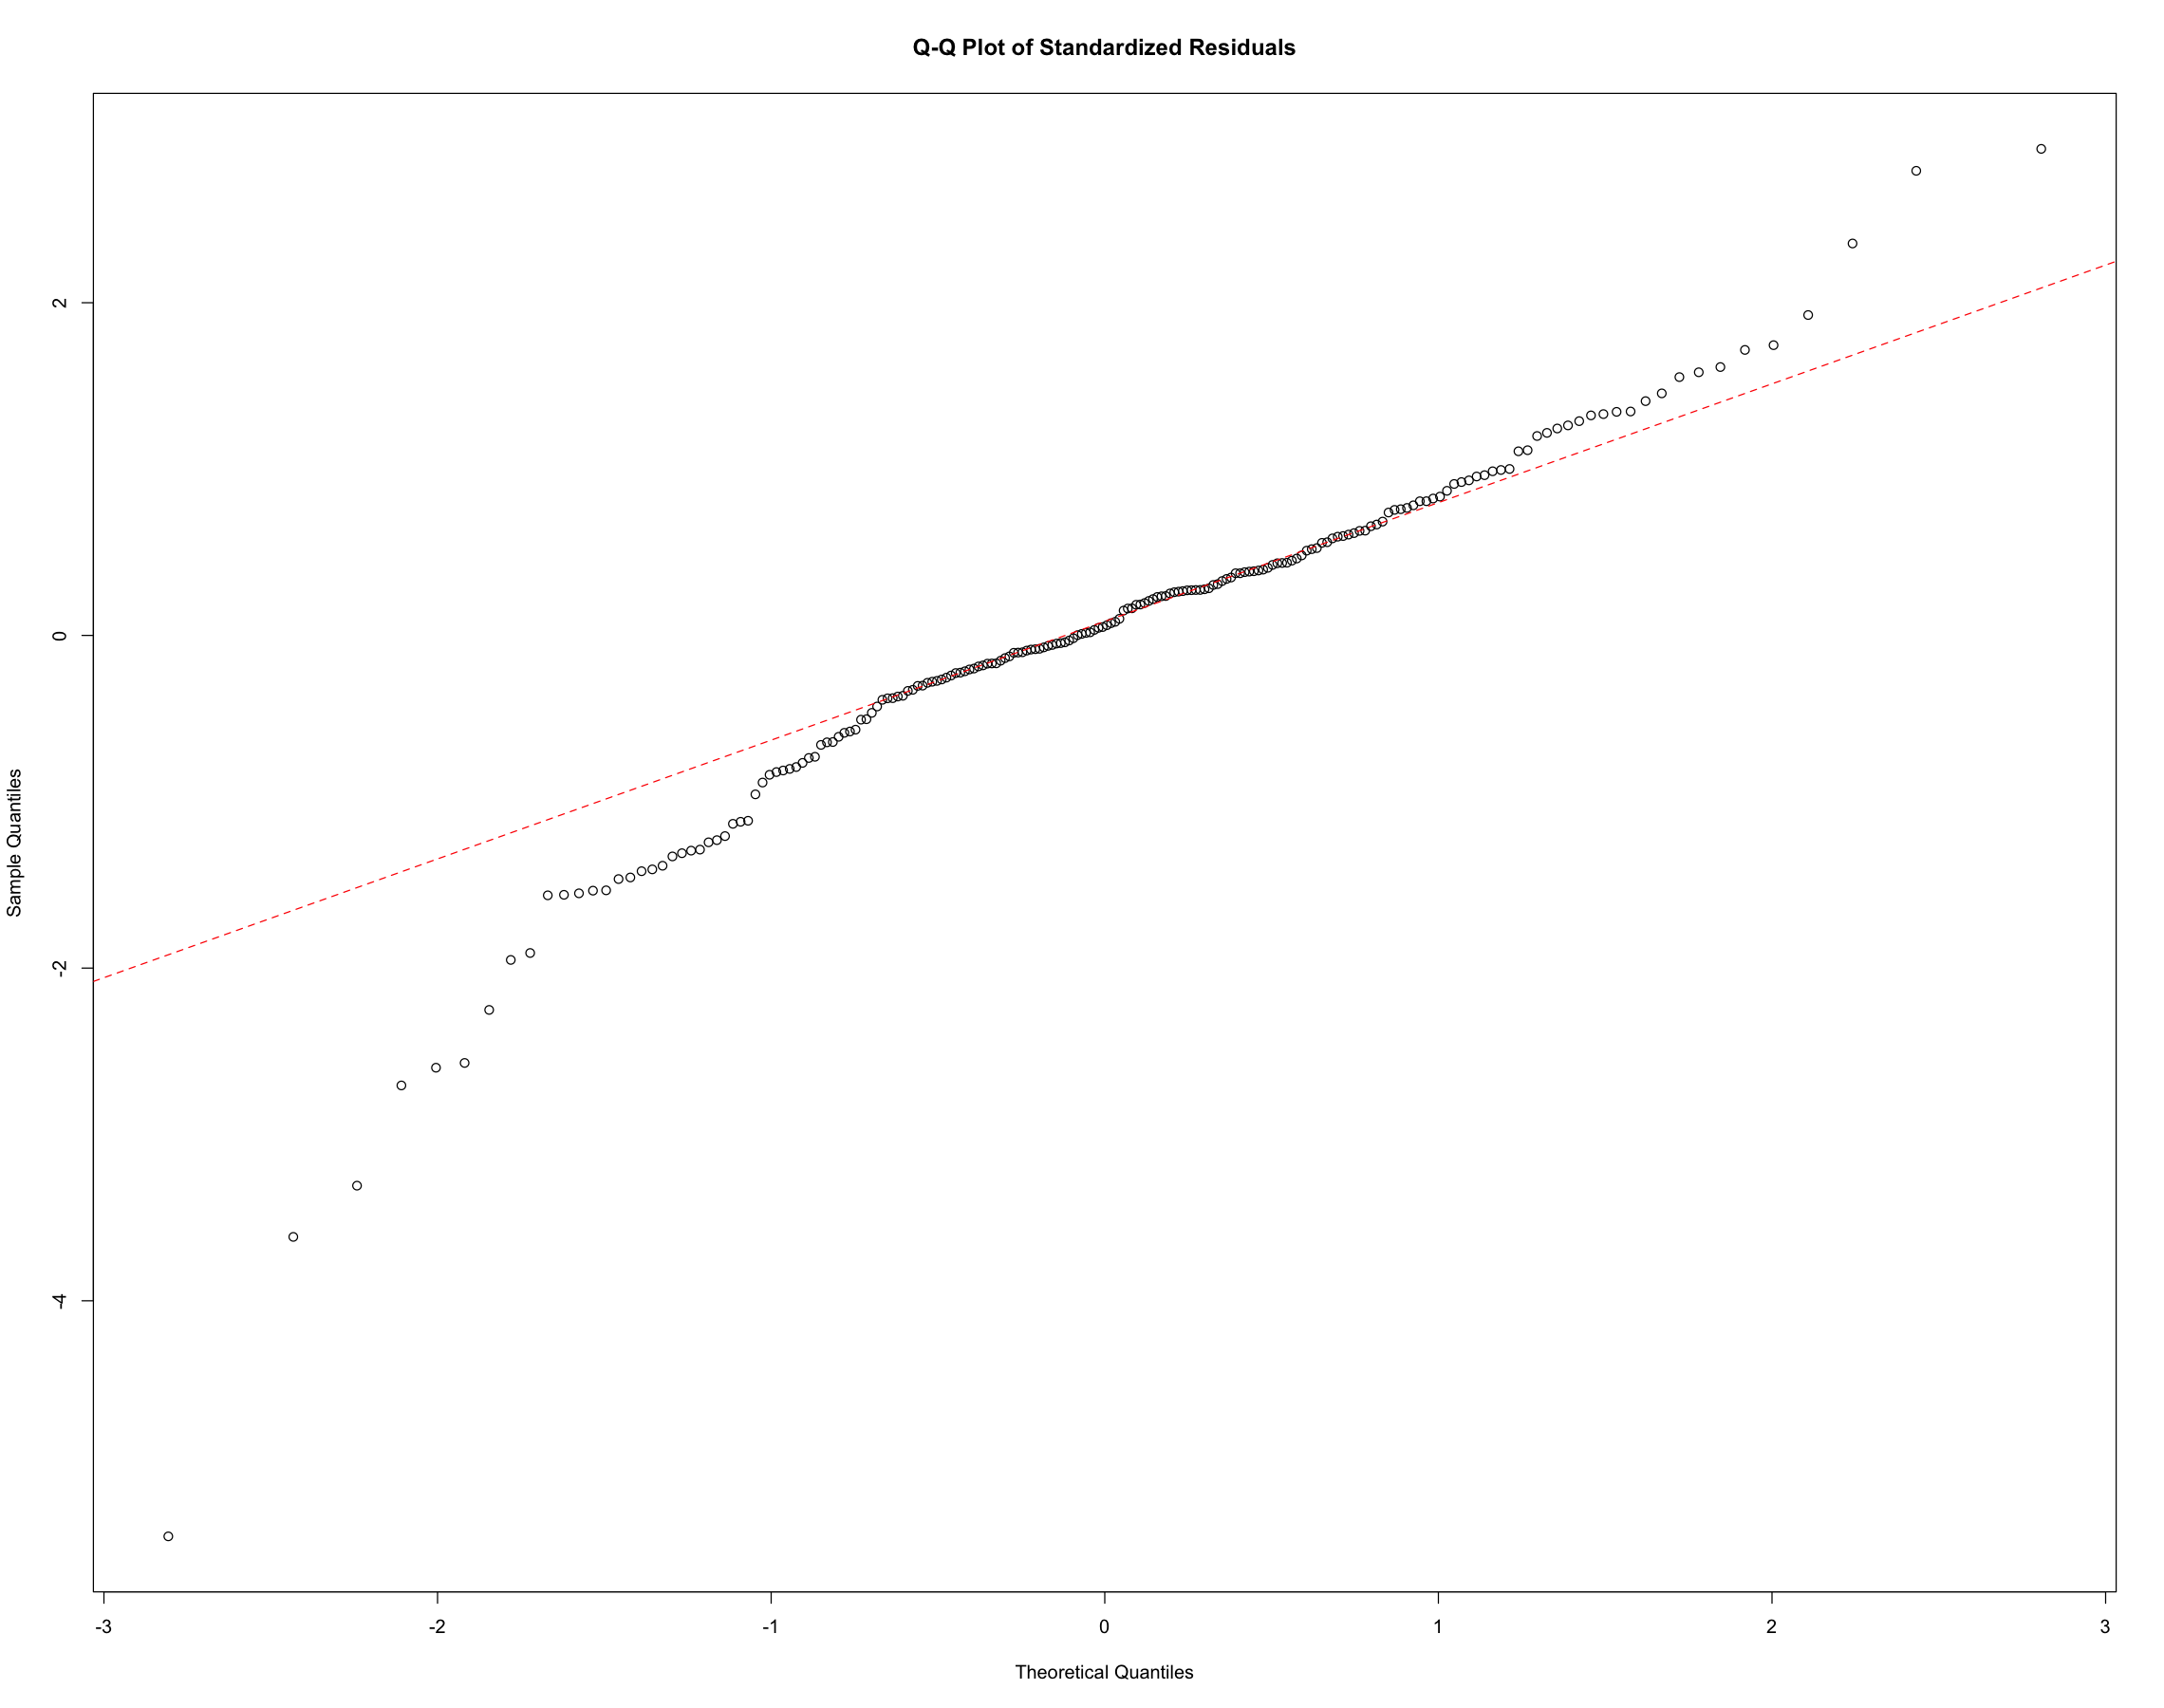

In [91]:
#Normal Q-Q Plot (Normality of Residuals)
qqnorm(rstandard(mlr_model_cluster_transformed), main = "Q-Q Plot of Standardized Residuals")
qqline(rstandard(mlr_model_cluster_transformed), col = "red", lty = 2)

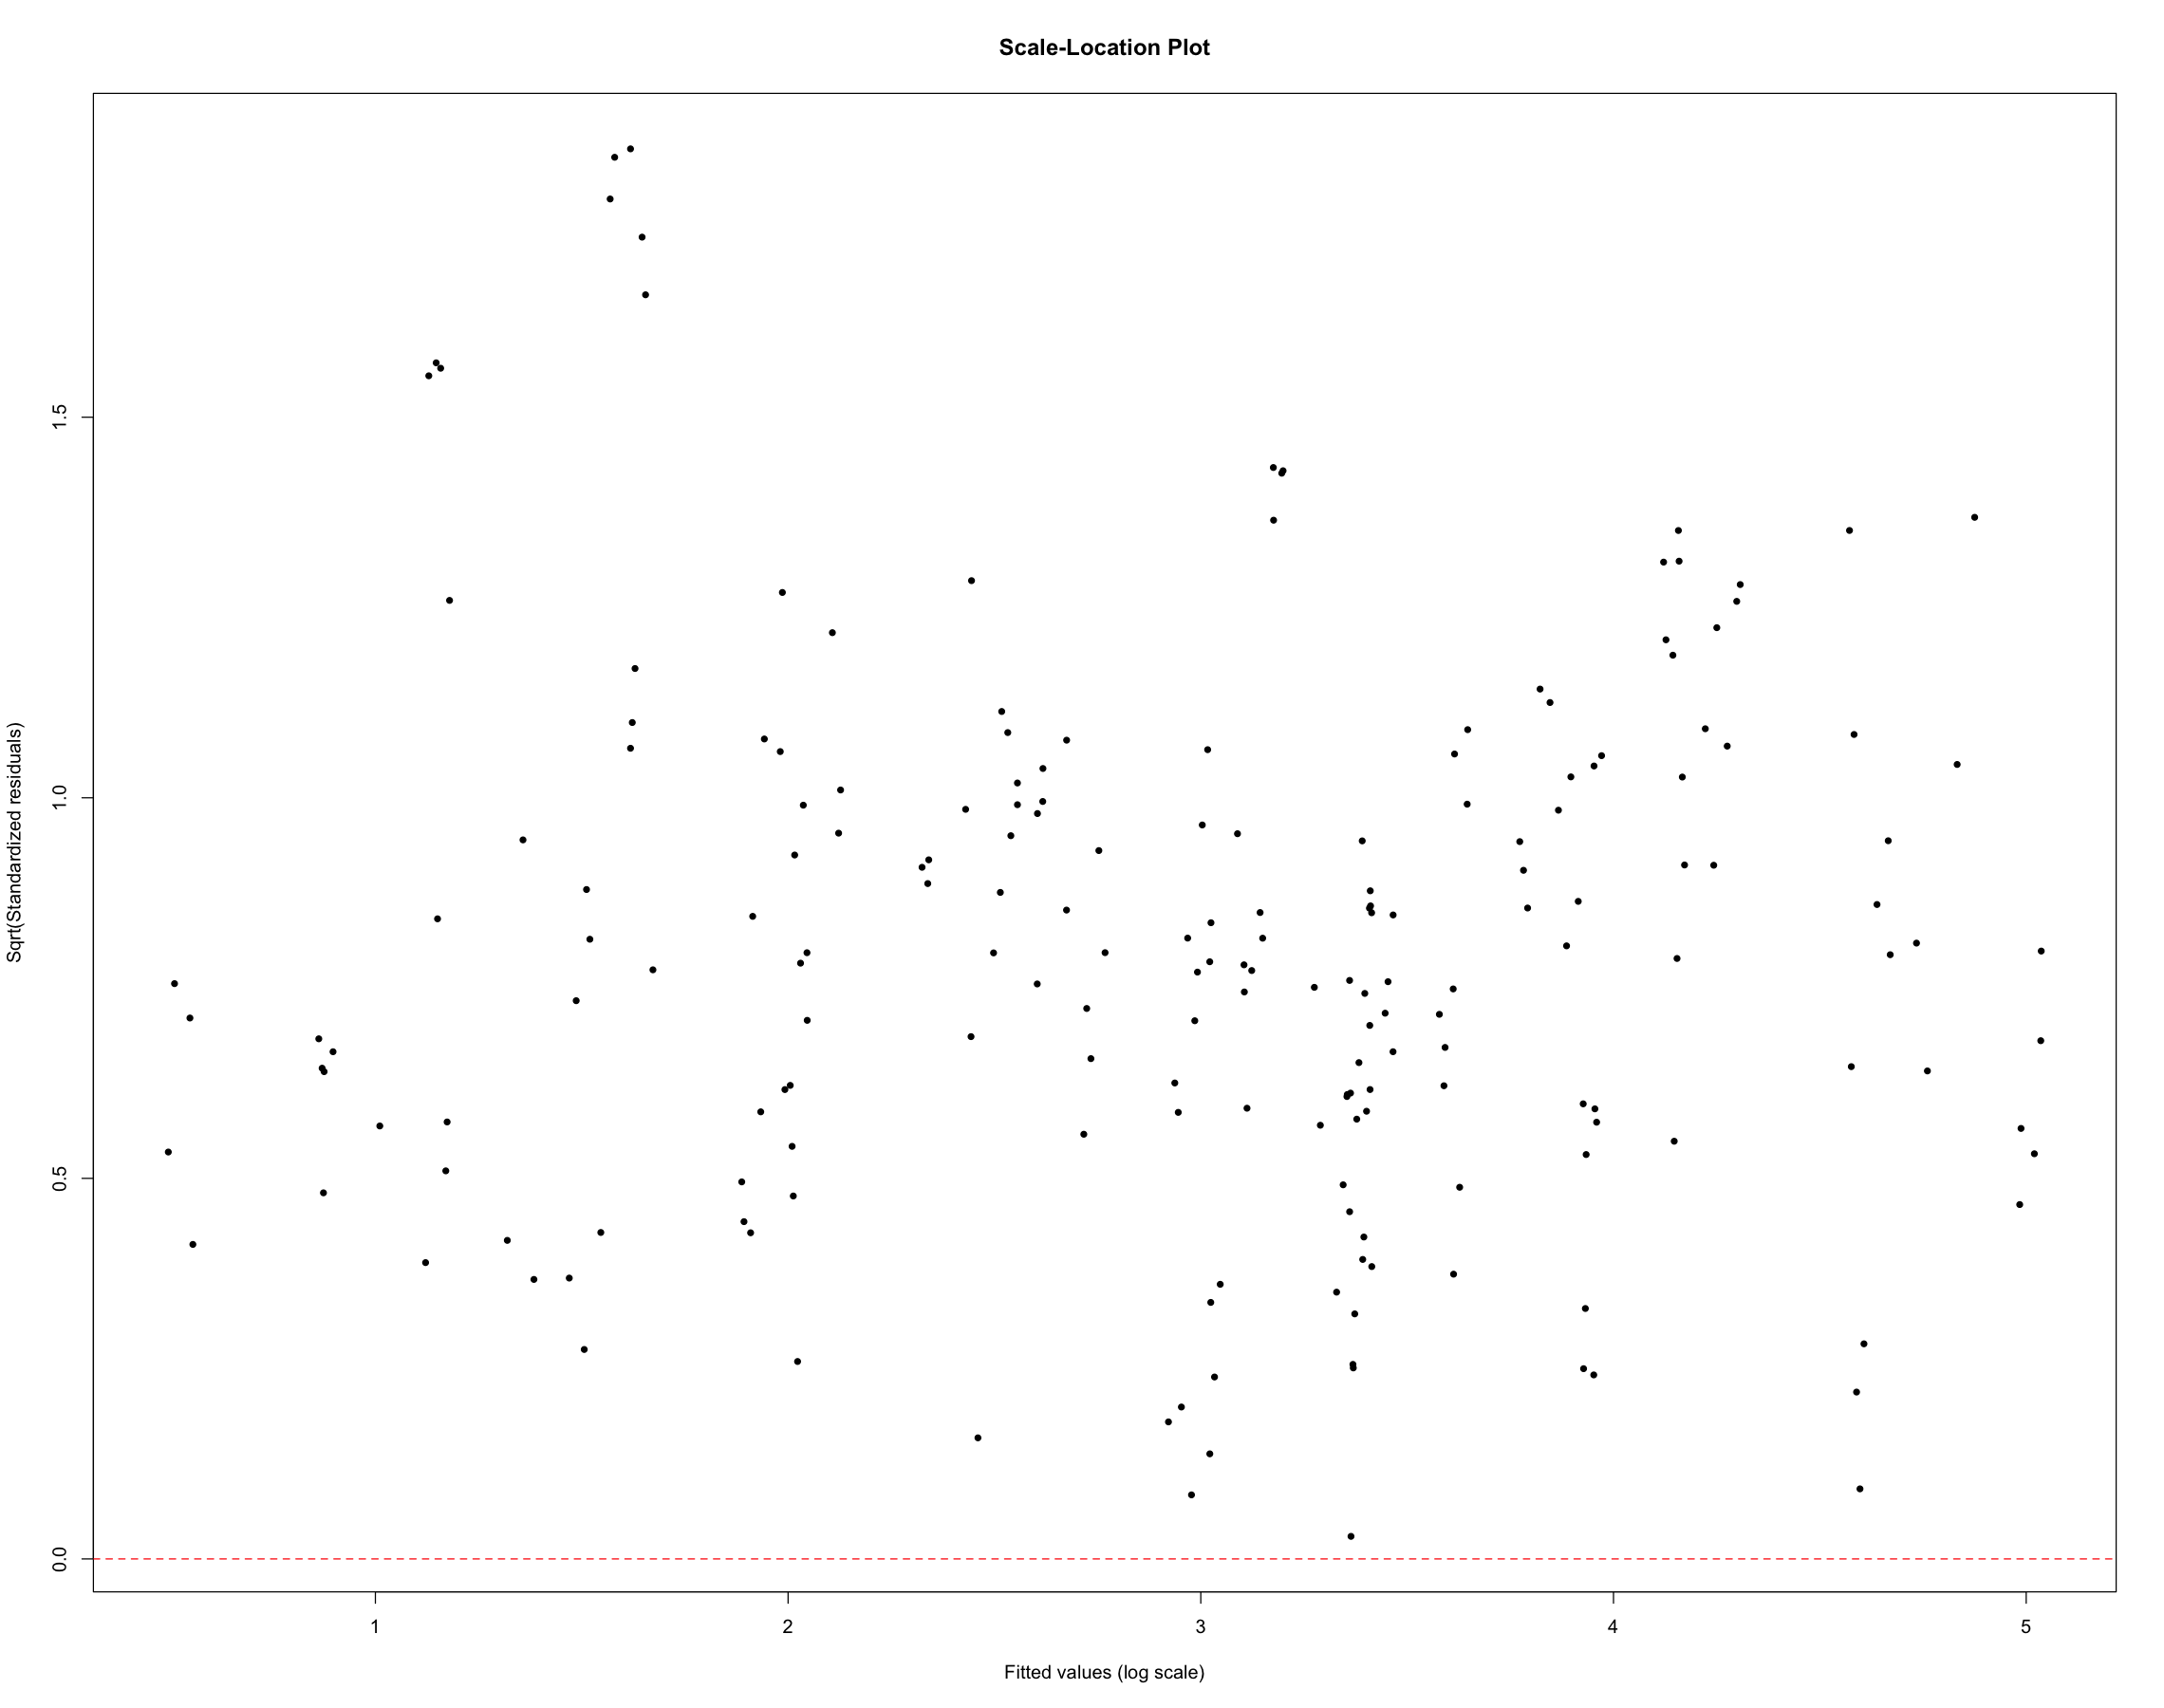

In [93]:
#Scale-Location Plot (Homoscedasticity)
plot(mlr_model_cluster_transformed$fitted.values, sqrt(abs(rstandard(mlr_model_transformed))),
     xlab = "Fitted values (log scale)",
     ylab = "Sqrt(Standardized residuals)",
     main = "Scale-Location Plot",
     pch = 20)
abline(h = 0, lty = 2, col = "red")

In [98]:
alias(mlr_model)


Model :
total_balance_billions ~ race_two_or_more + race_white + race_black + 
    race_native + race_asian + race_pacific_islander + hispanic_or_latino + 
    population_18_or_over_male + employment_total_employed + 
    mean_household_income_dollars + total_population_bachelors_degree + 
    total_veteran + total_foreign_born_pop + total_household_w_internet + 
    average_household_size + total_borrowers + state_cluster


In [103]:
vif(mlr_model)

GVIF         Df GVIF^(1/(2*Df))
race_two_or_more                     40.775452 1   6.385566      
race_white                          287.019654 1  16.941654      
race_black                          142.783246 1  11.949194      
race_native                          21.422187 1   4.628411      
race_asian                          129.609629 1  11.384622      
race_pacific_islander               138.030565 1  11.748641      
hispanic_or_latino                   13.115902 1   3.621588      
population_18_or_over_male            9.458311 1   3.075437      
employment_total_employed             5.697265 1   2.386894      
mean_household_income_dollars         6.300380 1   2.510056      
total_population_bachelors_degree     6.683899 1   2.585324      
total_veteran                         3.705359 1   1.924931      
total_foreign_born_pop               21.783220 1   4.667250      
total_household_w_internet            6.222582 1   2.494510      
average_household_size                2.777495 1   1.666582      
total_borrowers                       4.350525 1   2.085791      
state_cluster                     12545.578315 4   3.253204

In [ ]:
# Scratch work - MLR
set.seed(123)

student_debt_data <- read.csv("../data/combined_clean_data.csv")

train_idx <- sample(seq_len(nrow(student_debt_data)), size = floor(0.8 * nrow(borrower_data)))
train_data <- student_debt_data[train_idx, ]
test_data <- student_debt_data[-train_idx, ]
# Prep train data
train_data <- train_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
# Prepare test data
test_data <- test_data %>%
  mutate(minority_share = 1 - race_white) %>%
  select(-starts_with("race_")) %>%
  select(-state, -year, -population_18_or_over_female, -employment_total_unemployed)
colnames(test_data)
colnames(train_data)
#mlr_model <- lm(total_balance_billions ~ . -year, data = train_data)
mlr_model <- lm(total_balance_billions ~ ., data = train_data)

summary(mlr_model)
vif(mlr_model)

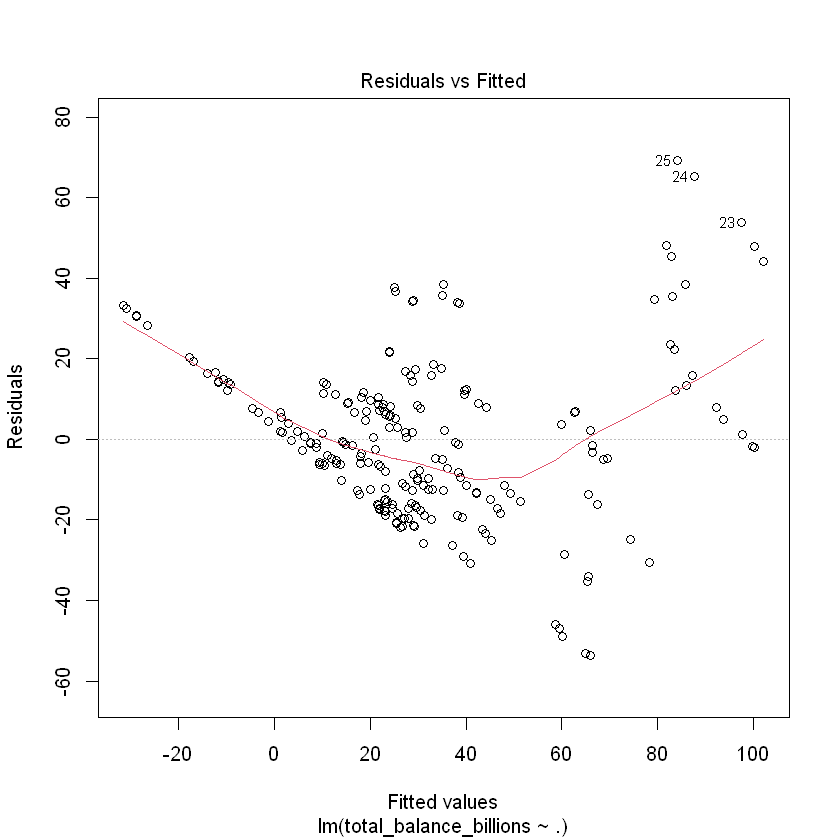

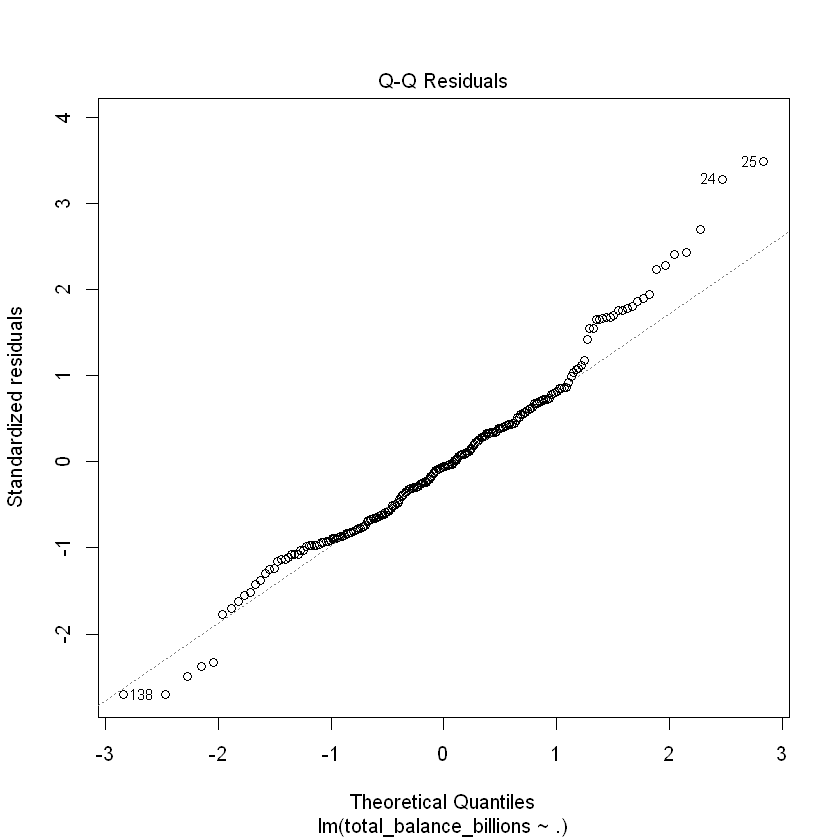

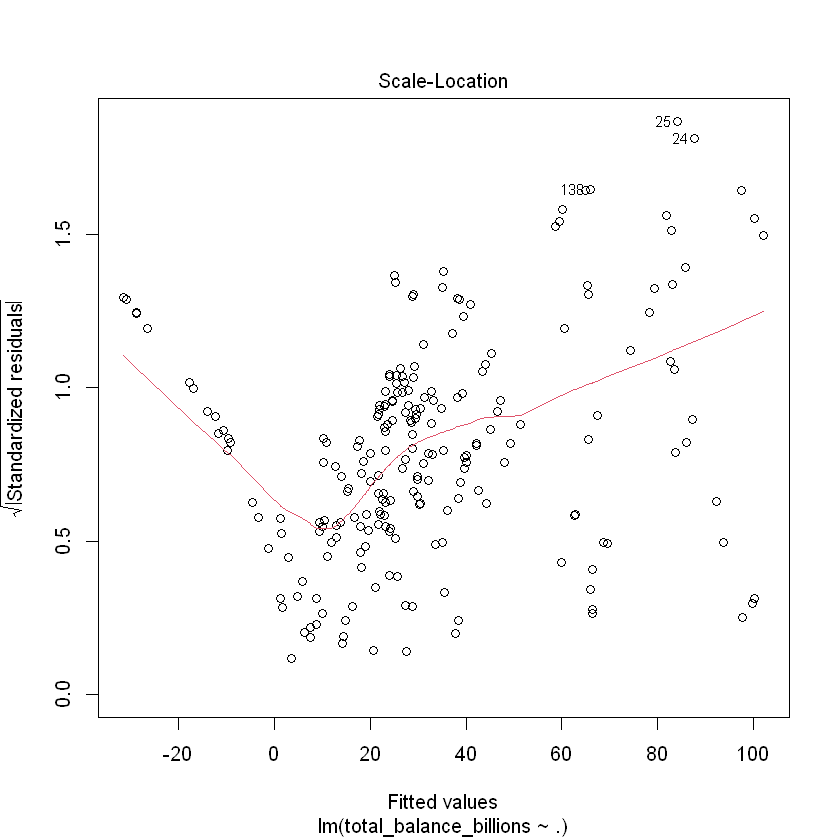

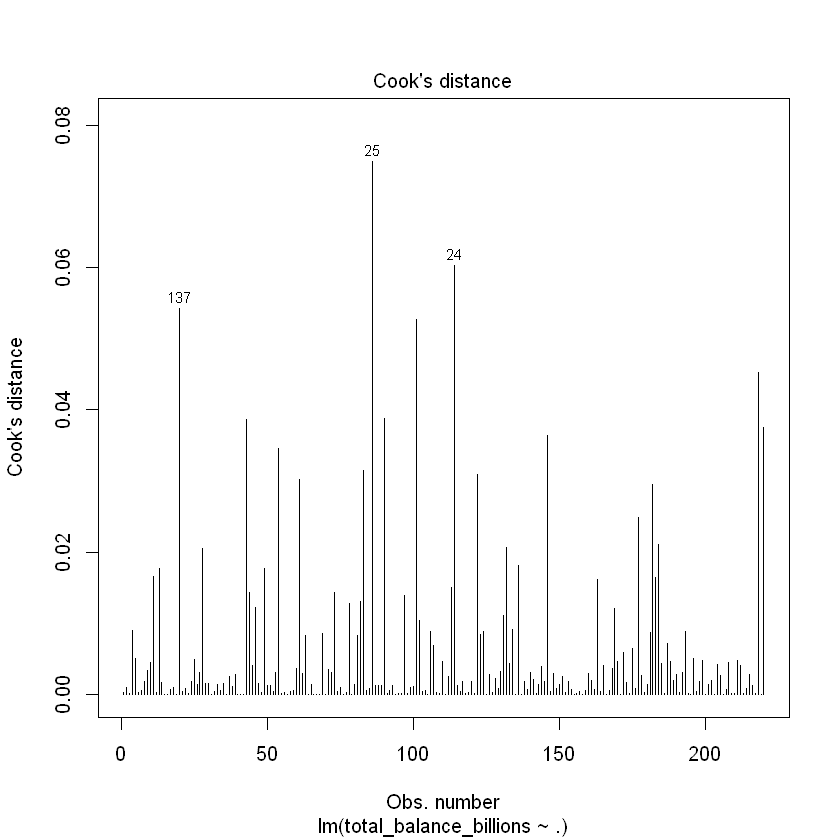

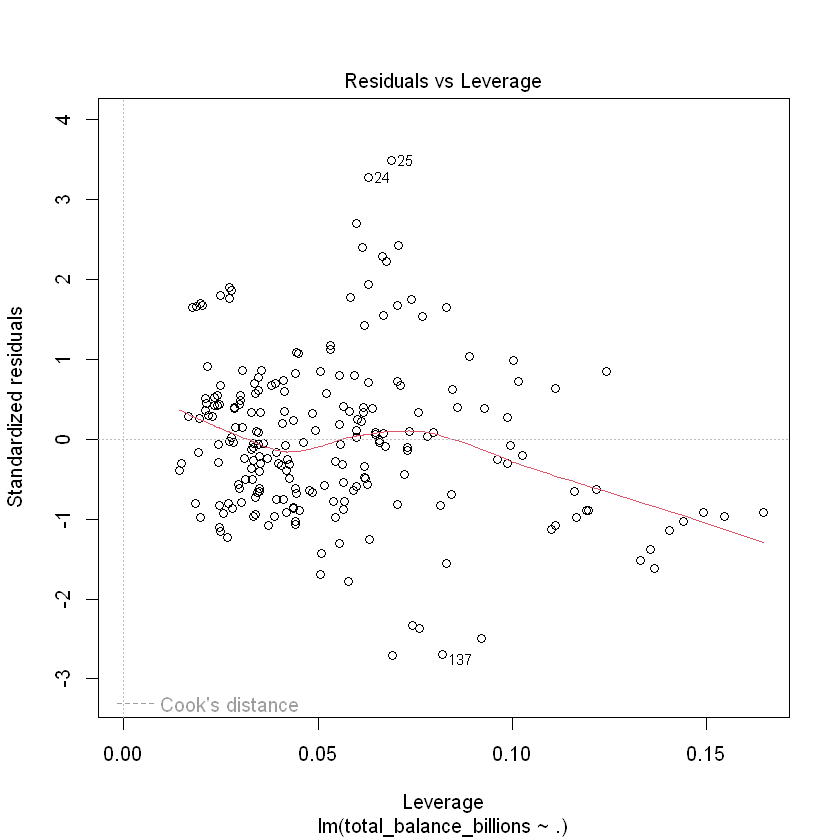

In [7]:
plot(mlr_model, which = 1)
plot(mlr_model, which = 2)
plot(mlr_model, which = 3)
plot(mlr_model, which = 4)
plot(mlr_model, which = 5)

In [10]:
mlr_model_transformed <- lm(log(total_balance_billions) ~ ., data = train_data)
summary(mlr_model_transformed)


Call:
lm(formula = log(total_balance_billions) ~ ., data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.50590 -0.43261  0.02354  0.40901  1.14826 

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.655e+00  3.042e+00   1.530   0.1274    
hispanic_or_latino                -4.288e-01  5.672e-01  -0.756   0.4505    
population_18_or_over_male        -1.586e+01  7.264e+00  -2.184   0.0301 *  
employement_total_employed        -5.795e+00  2.161e+00  -2.682   0.0079 ** 
mean_household_income_dollars     -5.494e-05  4.904e-06 -11.203  < 2e-16 ***
total_population_bachelors_degree  3.271e+00  1.545e+00   2.118   0.0354 *  
total_veteran                     -2.049e+01  3.505e+00  -5.845 1.94e-08 ***
total_foreign_born_pop             9.526e+00  1.326e+00   7.183 1.19e-11 ***
total_household_w_internet         1.173e+01  1.652e+00   7.104 1.89e-11 ***
average_household_size             3.18

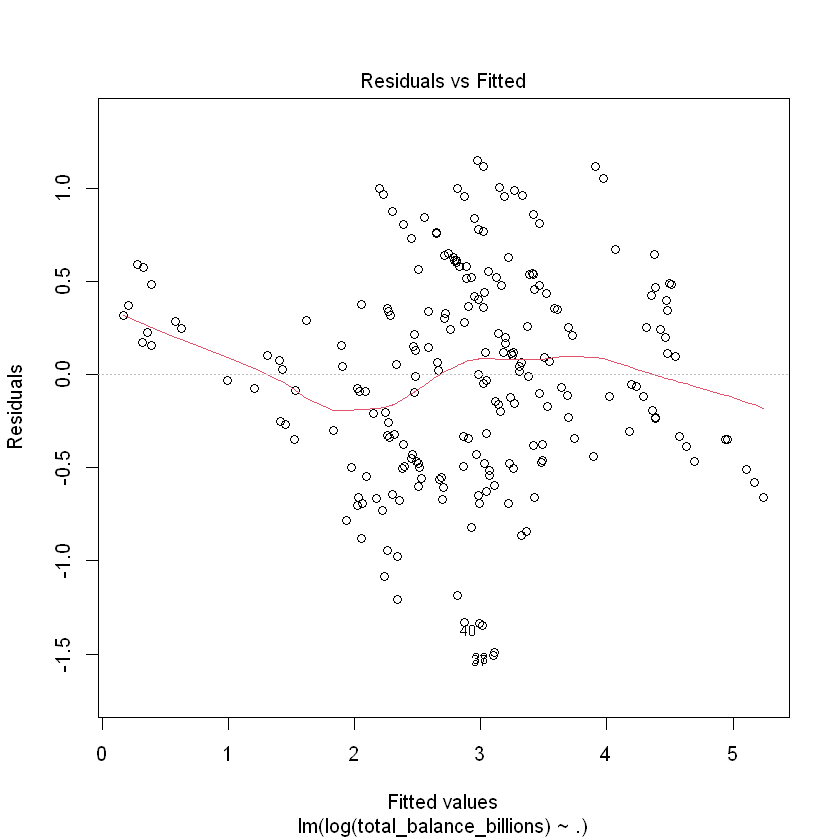

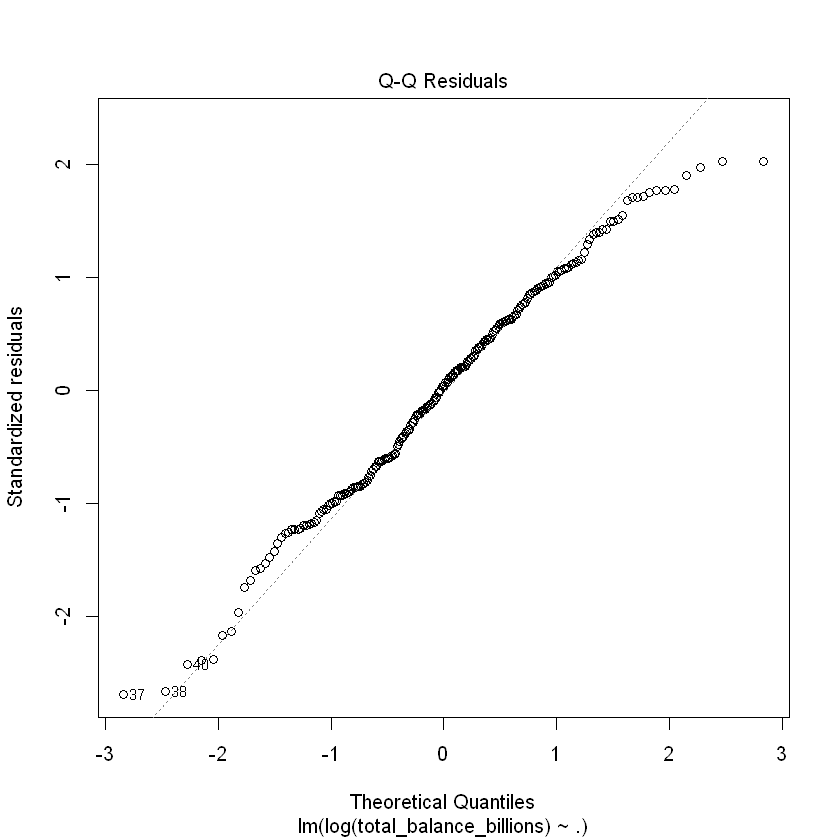

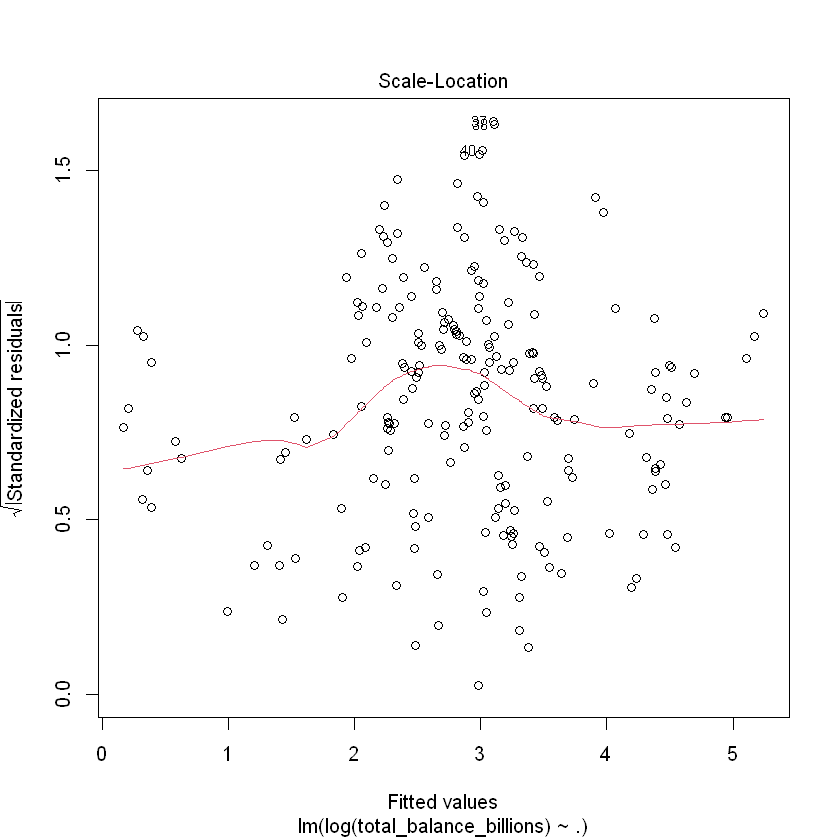

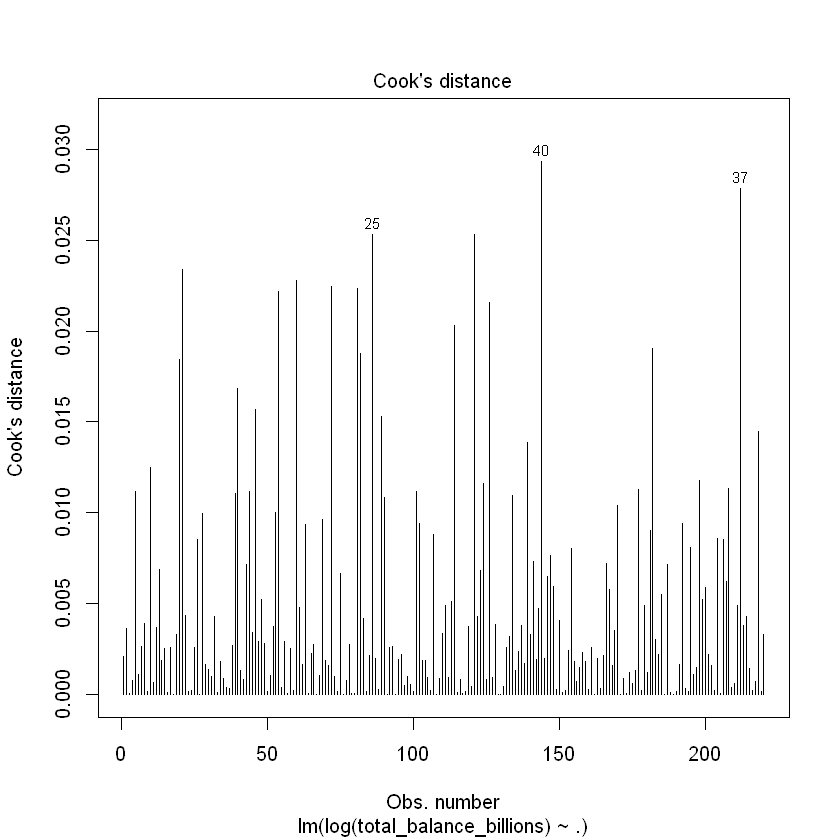

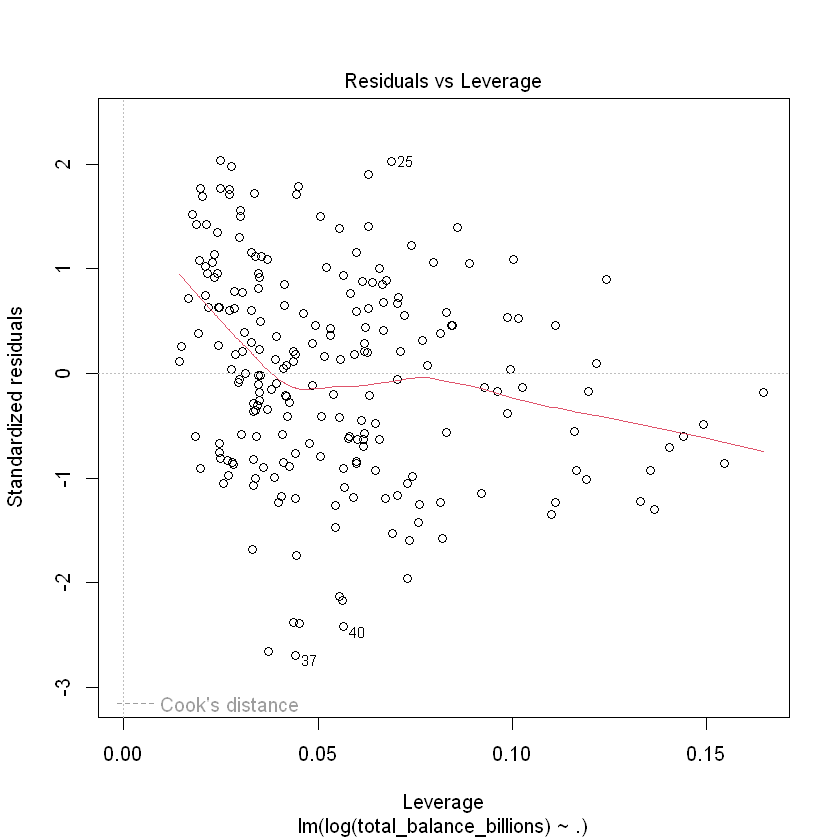

In [11]:
plot(mlr_model_transformed, which = 1)
plot(mlr_model_transformed, which = 2)
plot(mlr_model_transformed, which = 3)
plot(mlr_model_transformed, which = 4)
plot(mlr_model_transformed, which = 5)

## Predictions

# Step 0. Data Cleaning (Done)
- Read demographics and social characteristics data from the US census website
- Read the student loan and borrowed data from NY Fed Bank website
- Clean and model the data (standardize each data per state)
- Create train and test sets
# Step 1. Models to explore
- MLR Model (Done)
- Transformed MLR Model (Done)
- Clustered model (Done)
- Transformed clustered model
- Elastic Net: Variable selection

# Step 2. Goodness of fit tests/Model Assumptions
- Linearity
- Constant Variance
- Independence
- Normality

# Step 3. Prediction
- MLR
- Transformed
- Clustered
- Transformed clustered
- Elastic Net
- Look at the 5 models and actual value
- Predict with a threshold of 0.3
- Confusion matrix with specificity and sensitivity

# Step 4. Interpret
- Interpret the best model and explain why we chose the model and pitfalls of the model